# Project 2: AI for Global Health using Natural Language Processing

## Part 1: Data exploration and pre-processing

### Q1: Preprocessing

In [1]:
# Aish's really nice preprocessing

import pandas as pd
import numpy as np
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re # regex
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

/tmp/ipykernel_98/2955603802.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tweets = pd.read_csv('TweetsCOV19.csv', index_col=0)#.head(20000)
Got rid of 126507 tweets by finding duplicates
Got rid of 3 tweets by invalid indices
Got rid of 52897 tweets by finding invalid TweetIds
Got rid of 0 tweets by finding invalid timestamps
Got rid of 0 tweets by finding invalid NoFollowers, NoFriends, NoRetweets, NoFavorites
Got rid of 113179 tweets by finding NaNs in all other columns
/tmp/ipykernel_98/2955603802.py:52: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_tweets[['pos_sent', 'neg_sent']] = df_tweets['Sentiment'].str.split(' ', 1, expand=True)


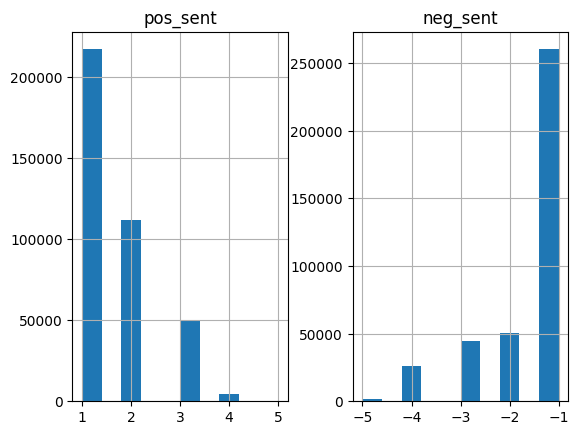

In [2]:
df_tweets = pd.read_csv('TweetsCOV19.csv', index_col=0)#.head(20000)
nb_tweets_initial = df_tweets.shape[0]

# drop exact duplicates
df_tweets = df_tweets.drop_duplicates()
df_tweets = df_tweets[~df_tweets.index.duplicated(keep='first')] # drop duplicate indices (keep first instance) @JURAJ 
nb_duplicates=df_tweets.shape[0]
print('Got rid of %d tweets by finding duplicates' %(nb_tweets_initial - nb_duplicates))

# drop non integer tweet indices @JURAJ
df_tweets['numbers']= pd.to_numeric(df_tweets.index, errors='coerce')
df_tweets = df_tweets.dropna(subset=['numbers']).set_index('numbers')
nb_invalid_index=df_tweets.shape[0]
print('Got rid of %d tweets by invalid indices' %(nb_duplicates - nb_invalid_index))

# drop non integer tweet ID rows
df_tweets = df_tweets[df_tweets['TweetId'].apply(lambda x: isinstance(x, (int, float, np.int64, np.float64)))]
nb_tweets_tweetID = df_tweets.shape[0]
print('Got rid of %d tweets by finding invalid TweetIds' %(nb_invalid_index - nb_tweets_tweetID))
df_tweets['TweetId'].isna().sum() # got rid of NaN tweet IDs too 

# drop invalid time stamps
mask = pd.to_datetime(df_tweets['Timestamp'], format='%Y-%m-%d', errors='coerce').notna()
df_tweets = df_tweets.loc[mask, :]
nb_tweets_timestamp = df_tweets.shape[0]
print('Got rid of %d tweets by finding invalid timestamps' %(nb_tweets_tweetID - nb_tweets_timestamp))

# we remove tweets with invalid columns even though in the end, we really are mostly using
# only tweettext, this is because we fear cols with NaN vals in some cells can have errors
# in tweettext and hashtags and so forth too

# drop non integer/'float' NoFollowers, NoFriends, NoRetweets, NoFavorites and cast all to int
df_tweets = df_tweets[df_tweets['NoFollowers'].apply(lambda x: isinstance(x, (int, float, np.int64, np.float64)))]
df_tweets = df_tweets[df_tweets['NoFriends'].apply(lambda x: isinstance(x, (int, float, np.int64, np.float64)))]
df_tweets = df_tweets[df_tweets['NoRetweets'].apply(lambda x: isinstance(x, (int, float, np.int64, np.float64)))]
df_tweets = df_tweets[df_tweets['NoFavorites'].apply(lambda x: isinstance(x, (int, float, np.int64, np.float64)))]
nb_tweets_numerical = df_tweets.shape[0]
print('Got rid of %d tweets by finding invalid NoFollowers, NoFriends, NoRetweets, NoFavorites' %(nb_tweets_timestamp - nb_tweets_numerical))
df_tweets[['NoFollowers', 'NoFriends', 'NoRetweets', 'NoFavorites']] = df_tweets[['NoFollowers', 'NoFriends', 'NoRetweets', 'NoFavorites']].astype('int')


# drop NaNs for all remaining cols 
df_tweets = df_tweets.dropna()
nb_tweets_nans = df_tweets.shape[0]
print('Got rid of %d tweets by finding NaNs in all other columns' %(nb_tweets_numerical - nb_tweets_nans))

# look at the sentiments
sentiments_range =  df_tweets['Sentiment'].unique()
sentiments_range

# first digit is positive sentiment, second is negative sentiment - split column into 2
df_tweets[['pos_sent', 'neg_sent']] = df_tweets['Sentiment'].str.split(' ', 1, expand=True)
df_tweets= df_tweets.drop('Sentiment', axis=1)
df_tweets[['pos_sent', 'neg_sent']] = df_tweets[['pos_sent', 'neg_sent']].dropna()

hist = df_tweets[['pos_sent', 'neg_sent']].astype('int').hist(bins=10) # most tweets aren't extreme in sentiment


# save some examples of text 
hashtag_ex_before = df_tweets['TweetText'][13]
capitalisation_ex_before = df_tweets['TweetText'][7]

In [3]:
replace_url_with = ''
replace_mention_with = ''
#replace_emoji_with = 'emoji'
#replace_number_with = 'number'

def rep(m):
    s=m.group(1)
    return ' '.join(re.split(r'(?=[A-Z])', s))


df_tweets['TweetText'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))',replace_url_with, x) for x in df_tweets['TweetText']] #remove url
df_tweets['TweetText'] = [re.sub('@[^\s]+', replace_mention_with , x) for x in df_tweets['TweetText']] #remove all mentions
df_tweets['TweetText'] = [x.encode("ascii", "ignore").decode() for x in df_tweets['TweetText']] # remove emojis

df_tweets['TweetText'] = [re.sub(r'#(\w+)', rep, x) for x in df_tweets['TweetText']] # split hashtags that are stuck together if they have case change: #iLovePotatoes becomes i love potatoes
df_tweets['TweetText'] = [re.sub(r'\W+', ' ', x) for x in df_tweets['TweetText']] # remove all characters that aren't alphabetical - hashtags, punctuation, slashes...
df_tweets['TweetText'] = df_tweets["TweetText"].astype(str).str.replace('\d+', '') # remove numbers entirely
df_tweets['TweetText'] = df_tweets['TweetText'].str.lower() #lowercase

# TODO: replace emojis with 'emoji' and numbers with 'number' - after discussion

# save some examples of text 
hashtag_ex_after = df_tweets['TweetText'][13]
capitalisation_ex_after = df_tweets['TweetText'][7]

/tmp/ipykernel_98/458580481.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets['TweetText'] = df_tweets["TweetText"].astype(str).str.replace('\d+', '') # remove numbers entirely


In [4]:
# show some examples:
print('BEFORE: ', hashtag_ex_before, '\n NOW: ', hashtag_ex_after)
print('________________')
print('BEFORE: ', capitalisation_ex_before, '\n NOW: ', capitalisation_ex_after)


BEFORE:  @realDonaldTrump You are such a dick.

#MoscowMitch 
#ImpeachTrumpPenceBarr
#ImpeachTrump
#ImpeachmentNow
#NepotismBarbie
#TrumpCrimeFamily
#TruthExposed
#ImpeachmentInquiry
#TrumpResign https://t.co/DteWeU126h 
 NOW:   you are such a dick moscow mitch impeach trump pence barr impeach trump impeachment now nepotism barbie trump crime family truth exposed impeachment inquiry trump resign 
________________
BEFORE:  #LIVE: Chaos expected on Oct 1 across Hong Kong as anti-government protesters aim to spoil China's partyl. Follow o… https://t.co/RQH5WoQ3PG 
 NOW:   l i v e chaos expected on oct  across hong kong as anti government protesters aim to spoil china s partyl follow o 


In [5]:
# create new column called 'normalised tweet engagement'
# normalise the number of retweets and favourites by followers and friends value

following_importance = 2
eps = 0.0000001 # avoid div by 0

df_tweets['norm_engagement'] = (df_tweets['NoRetweets'] + df_tweets['NoFavorites'])/ (following_importance * df_tweets['NoFollowers'] + eps)

In [6]:
lemmmatizer=WordNetLemmatizer()

df_tweets_preprocessed = df_tweets[['TweetText', 'pos_sent', 'neg_sent', 'norm_engagement']]

# tokenize and remove stopwords (done in the unigrams section as well)

set_stopwords = set(stopwords.words('english'))

df_tweets_preprocessed['tokens'] = df_tweets_preprocessed['TweetText'].apply(nltk.word_tokenize)

df_tweets_preprocessed['unigram']=[[lemmmatizer.lemmatize(item) for item in list_item if item not in set_stopwords and len(item) >=2 and item != "amp"] for list_item in df_tweets_preprocessed['tokens']]

#pre-processing done! we can drop raw tweettext and tokens column as well
# only keep unigram column:
df_tweets_preprocessed = df_tweets_preprocessed[['unigram', 'pos_sent', 'neg_sent', 'norm_engagement']]

df_tweets_preprocessed.head()

/tmp/ipykernel_98/2062711129.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_preprocessed['tokens'] = df_tweets_preprocessed['TweetText'].apply(nltk.word_tokenize)
/tmp/ipykernel_98/2062711129.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_preprocessed['unigram']=[[lemmmatizer.lemmatize(item) for item in list_item if item not in set_stopwords and len(item) >=2 and item != "amp"] for list_item in df_tweets_preprocessed['tokens']]


unigram pos_sent neg_sent  \
numbers                                                                        
0.0      [blog, californian, support, vaccine, law, new...        2       -1   
1.0      [secretary, state, recall, stormont, next, mon...        2       -1   
2.0      [serving, afghanistan, marine, corporal, brand...        2       -3   
3.0      [witch, vixen, season, start, tomorrow, receiv...        1       -1   
4.0      [cgtn, scene, around, troop, equipment, unit, ...        1       -1   

         norm_engagement  
numbers                   
0.0         0.000000e+00  
1.0         6.382506e-03  
2.0         1.054830e-05  
3.0         1.809409e-03  
4.0         4.567364e-07

### Q2: Exploratory data analysis

In [ ]:
df_labels_only = df_tweets[['pos_sent', 'neg_sent']].astype('int').abs()
df_labels_only = df_labels_only.groupby(['pos_sent', 'neg_sent']).size().sort_values(ascending=False).reset_index(name='count') 
df_labels_only.head(30)

pos_sent  neg_sent   count
0          1         1  154825
1          2         1   74632
2          3         1   33890
3          1         2   27464
4          1         3   25211
5          2         2   16387
6          2         3   14560
7          1         4   13815
8          2         4    8500
9          3         2    6916
10         3         3    5659
11         3         4    3807
12         4         1    3022
13         1         5     746
14         4         2     600
15         4         3     493
16         2         5     466
17         4         4     420
18         3         5     197
19         5         1     136
20         4         5      24
21         5         2      23
22         5         3      22
23         5         4      20
24         5         5       2

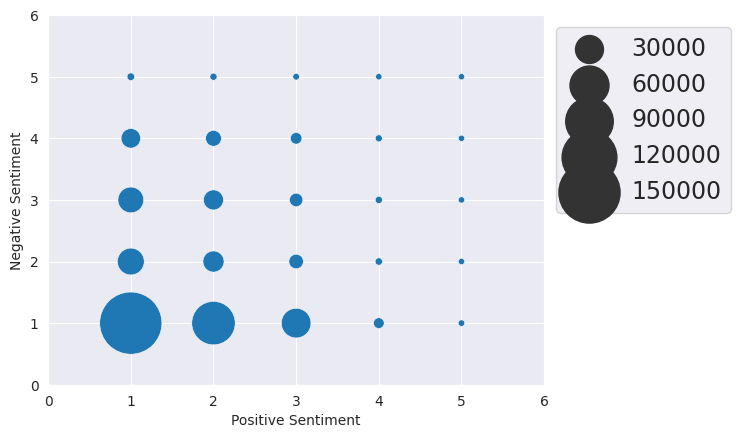

In [ ]:
sns.set_style("darkgrid")

sns.scatterplot(data=df_labels_only, x="pos_sent", y="neg_sent", size="count", legend='auto', sizes=(20, 2000))
plt.xlabel("Positive Sentiment")
plt.ylabel("Negative Sentiment")
plt.xlim(0,6)
plt.ylim(0,6)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=17)
plt.show()

# plotted negative values as positive so they are easier to plot, but remember they are negative labels
# notice that while most tweets are neutral (1-1 = 0), there are more overall negative than positive
# e.g., (1, 4) > (4, 1), (1, 5) > (5, 1), (2, 4) > (4, 1) ...

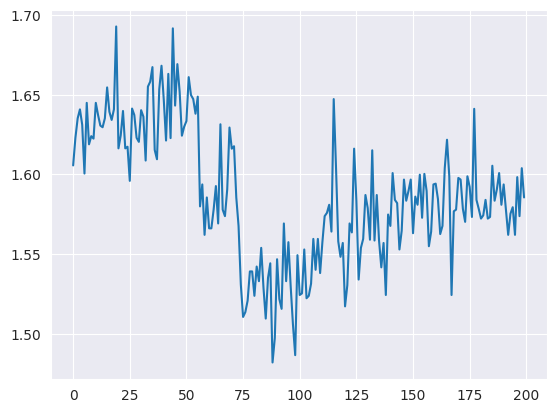

In [ ]:
# see overall tweet sentiment as a variation in time

# sort df timestamps
df_tweets['Timestamp'] = pd.to_datetime(df_tweets['Timestamp'])
df_tweets = df_tweets.sort_values(by='Timestamp', ascending=True)

# plot positive and negative sentiments as li
nb_bins = 200
bin_size = df_tweets['pos_sent'].shape[0]/200

df_split = np.array_split(df_tweets['pos_sent'], nb_bins)
vals = pd.Series([np.mean(x.astype('int')) for x in df_split])
positive_ser = vals.plot.line()

# observe that there's a big dip in positivity in the middle 
# TODO: set axis to pd datetime then find 'mean' for each bin to display here
# TODO: apply moving average

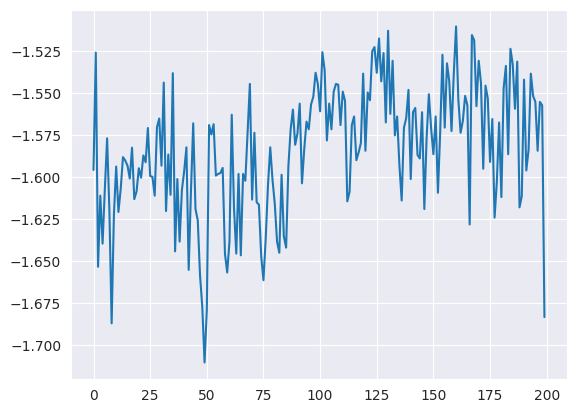

In [ ]:

df_split = np.array_split(df_tweets['neg_sent'], nb_bins)
vals = pd.Series([np.mean(x.astype('int')) for x in df_split])
positive_ser = vals.plot.line()

In [ ]:
set_stopwords = set(stopwords.words('english'))

df_tweets['tokens'] = df_tweets['TweetText'].apply(nltk.word_tokenize)

df_tweets['unigram']=[[item for item in list_item if item not in set_stopwords ] for list_item in df_tweets['tokens']]
df_tweets[['tokens','unigram']][0:5]


# # create unigram counter
from collections import Counter
from nltk.lm.preprocessing import flatten
from operator import itemgetter

count_1gram= Counter (flatten(list_item for list_item in df_tweets['unigram']))
print(len(count_1gram))
print(sorted(list(count_1gram.items()),key=itemgetter(1),reverse=True)[0:10])


#ignore stopword amp: twitter keyword


183453
[('coronavirus', 61440), ('c', 39242), ('amp', 38588), ('covid', 37368), ('people', 33273), ('v', 31713), ('china', 24831), ('like', 24538), ('home', 22780), ('us', 22724)]


In [ ]:
# bigrams
from nltk.util import ngrams
df_tweets['bigrams'] = df_tweets['unigram'].apply(lambda row: list(nltk.ngrams(row, 2))) # use unigram col instead of tokens bc it already has the stopwords filtered out

count_2gram= Counter (flatten(list_item for list_item in df_tweets['bigrams']))
print(len(count_2gram))
print(sorted(list(count_2gram.items()),key=itemgetter(1),reverse=True)[0:10])

3010296
[(('c', 'v'), 28222), (('stay', 'home'), 12637), (('social', 'distancing'), 7118), (('corona', 'virus'), 6937), (('stay', 'safe'), 3999), (('coronavirus', 'pandemic'), 3676), (('coronavirus', 'outbreak'), 3619), (('gon', 'na'), 3303), (('hong', 'kong'), 2220), (('save', 'lives'), 2137)]


In [ ]:
# TODO: compare unigrams and bigrams above to ones before preprocessing
# TODO: compute unigrams and bigrams for each label type
# can display as unigrams and bigrams as wordclouds :)
# https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model check this for fun data exploration ideas

### Q3: Metric choice

- as we see in the bubble chart, the classes aren't balanced - most tweets are very neutral (low positive and low negative)
- we can either make this a classification problem - with 25 classes in total (5x5) or a regression problem
- what makes most sense is to have two classification heads, that use INTEGER labels and SPARSE categorical cross entropy as a loss 
- DO NOT one-hot encode the labels since the classes have an a-priori integer order
- after embedding tweet texts (and possibly including other features like time stamp, location, followers, retweets, friends, favourites)
- we apply an ML/DL model with integer classification outputs, and the input is an embedding vector of all features above
- loss: sparse categorical cross entropy
- metric for performance: classic multi-class metrics --> confusion matrix with classification_report
- per class precision, recall, F-beta scores
- consider negative and positive SEPARATELY - then overall scores are average of both
- like this we don't consider a prediction entirely wrong if one of the categories (positive or negative) is entirely wrong
- we can also weight the accuracy score by how far from the real class we are: e.g., 1 vs 5 is much worse than 1 vs 2  
--> multiclass, multioutput task

Main metric:
* f1-weighted mean, so calculate the f1-weighted score for {pos, neg} sentiment, then average the two values

In [ ]:
# Code snippet of metrics:
# show confusion_matrix and classification_report with seaborn visualisation so it looks nice
# consider weighting strategy

### Q4: Dataset splitting

In [7]:
# we noticed that there is a dip in positivity around the middle of the sorted dataset
# so it is possible that the train, val, test split can have label imbalance w.r.t. each other if we split without shuffling rows
# solution: shuffle rows and pick train, test, val splits 
# if we remove the time stamp input feature entirely, we can avoid look-ahead bias entirely
# however, the dataset will remain unbalanced towards neutral tweets

y = df_tweets_preprocessed[['pos_sent', 'neg_sent']]
X = df_tweets_preprocessed[['unigram', 'norm_engagement']]

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=0.33, shuffle=True,random_state=42)


In [ ]:
Counter(map(lambda x: str(type(x)), X_train_val.index))

NameError: name 'Counter' is not defined

In [ ]:
print(len(list(X_train_val.index)))
print(len(set(X_train_val.index)))



262530
262528


In [ ]:
X_train_val.index

Index([468059,  80623, 520224, 135676, 263666, 213514, 412299, 122563, 279961,
       439867,
       ...
       182149,  72263, 366352, 145979, 158945, 431680, 568200, 174932, 194708,
       161754],
      dtype='object', length=262530)

In [ ]:
# export preprocessed datasets to files

import os
os.makedirs("export", exist_ok=True)

for df, name in [
    (X_train_val, "x_train_val"),
    (X_test, "x_test"),
    (y_train_val, "y_train_val"),
    (y_test, "y_test"),
]:
    df.to_pickle(f"export/{name}_{df.shape[0]//1000}k.pkl")

## Part 2: NLP learning based methods

## VADER

### Q1: Briefly explaining how VADER works

What is it?
blabla # TODO


### Q2: Provide a code snippet detailing how to use it for our task

In light of what you have learned about this method, reflect on pre-processing steps that might be unnecessary when using VADER.

- every pre-processing method is used here, except tokenization

- blabla

### Q3: Apply this method to our TweetsCOV19 dataset and comment on the
performance obtained

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

def map_sentiment(compound_val):
    if compound_val >= 0.05:
        return 'positive'
    if compound_val <= - 0.05:
        return 'negative'
    else:
        return 'neutral'

df_tweets['vader_polarity'] = [sid_obj.polarity_scores(sentence) for sentence in df_tweets['TweetText']]
df_tweets['vader_decision'] = [map_sentiment(sentiment_dict['compound']) for sentiment_dict in df_tweets['vader_polarity']]


In [9]:
# convert our dataset to positive, negative and neutral labels by adding pos_sent and neg_sent
df_tweets['overall_sent_GT'] = df_tweets['pos_sent'].astype('int') + df_tweets['neg_sent'].astype('int')

def map_int(val):
    if val > 0:
        return 'positive'
    if val < 0:
        return 'negative'
    else:
        return 'neutral'
    
df_tweets['overall_sent_GT'] = [map_int(val) for val in df_tweets['overall_sent_GT']]

from sklearn.metrics import confusion_matrix
confusion_matrix(df_tweets['overall_sent_GT'], df_tweets['vader_decision'])

# vader is actually quite terrible (or our GT labels are :))
# does it make sense to add positive and negative and claim that as the total score? 
# It would then say that  4, -4 is the same as 1 -1 for example

array([[67574,  4616, 20414],
       [46709, 70904, 55585],
       [12631,  7941, 96415]])

## Word Embeddings (20 pts)

### Q1: Bag of Words (BoW) (2 pts)

Implement a Bag of Words embedding approach to create embeddings of the TweetsCOV19 dataset. Explain the methodology and provide a code snippet of the function used to produce these embeddings.

Answer: Applying Bag of Words (BoW) to tokens is the exact same as one-hot encoding of tokens.  We implemented our version of BoW using 'CountVectorizer' from sklearn. To keep our implementation low in memory consumption, we choose to work with a vocabulary of size 250, which limits our token vectors to a size of 250.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, max_features=250)
bow_matrix = vectorizer.fit_transform(df_tweets_preprocessed['unigram'].apply(" ".join))
print(vectorizer.vocabulary_)

{'support': 203, 'vaccine': 229, 'new': 139, 'state': 196, 'next': 141, 'party': 153, 'start': 195, 'around': 13, 'like': 109, 'may': 124, 'coming': 33, 'look': 114, 'stopped': 200, 'think': 218, 'believe': 17, 'anything': 9, 'tell': 209, 'government': 79, 'china': 29, 'happened': 84, 'make': 118, 'happen': 83, 'trump': 223, 'family': 59, 'dropped': 48, 'love': 116, 'much': 133, 'see': 183, 'find': 62, 'global': 72, 'change': 26, 'many': 121, 'must': 134, 'healthcare': 90, 'really': 172, 'go': 73, 'day': 42, 'time': 220, 'said': 179, 'month': 131, 'part': 152, 'th': 213, 'say': 181, 'country': 39, 'stay': 197, 'need': 137, 'help': 91, 'home': 93, 'got': 78, 'na': 135, 'get': 69, 'never': 138, 'thought': 219, 'would': 245, 'better': 19, 'yet': 249, 'another': 7, 'best': 18, 'shit': 187, 'keep': 103, 'happening': 85, 'lockdown': 112, 'today': 221, 'big': 20, 'year': 247, 'ago': 1, 'team': 208, 'made': 117, 'one': 147, 'gon': 76, 'two': 225, 'let': 107, 'know': 105, 'morning': 132, 'every

### Q2: TF-IDF (2 pts)

Implement a TF-IDF embedding approach to create embeddings of the TweetsCOV19 dataset. Explain the methodology and provide a code snippet of the function used to produce these embeddings.

Answer: Similar to BoW, using TF-IDF results in an embedding vector that has the same size as the vocabulary.  Instead of one-hot encoding, the entry of a word in a vector is directly related to its frequency in that tweet, and inversely related to the commonality of that word in general (i.e. the occurrence of that word in all tweets).  We apply TfidfTransformer from sklearn to the BoW matrix we obtained in the previous question.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
bow_matrix_tfidf = transformer.fit_transform(bow_matrix)

### Q3: Word2Vec with CBOW or Skip-gram (2 pts)

Implement a Word2Vec pre-trained embedding approach to create embeddings of the TweetsCOV19 dataset. Motivate your
choice between CBOW or Skip-gram. Explain the methodology and provide a code snippet
 of the function used to produce these embeddings. 
>> Mikolov, Tomas, et al. "Advances in pre-training distributed word representations." arXiv preprint arXiv:1712.09405(2017).

Answer: CBOW is a word embedding model that predicts a word by looking at the context (i.e. the surrounding words). Skip-gram, on the other hand, does the opposite: it predicts the context of a word, by looking at the word itself.In general, Skip-gram is used more often, but CBOW  is much faster, which makes sense, since you only predict a single word for the latter. Since we would like for our model to take context into account, we opt to use Skip-gram. Still, we will compare this with the performance of CBOW later on in question 8 and 9. For computational reasons, we limit the vector size of a token to 20. In addition, we choose a context window of 3.

In [9]:
#!pip install gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

# following class function from https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch+1, loss_now))
        self.epoch += 1

In [10]:
context_size = 3 #hyperparameter - still to be tuned
vec_size = 20 #300 most commonly used, according to https://arxiv.org/pdf/1812.04224.pdf, but out of RAM in no time

In [ ]:
model_cbow = Word2Vec(min_count=1, vector_size=vec_size, window=context_size, sg=0, workers=20)
model_cbow.build_vocab(df_tweets_preprocessed['unigram'])
#takes about 1 min per epoch
model_cbow.train(df_tweets_preprocessed['unigram'], epochs=15, total_examples=model_cbow.corpus_count,
                 compute_loss=True, callbacks=[callback()])
model_cbow.save("word_embedding/cbow.model")
#get embedding of word as follows: model_cbow.wv['word']
#note that you can't query unseen words!

Loss after epoch 1: 40750.8984375
Loss after epoch 2: 33107.9375
Loss after epoch 3: 22907.609375
Loss after epoch 4: 28618.1484375
Loss after epoch 5: 27604.5625
Loss after epoch 6: 27163.421875
Loss after epoch 7: 26604.640625
Loss after epoch 8: 26319.734375
Loss after epoch 9: 25691.296875
Loss after epoch 10: 25385.4375
Loss after epoch 11: 25180.59375
Loss after epoch 12: 49986.09375
Loss after epoch 13: 24774.46875
Loss after epoch 14: 24270.34375
Loss after epoch 15: 24448.1875


In [ ]:
model_sgram = Word2Vec(min_count=1, vector_size=vec_size, window=context_size, sg=1, workers=20)
model_sgram.build_vocab(df_tweets_preprocessed['unigram'])
#takes about 2 mins per epoch
model_sgram.train(df_tweets_preprocessed['unigram'], epochs=15, total_examples=model_sgram.corpus_count,
                  compute_loss=True, callbacks=[callback()])
model_sgram.save("word_embedding/skip_gram.model")

Loss after epoch 1: 127186.6015625
Loss after epoch 2: 102755.9609375
Loss after epoch 3: 97400.3125
Loss after epoch 4: 92590.4375
Loss after epoch 5: 91295.5
Loss after epoch 6: 88701.0
Loss after epoch 7: 86655.0
Loss after epoch 8: 87685.75
Loss after epoch 9: 85428.8125
Loss after epoch 10: 84178.5
Loss after epoch 11: 84158.0
Loss after epoch 12: 83326.75
Loss after epoch 13: 83792.125
Loss after epoch 14: 83511.875
Loss after epoch 15: 85479.0


### Q4: GloVe (2 pts)

Implement a GloVe pre-trained embedding approach to create embeddings of the TweetsCOV19 dataset. Explain the methodology and provide a code snippet of the function used to produce these embeddings.
>> Pennington, Jeffrey, Richard Socher, and Christopher D. Manning. "Glove: Global vectors for word representation." Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP). 2014.

Answer: GloVe is an embedding method that counts how often a word occurs in a certain context. It combines these findings into a so-called co-occurrence matrix, which is then approximated by a lower-dimensional matrix to limit the vector size of the embeddings.

In [11]:
! pip install glove-python-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.9/974.9 KB 63.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [12]:
from glove import Glove, Corpus
corpus = Corpus() 
corpus.fit(df_tweets_preprocessed['unigram'], window=context_size)
model_glove = Glove(no_components=vec_size, learning_rate=0.05, alpha=0.75, max_count=100, max_loss=10.0)
model_glove.fit(corpus.matrix, epochs=15, no_threads=16, verbose=True)
model_glove.add_dictionary(corpus.dictionary)

Performing 15 training epochs with 16 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14


In [13]:
#from https://stackoverflow.com/questions/55693318/encoding-problem-while-training-my-own-glove-model
with open("word_embedding/results_glove.txt", "w") as f:
    for word in model_glove.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, vec_size):
            f.write(str(model_glove.word_vectors[model_glove.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")

In [14]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="word_embedding/results_glove.txt", word2vec_output_file="word_embedding/gensim_glove_vectors.txt")    

model_glove_gensim = KeyedVectors.load_word2vec_format("word_embedding/gensim_glove_vectors.txt", binary=False)

/tmp/ipykernel_98/2619436341.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file="word_embedding/results_glove.txt",


### Q5: FastText (2 pts)

Implement a FastText pre-trained embedding approach to create embedding of the TweetsCOV19 dataset. Explain the methodology and provide a code snippet of the function used to produce these embeddings.
>> Bojanowski, Piotr, et al. "Enriching word vectors with subword information." Transactions of the association for computational linguistics 5 (2017): 135-14

Answer: Different from the previous embedding methods, FastText uses n-grams as input for training to ensure that uncommon and unseen words can still be embedded. Training follows a similar fashion to the word2vec models mentioned earlier.

In [ ]:
# different from previous methods, FastText works for words that are not in initial
# vocabulary used for training the model
# previous methods try to find unique vector for each word, but FastText cares about
# morphological similarity of words (based on ngrams, so 'food' and 'good' will get high similarity score)

from gensim.models import FastText

context_size = context_size #hyperparameter (paper between and including 3-6)
vec_size = vec_size #300 used in paper, but out of RAM in no time
sg = 1 #cbow=0, skipgram=1

model_ft = FastText(min_count=1, vector_size=vec_size, window=context_size, workers=20, sg=0)
model_ft.build_vocab(df_tweets_preprocessed['unigram'])
#takes about 2 min 45sec per epoch, no loss computed in gensim!
model_ft.train(df_tweets_preprocessed['unigram'], epochs=15, total_examples=model_ft.corpus_count)
model_ft.save("word_embedding/fasttext.model")

### Q6: Visualization of embeddings (2 pts)

Perform a qualitative comparison of the quality of the semantic content of each embedding approach. For example, visualize the location using dimensionality reduction techniques (e.g., PCA, t-SNE, UMAP), of negative/positive samples, or tweets containing specific words, in the latent space. Compare your visualization of each method and explain whether you can anticipate any differences in downstream performance as a result.
>> L.J.P. van der Maaten and G.E. Hinton. Visualizing data using t-SNE. Journal of Machine Learning Research, 9(Nov):2431–2456, 2008.
>> McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018

Answer: We visualize our word embeddings both by the positive/negative score of tokens, but also by the keywords used for filtering the tweets. For the first method, we us a list of over 1400 positive and negative words, each with a rank (https://www2.imm.dtu.dk/pubdb/pubs/6010-bibtex.txt), and map their embeddings into the latent space t. For the second method, we use the keywords used for filtering the TweetCov19 dataset, and do the same.

In [ ]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 95.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 54.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82820 sha256=1714def6b37ecd0939e7141c92d8c670029a12d57545a2e4464ca7b627f719b2
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55624 sha256=c5fdc892be16824ae70a38452a2d745a3b2ef13e38c1dbb431fa75807b699040
  Stored in directory: /root/.cache/pip/wheels/f8/32/54/fa1fd0454e0441eaa32550ea2a86da3f64eb7c8e5a82436770
Successfully built umap-learn pynndescent
You should consider upg

In [ ]:
df_keywords = pd.read_table('keywords.txt', delimiter = '\t', names=['keyword'])

replace_url_with = ''
replace_mention_with = ''

df_keywords['keyword'] = [re.sub(r'#(\w+)', rep, x) for x in df_keywords['keyword']] # split hashtags that are stuck together if they have case change: #iLovePotatoes becomes i love potatoes
df_keywords['keyword'] = [re.sub(r'\W+', ' ', x) for x in df_keywords['keyword']] # remove all characters that aren't alphabetical - hashtags, punctuation, slashes...
df_keywords['keyword'] = df_keywords["keyword"].astype(str).str.replace('\d+', '') # remove numbers entirely
df_keywords['keyword'] = df_keywords['keyword'].str.lower() #lowercase

df_keywords['keyword'] = df_keywords['keyword'].apply(nltk.word_tokenize)
df_keywords['keyword'] = pd.DataFrame(list(set([a for b in df_keywords['keyword'].tolist() for a in b])))

lemmmatizer=WordNetLemmatizer()

set_stopwords = set(stopwords.words('english'))
df_keywords=pd.DataFrame([lemmmatizer.lemmatize(item) for item in df_keywords['keyword'] if item not in set_stopwords], columns=['keyword'])
df_keywords['keyword']=df_keywords['keyword'].astype(str)


# drop duplicates
df_keywords = df_keywords.drop_duplicates()

df_keywords

/tmp/ipykernel_99/2119768563.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_keywords['keyword'] = df_keywords["keyword"].astype(str).str.replace('\d+', '') # remove numbers entirely


keyword
0      coronavirusdeutschland
1                          dr
2              togetherathome
3                     kungflu
4                 lockdownzim
..                        ...
252                sinophobia
253                   nypause
254  coronavirusoutbreakindia
255              stayathomesa
256            covidsingapore

[251 rows x 1 columns]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
import umap


pos_neg_words = pd.read_table('AFINN-96.txt', delimiter = '\t', names=['word','sent'])
to_drop = []
for index, row in pos_neg_words.iterrows():
    try:
       av = model_cbow.wv[row['word']]
    except:
        to_drop.append(index)
print('Dropping', len(to_drop), 'words from the AFINN-96 dataset.')
pos_neg_words.drop(index=to_drop, inplace=True)

to_drop = []
for index, row in df_keywords.iterrows():
    try:
       av = model_cbow.wv[row['keyword']]
    except:
        to_drop.append(index)
print('Dropping', len(to_drop), 'words from the keywords.')
df_keywords.drop(index=to_drop, inplace=True)

#tsne part inspired by https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook
def plot_gensim(model, words, name, glove=False, posneg=False):
    labels = []
    tokens_t = []
    sent = []
    if posneg:
        for index, row in words.iterrows():
            if glove:
                tokens_t.append(model[row['word']])
            else:
                tokens_t.append(model.wv[row['word']])
            sent.append(int(row['sent']))
            labels.append(row['word'])
    else:
        for index, row in words.iterrows():
            if glove:
                tokens_t.append(model[row['keyword']])
            else:
                tokens_t.append(model.wv[row['keyword']])
            sent.append(0)
            labels.append(row['keyword'])
    
    pca_model = PCA(n_components=8, random_state=42)
    new_values_pca = pca_model.fit_transform(np.asarray(tokens_t))
    
    fig, ax = plt.subplots(3, 2, figsize=(32,32))
    for k, (perpl, neighb) in enumerate([(10,10),(20,20)]):
        print(k)
        tsne_model = TSNE(perplexity=perpl, n_components=2, init='pca', n_jobs=-1, verbose=0, random_state=42)
        new_values_tsne = tsne_model.fit_transform(np.asarray(tokens_t))
        trans = umap.UMAP(n_neighbors=neighb, random_state=42).fit(np.asarray(tokens_t))

        ax[0,k].scatter(new_values_pca[:,2*k], new_values_pca[:,2*k+1], c=sent, cmap='RdYlGn', s=6)
        ax[0,k].title.set_text('PCA')

        ax[1,k].scatter(new_values_tsne[:,0], new_values_tsne[:,1], c=sent, cmap='RdYlGn', s=6)
        ax[1,k].title.set_text('t-SNE')

        ax[2,k].scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=sent, cmap='RdYlGn', s=6)
        ax[2,k].title.set_text('UMAP')
        if not posneg:
            for i in range(len(labels)):
                ax[0,k].annotate(labels[i],
                                xy=(new_values_pca[i,2*k], new_values_pca[i,2*k+1]),
                                xytext=(5, 2),
                                textcoords='offset points',
                                ha='right',
                                va='bottom')

                ax[1,k].annotate(labels[i],
                                xy=(new_values_tsne[i,0],new_values_tsne[i,1]),
                                xytext=(5, 2),
                                textcoords='offset points',
                                ha='right',
                                va='bottom')

                ax[2,k].annotate(labels[i],
                                xy=(trans.embedding_[i, 0], trans.embedding_[i, 1]),
                                xytext=(5, 2),
                                textcoords='offset points',
                                ha='right',
                                va='bottom')
    plt.savefig(name)
    plt.show()

/root/venv/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/venv/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/venv/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

0
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
1
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


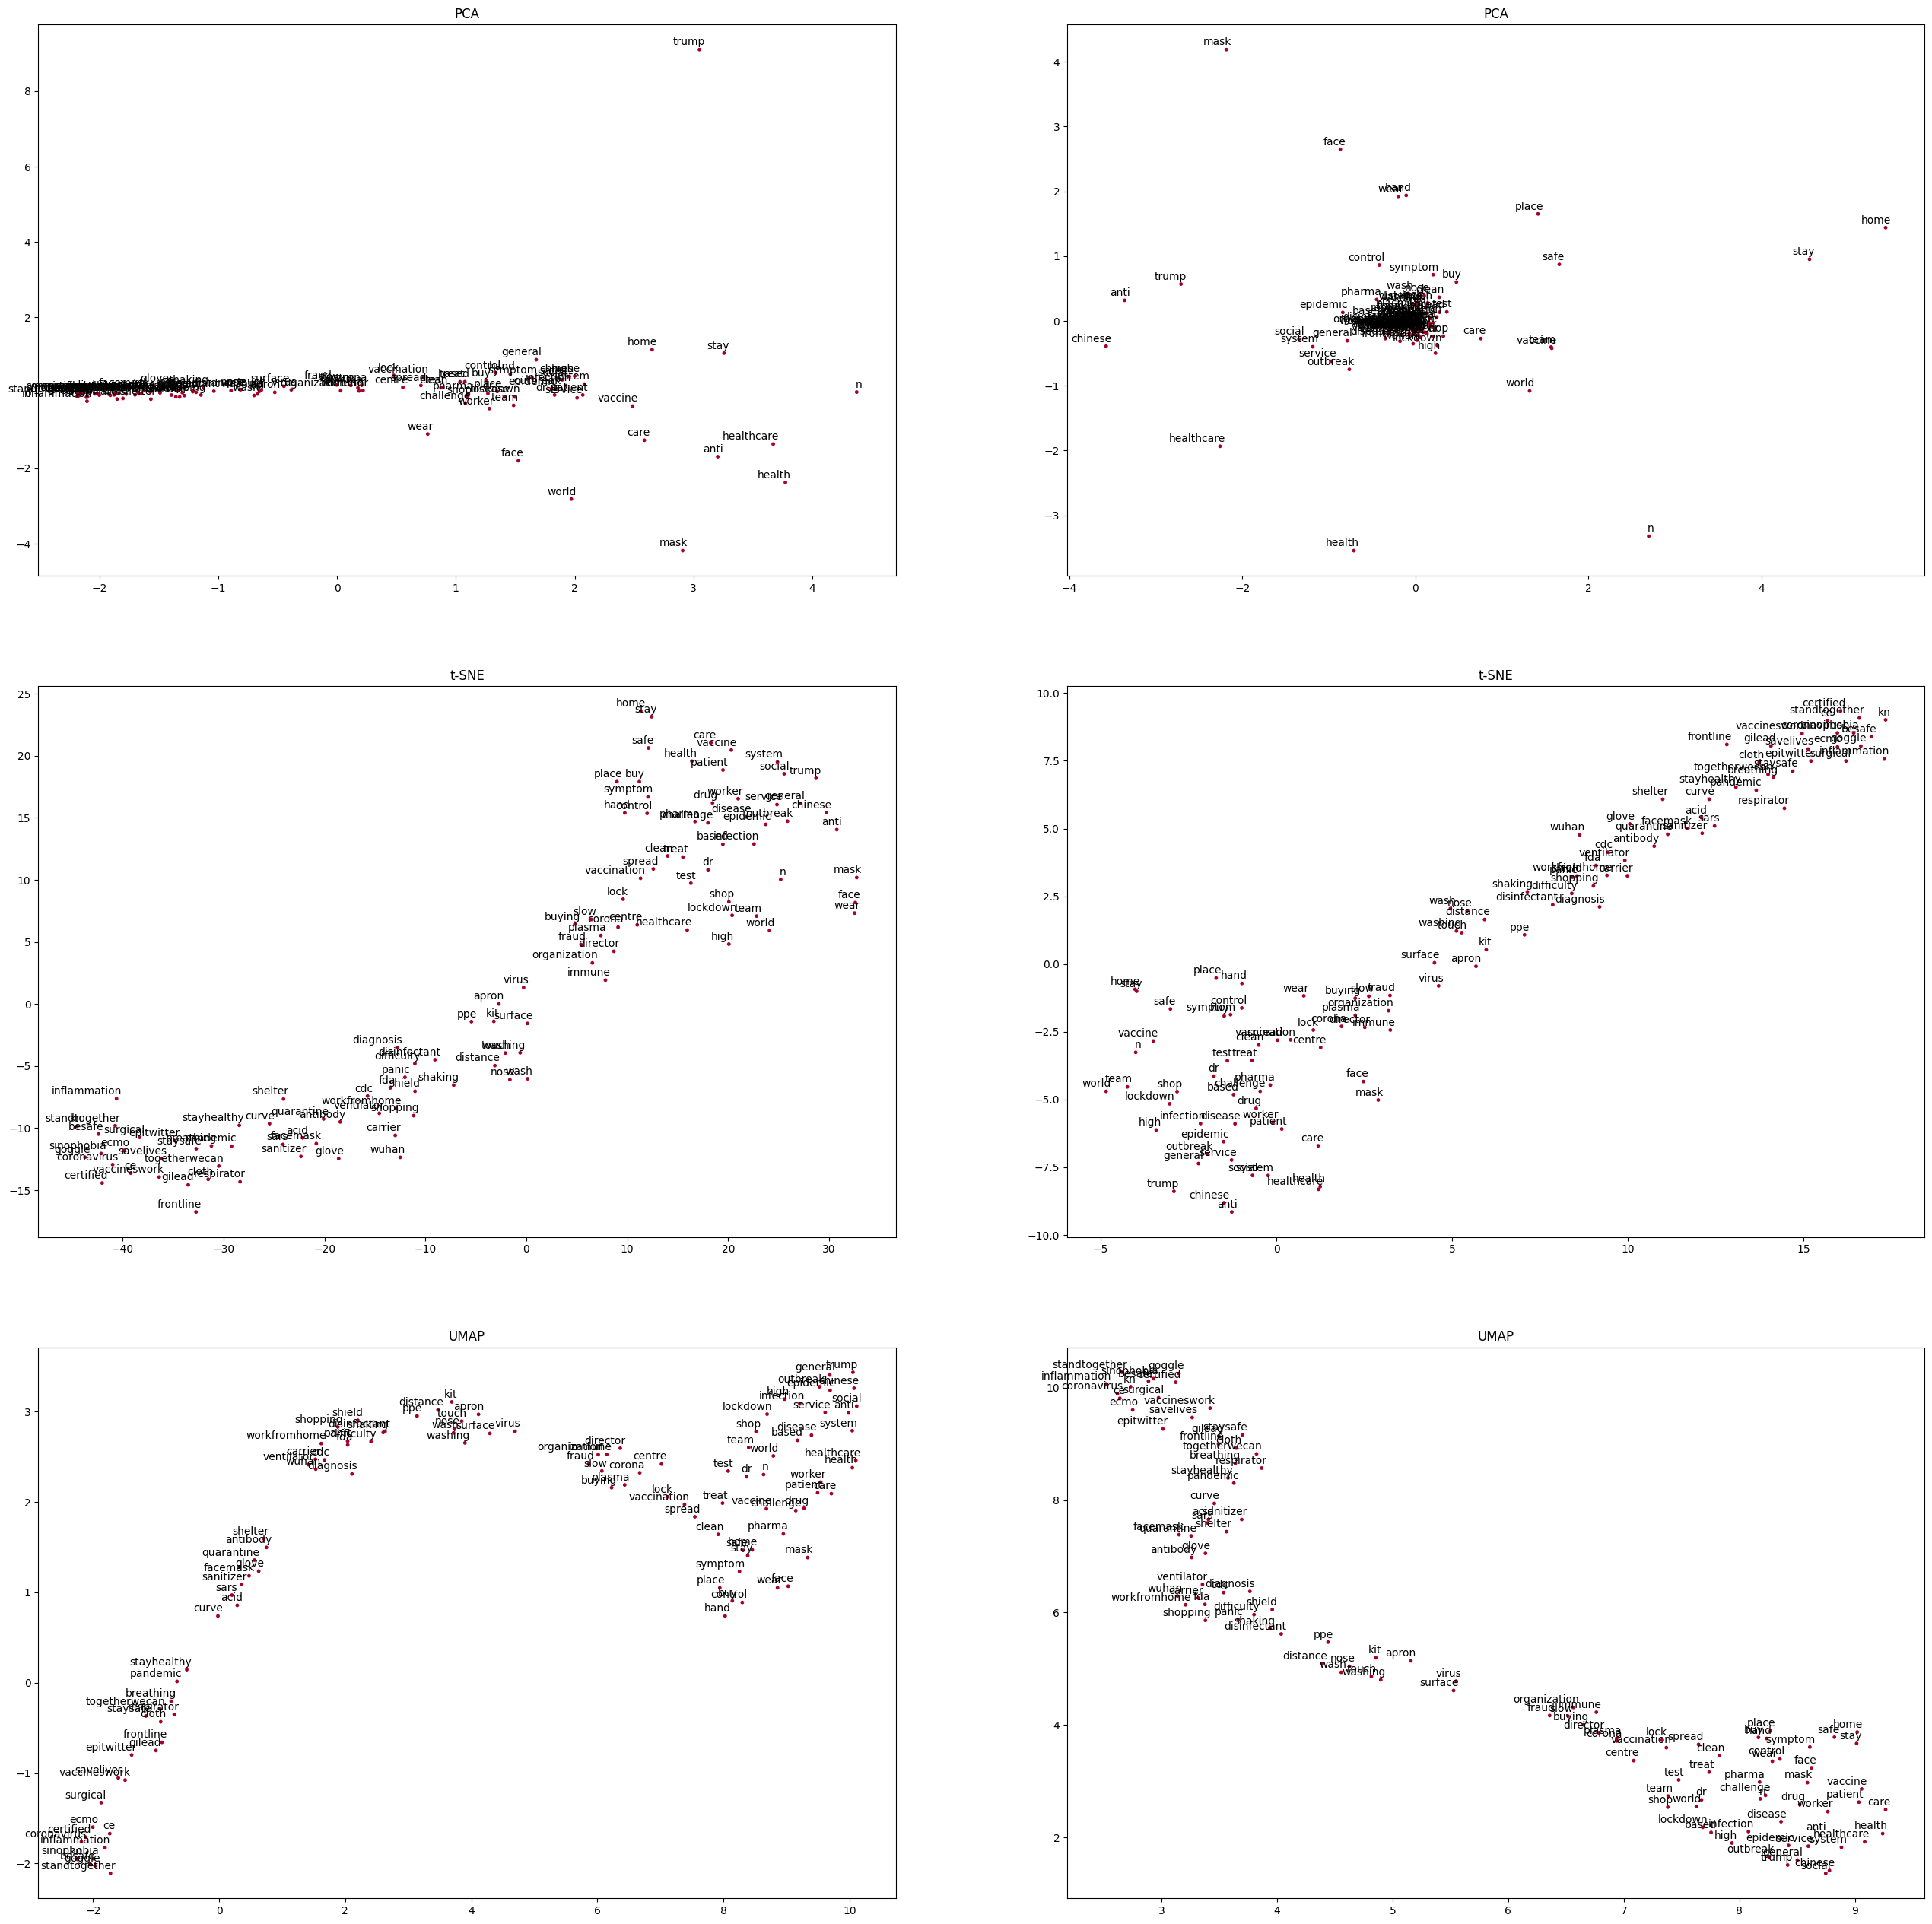

In [ ]:
plot_gensim(model_cbow, df_keywords, 'word_embedding/keywords_cbow.pdf')

0
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
1
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


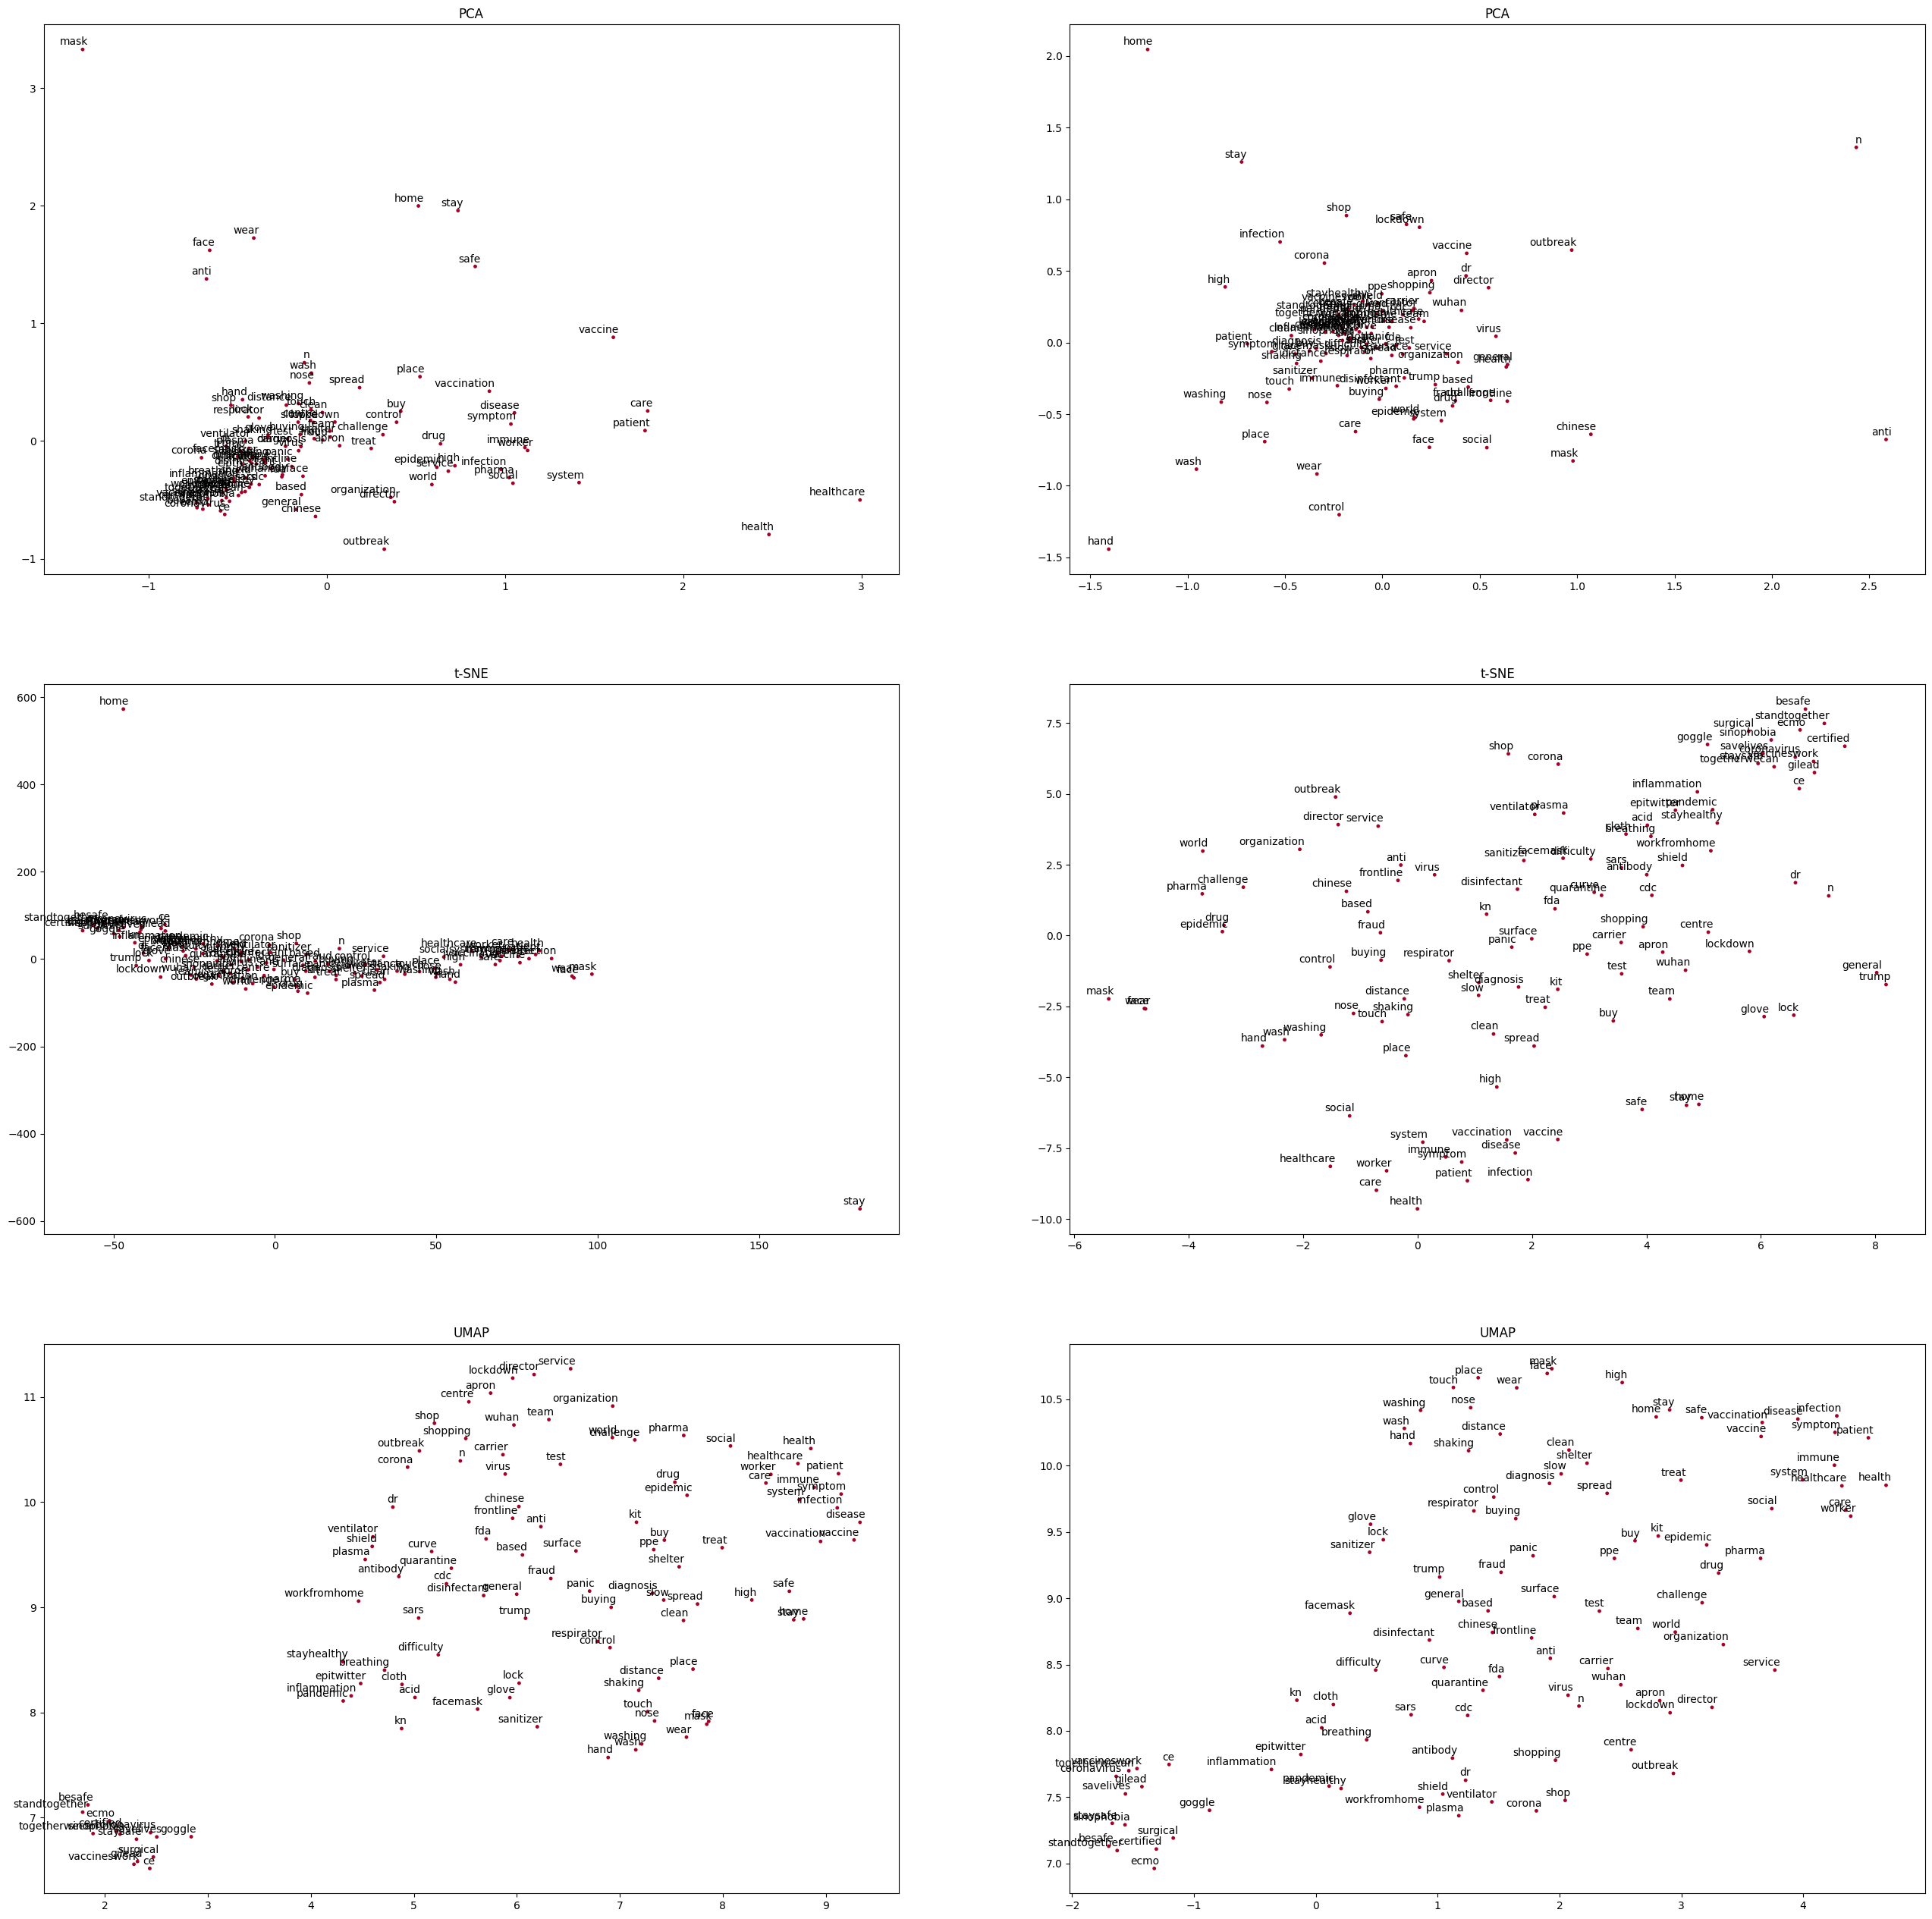

In [ ]:
plot_gensim(model_sgram, df_keywords, 'word_embedding/keywords_sgram.pdf')

0
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
1
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


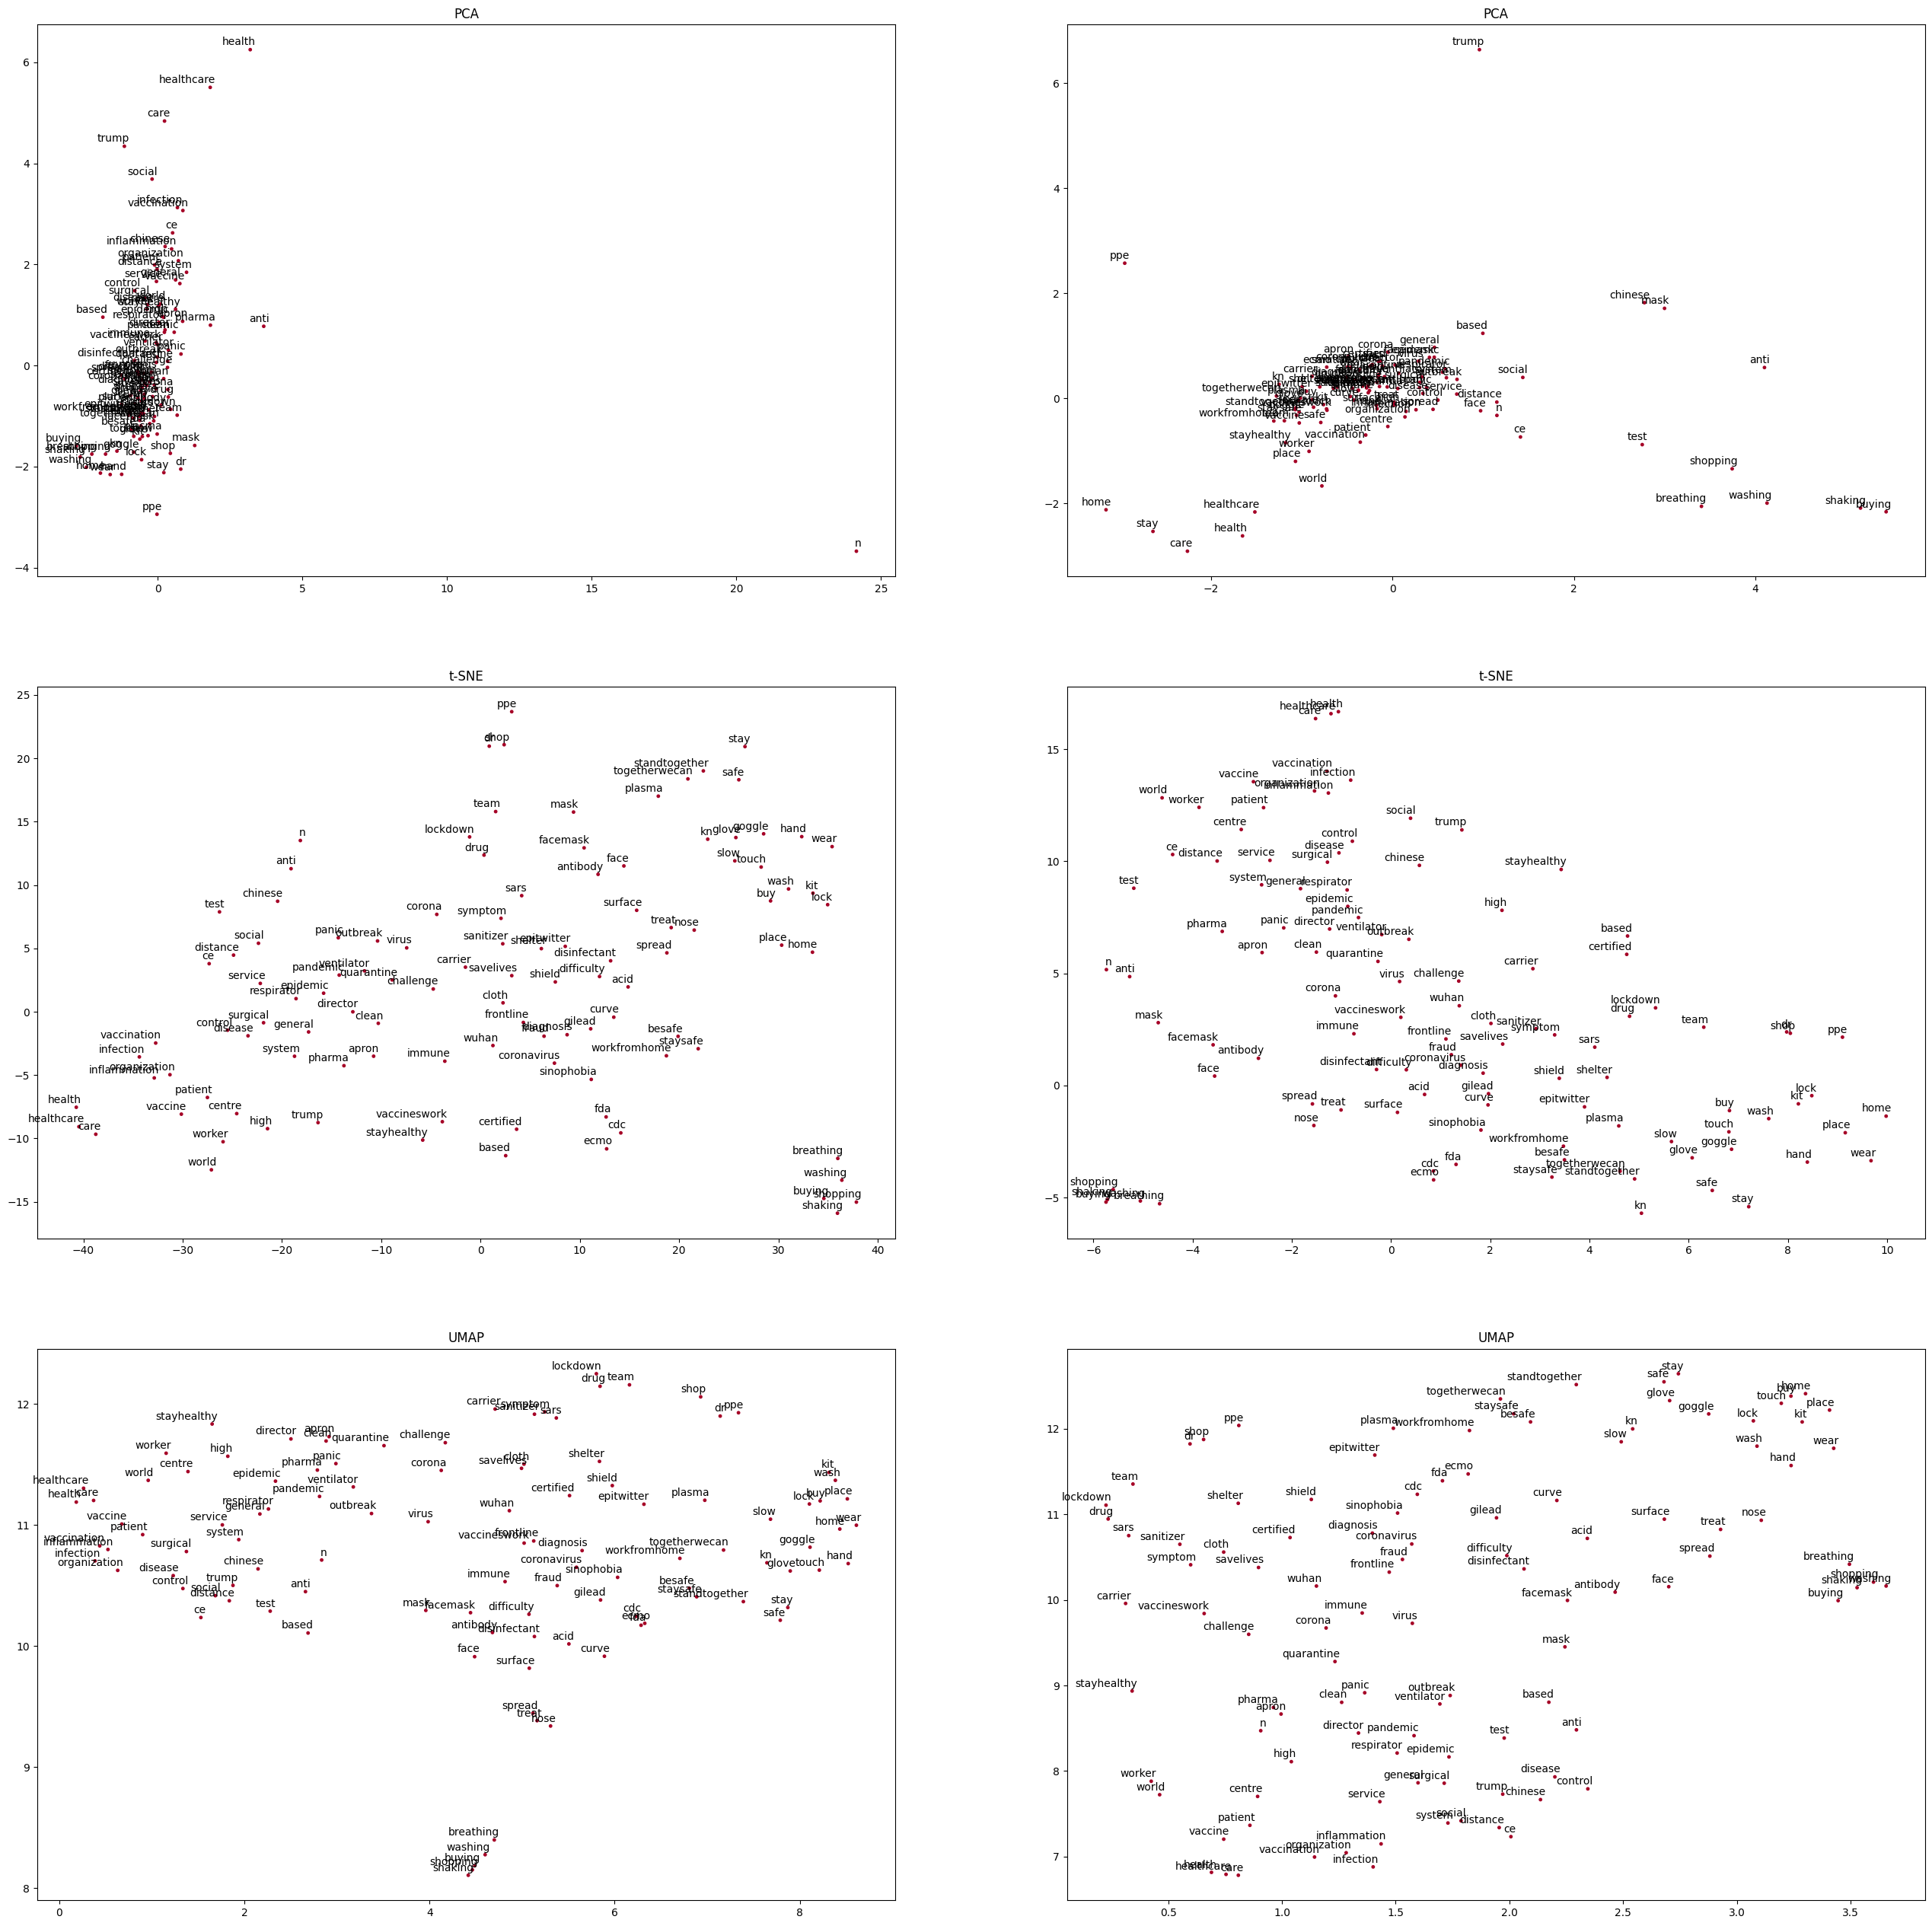

In [ ]:
plot_gensim(model_ft, df_keywords, 'word_embedding/keywords_ft.pdf')

0
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
1
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


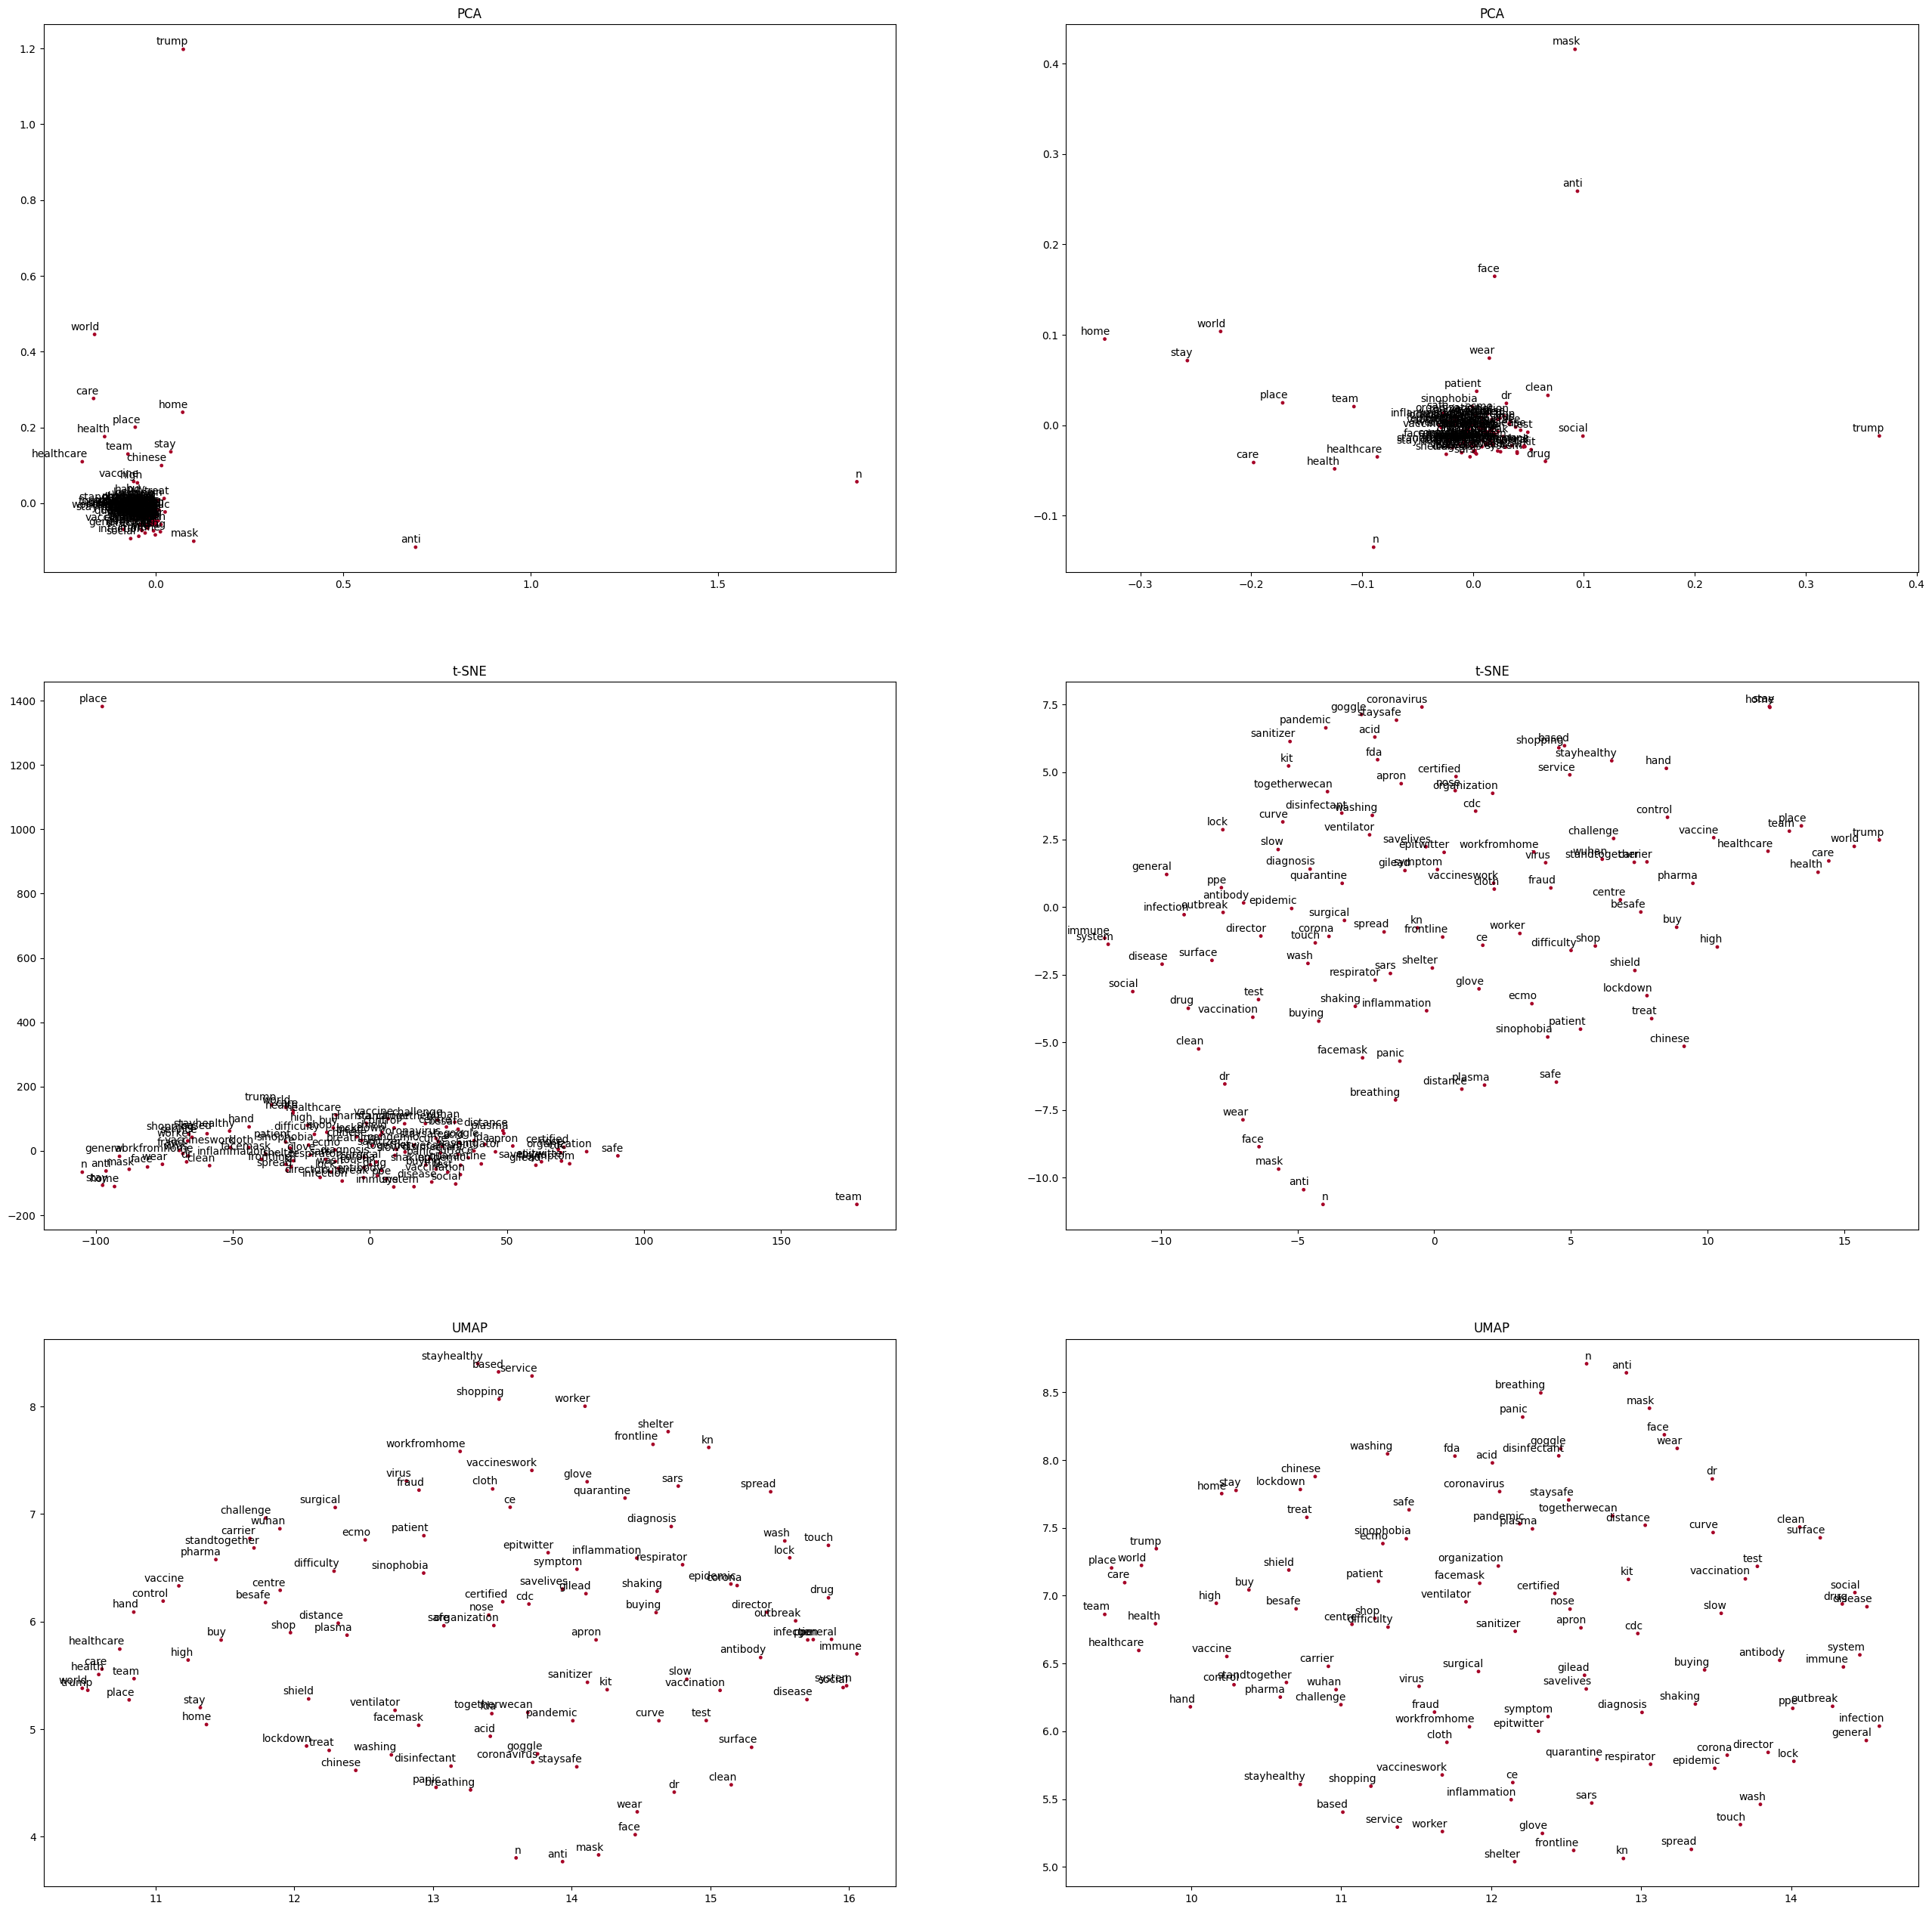

In [ ]:
plot_gensim(model_glove_gensim, df_keywords, 'word_embedding/keywords_glove.pdf', glove=True)

In [ ]:
from tqdm import tqdm
#tsne part inspired by https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook
def plot_sklearn(model, df, name, posneg=False, transformer=None):
    labels = []
    tokens_t = []
    sent_neg = []
    sent_pos = []
    
    if posneg:
        for index, row in tqdm(df.iterrows()):
            sntc = model.transform([" ".join(row['unigram'])])
            if transformer is not None:
                tokens_t.append(*transformer.transform(sntc).toarray())
            else:
                tokens_t.append(*sntc.toarray())
            sent_pos.append(-int(row['pos_sent']))
            sent_neg.append(-int(row['neg_sent']))
            #labels.append(row['TweetText'])
    else:
        for index, row in tqdm(df.iterrows()):
            sntc = model.transform([row['keyword']])
            if transformer is not None:
                tokens_t.append(*transformer.transform(sntc).toarray())
            else:
                tokens_t.append(*sntc.toarray())
            sent_pos.append(0)
            labels.append(row['keyword'])

    pca_model = PCA(n_components=8, random_state=42)
    new_values_pca = pca_model.fit_transform(np.asarray(tokens_t))
    
    fig, ax = plt.subplots(3, 2, figsize=(32,32))
    if posneg:
        tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_jobs=-1, verbose=0, random_state=42)
        new_values_tsne = tsne_model.fit_transform(np.asarray(tokens_t))
        trans = umap.UMAP(n_neighbors=5, random_state=42).fit(np.asarray(tokens_t))
        ax[0,1].scatter(new_values_tsne[:,0], new_values_tsne[:,1], c=sent_neg, cmap='RdYlGn', s=6)
        ax[0,0].scatter(new_values_tsne[:,0], new_values_tsne[:,1], c=sent_pos, cmap='RdYlGn', s=6)
        ax[0,0].title.set_text('t-SNE - positive sentiment')
        ax[0,1].title.set_text('t-SNE - negative sentiment')

        ax[1,1].scatter(new_values_pca[:,0], new_values_pca[:,1], c=sent_neg, cmap='RdYlGn', s=6)
        ax[1,0].scatter(new_values_pca[:,0], new_values_pca[:,1], c=sent_pos, cmap='RdYlGn', s=6)
        ax[1,0].title.set_text('PCA - positive sentiment')
        ax[1,1].title.set_text('PCA - negative sentiment')

        ax[2,1].scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=sent_neg, cmap='RdYlGn', s=6)
        ax[2,0].scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=sent_pos, cmap='RdYlGn', s=6)
        ax[2,0].title.set_text('UMAP - positive sentiment')
        ax[2,1].title.set_text('UMAP - negative sentiment')
    else:
        for k, (perpl, neighb) in enumerate([(10,10),(20,20)]):
            print(k)
            tsne_model = TSNE(perplexity=perpl, n_components=2, init='pca', n_jobs=-1, verbose=0, random_state=42)
            new_values_tsne = tsne_model.fit_transform(np.asarray(tokens_t))
            trans = umap.UMAP(n_neighbors=neighb, random_state=42).fit(np.asarray(tokens_t))

            ax[0,k].scatter(new_values_pca[:,2*k], new_values_pca[:,2*k+1], c=sent_pos, cmap='RdYlGn', s=6)
            ax[0,k].title.set_text('PCA')

            ax[1,k].scatter(new_values_tsne[:,0], new_values_tsne[:,1], c=sent_pos, cmap='RdYlGn', s=6)
            ax[1,k].title.set_text('t-SNE')

            ax[2,k].scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=sent_pos, cmap='RdYlGn', s=6)
            ax[2,k].title.set_text('UMAP')
            if not posneg:
                for i in range(len(labels)):
                    ax[0,k].annotate(labels[i],
                                    xy=(new_values_pca[i,2*k], new_values_pca[i,2*k+1]),
                                    xytext=(5, 2),
                                    textcoords='offset points',
                                    ha='right',
                                    va='bottom')

                    ax[1,k].annotate(labels[i],
                                    xy=(new_values_tsne[i,0],new_values_tsne[i,1]),
                                    xytext=(5, 2),
                                    textcoords='offset points',
                                    ha='right',
                                    va='bottom')

                    ax[2,k].annotate(labels[i],
                                    xy=(trans.embedding_[i, 0], trans.embedding_[i, 1]),
                                    xytext=(5, 2),
                                    textcoords='offset points',
                                    ha='right',
                                    va='bottom')
    plt.savefig(name)
    plt.show()

109it [00:00, 6912.09it/s]
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
0
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
1
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


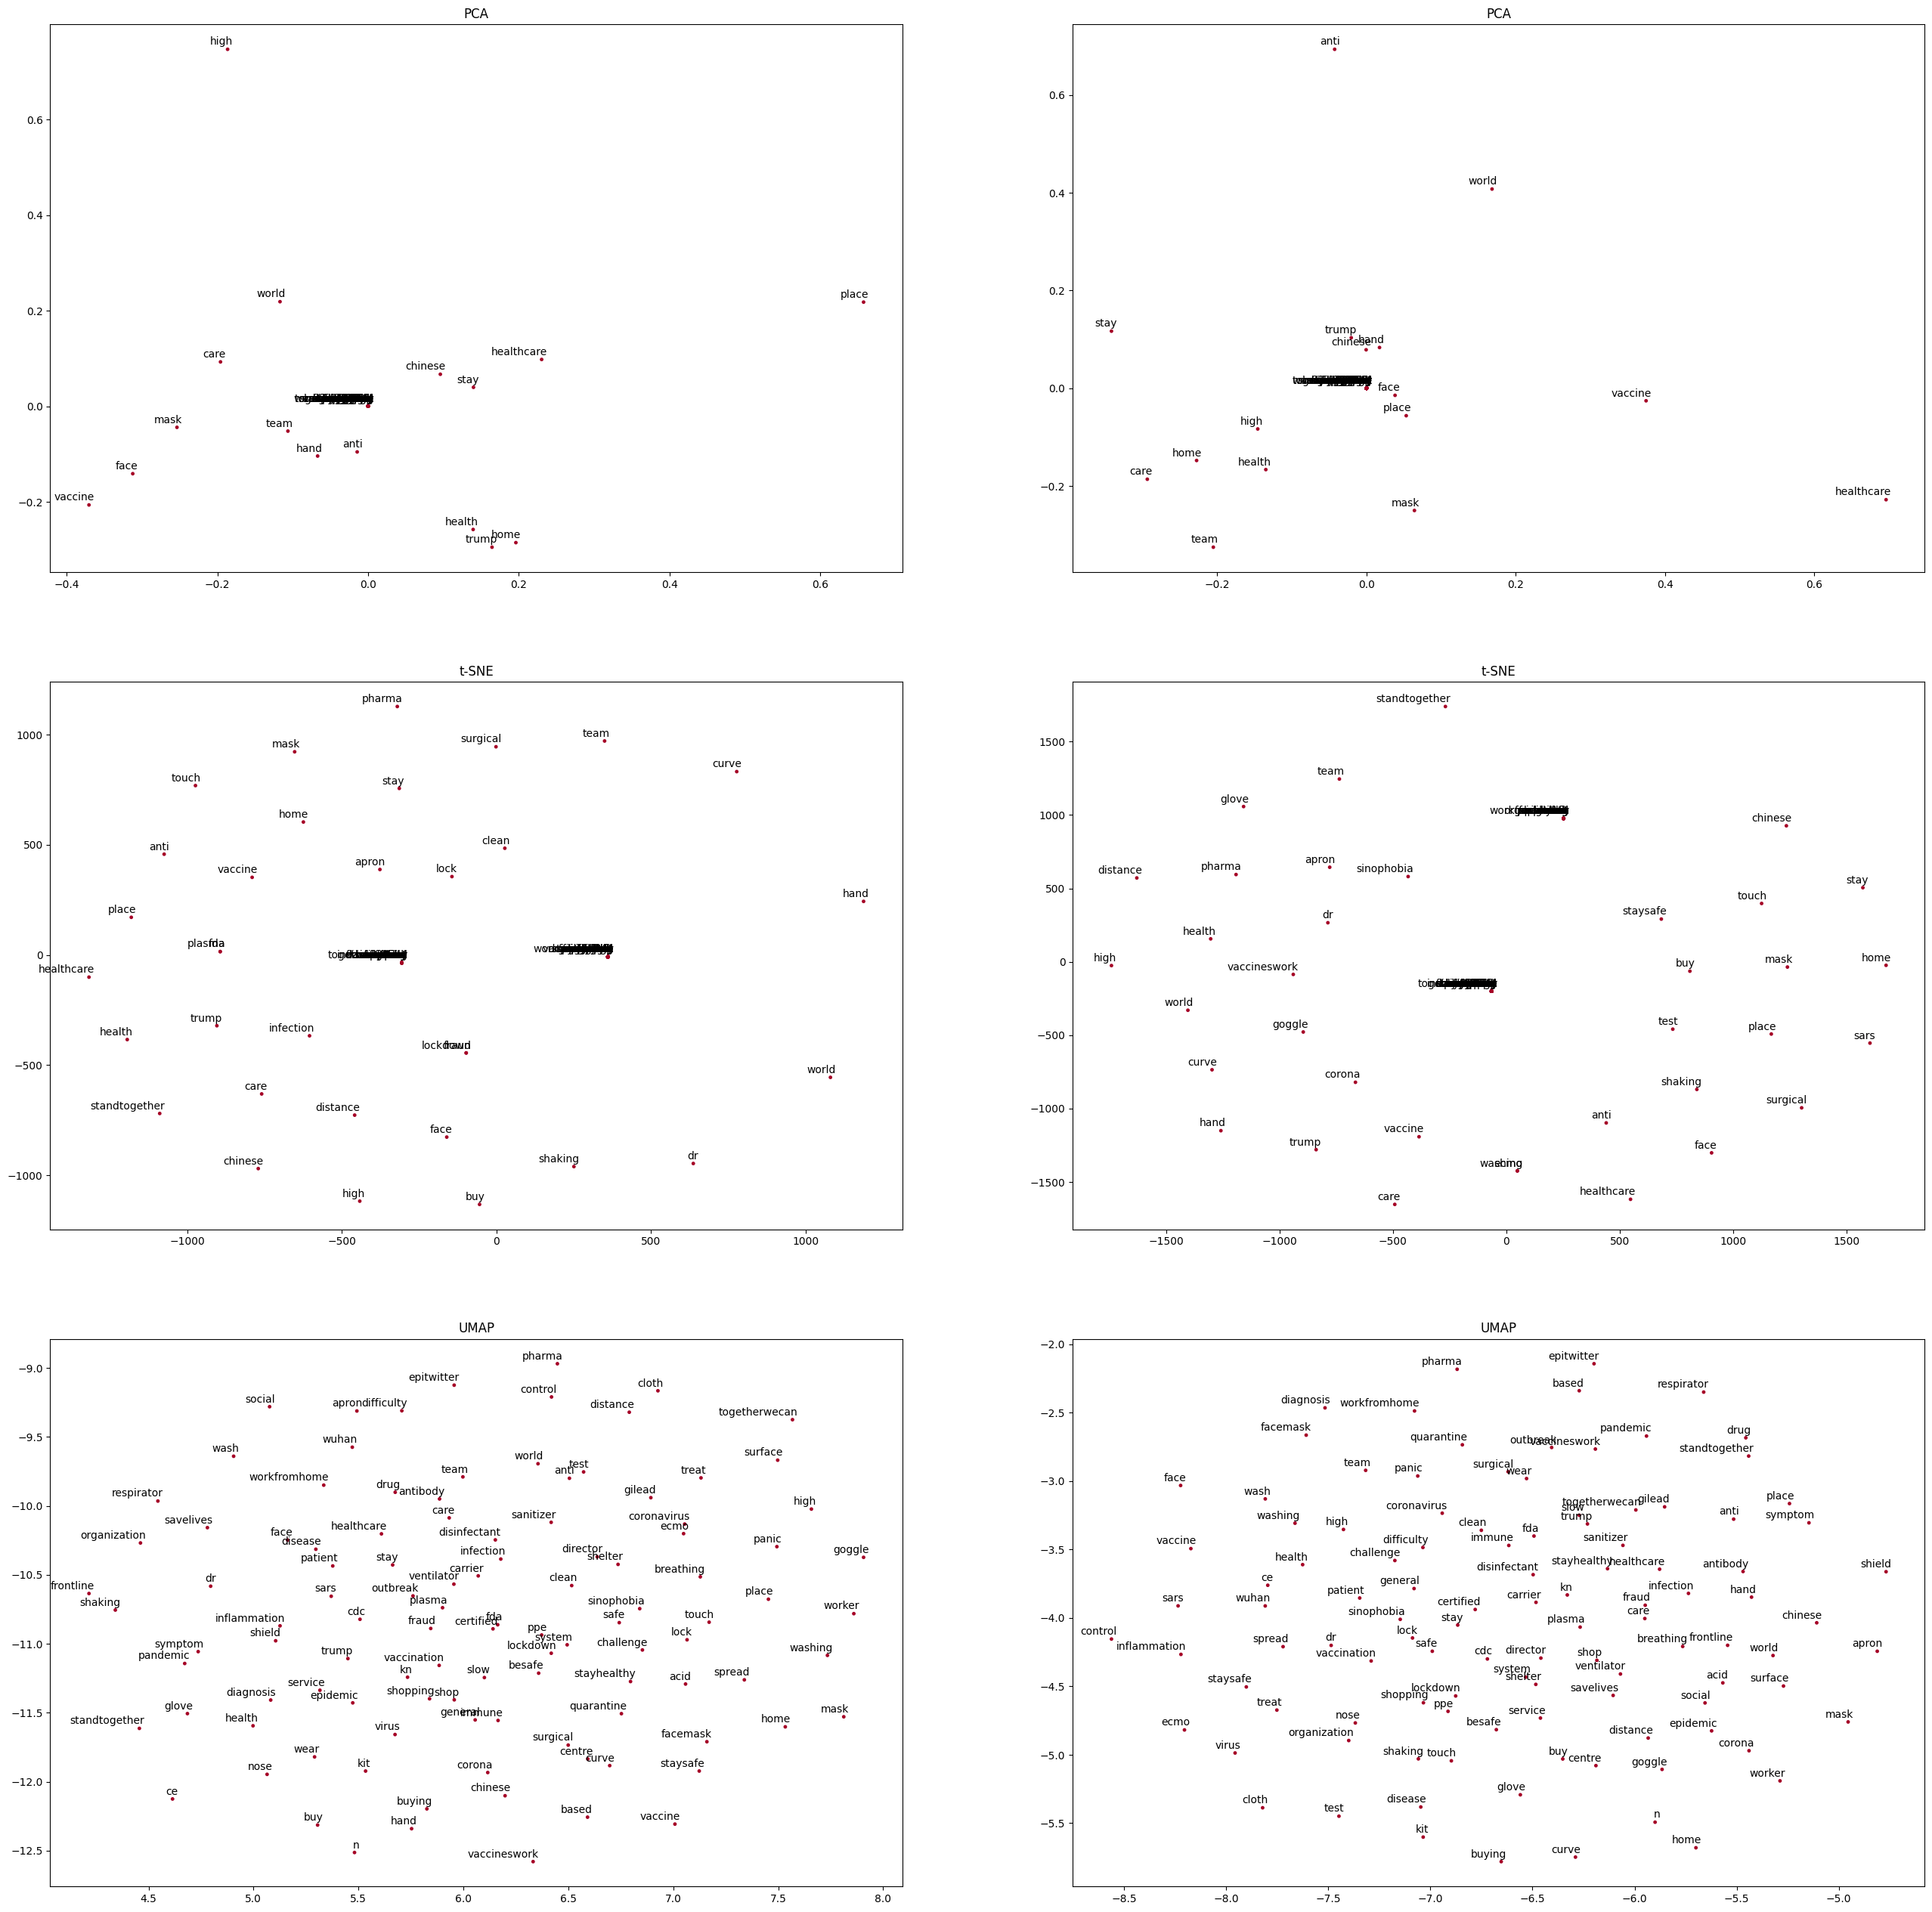

In [ ]:
plot_sklearn(vectorizer, df_keywords, 'word_embedding/keywords_bow.pdf')

109it [00:00, 1503.82it/s]
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
0
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
1
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


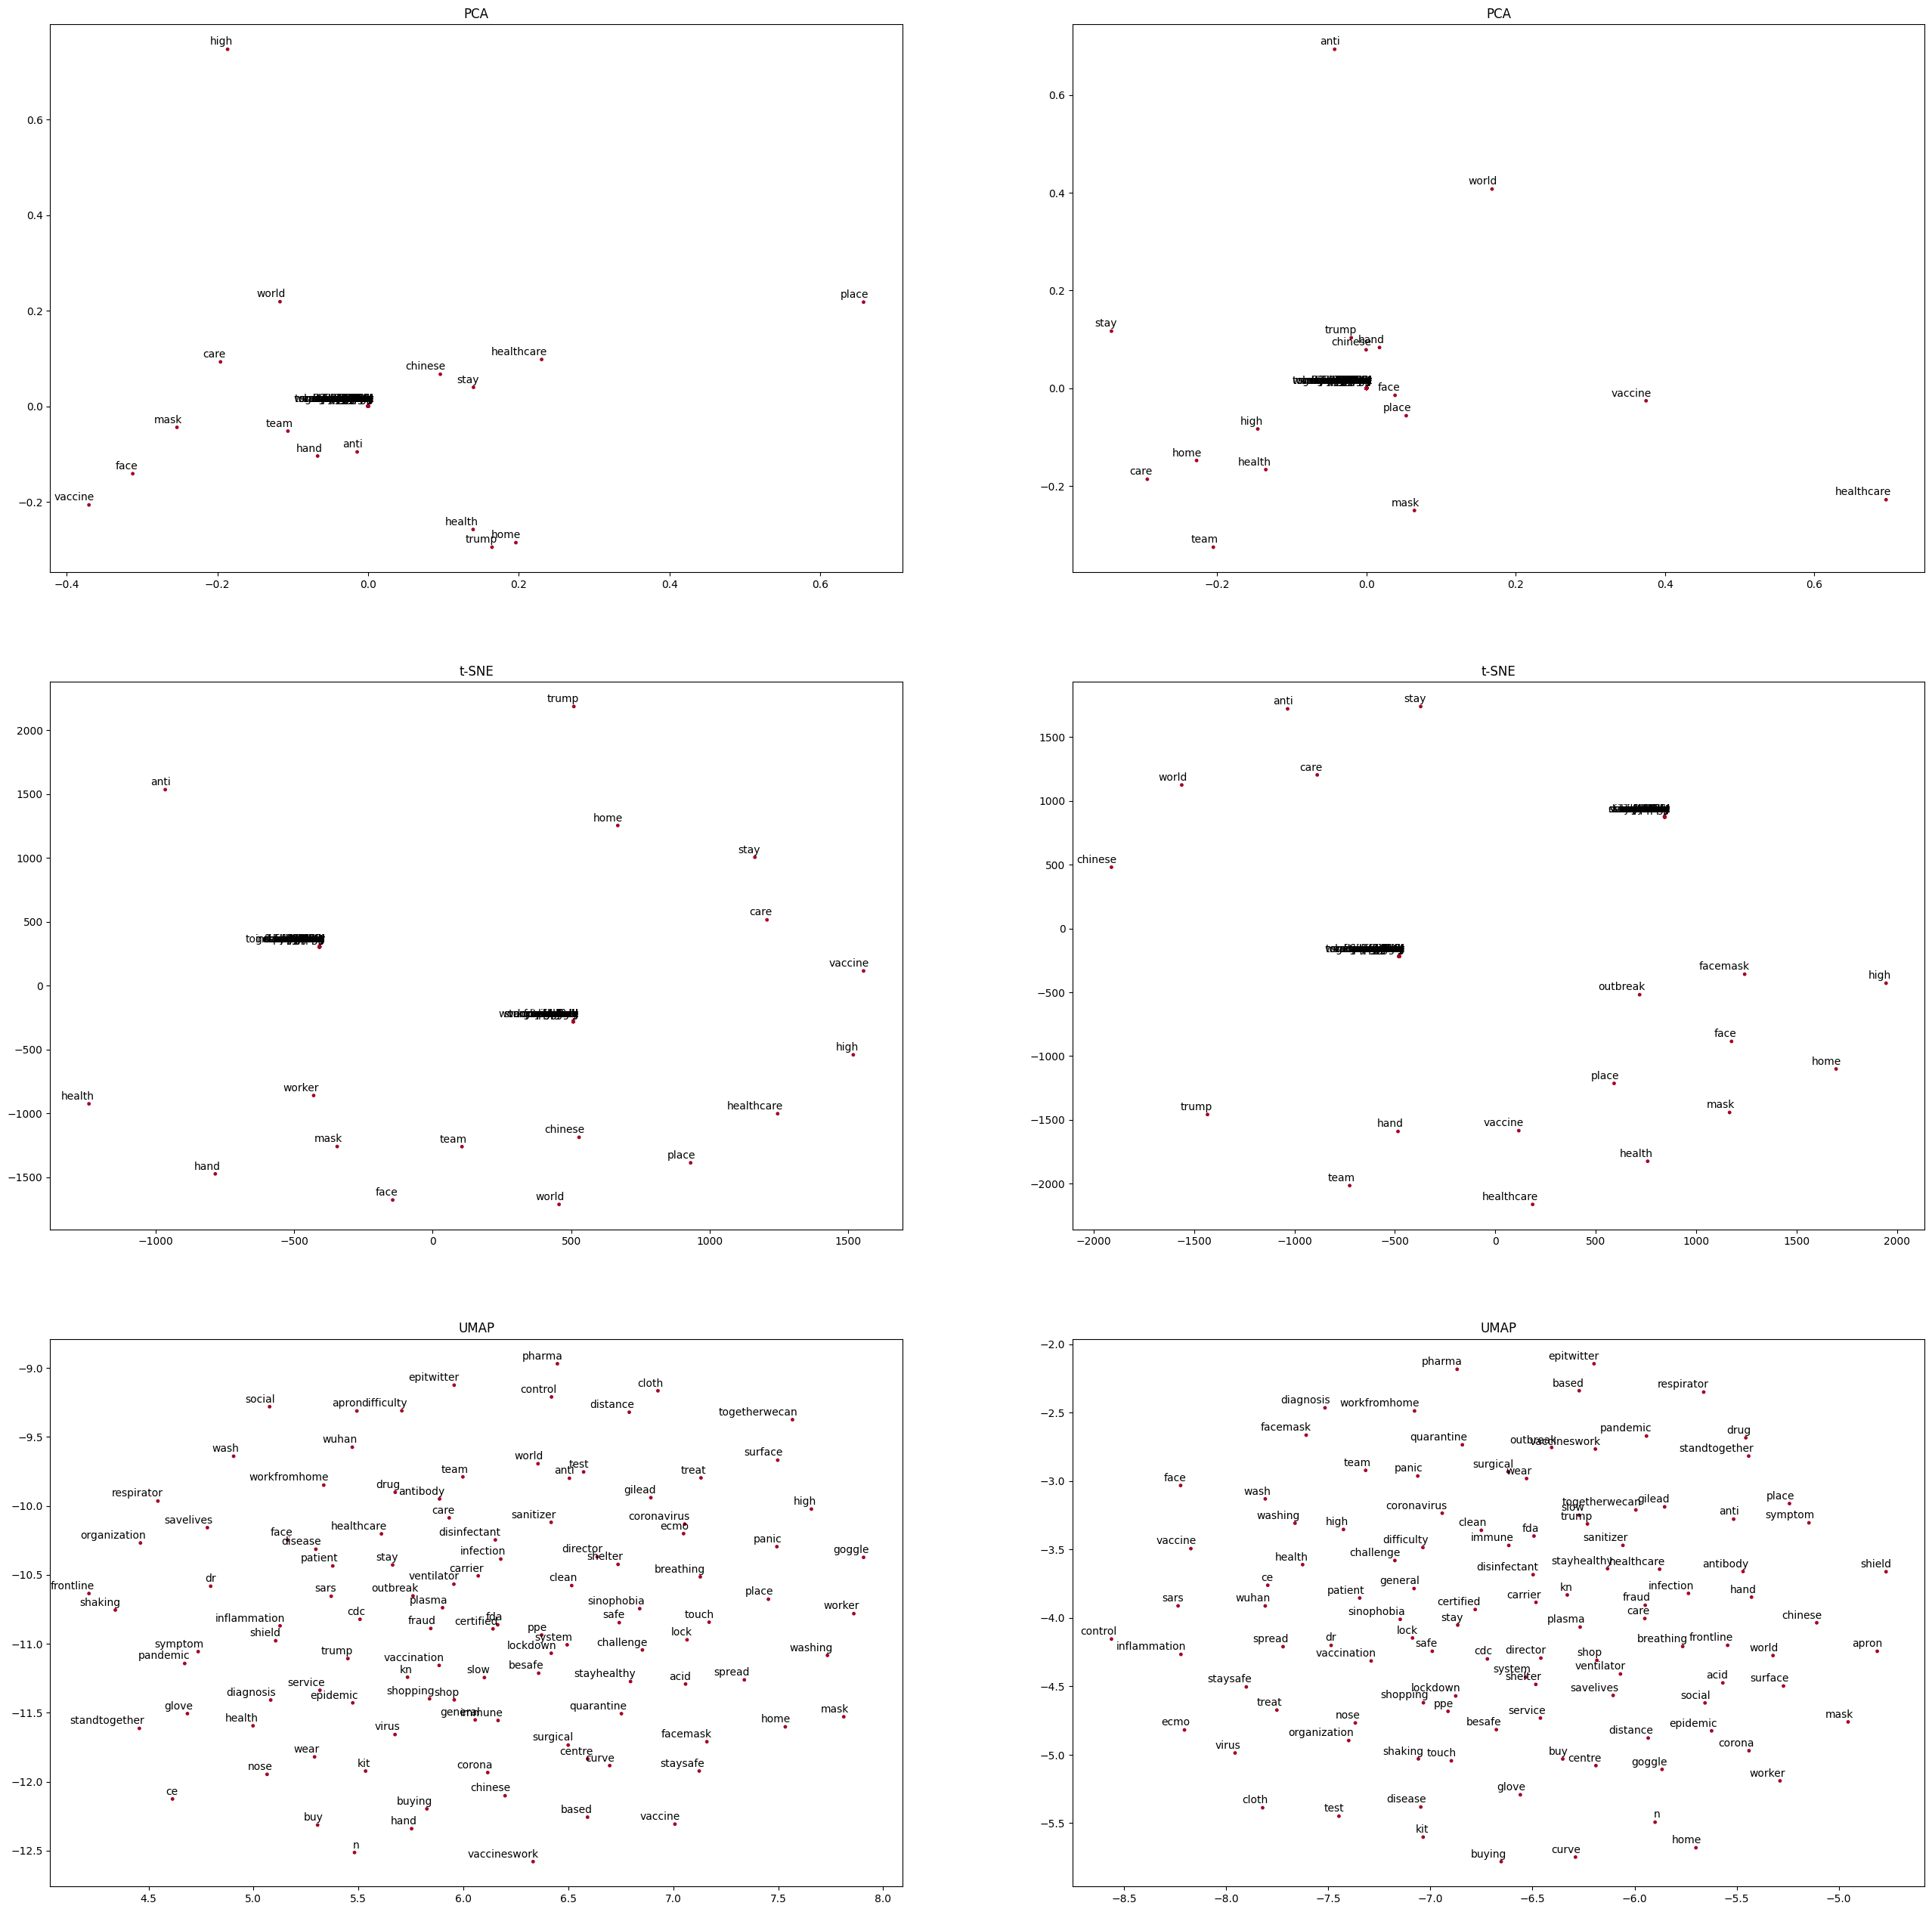

In [ ]:
plot_sklearn(vectorizer, df_keywords, 'word_embedding/keywords_tfidf.pdf', transformer=transformer)

### Q7: Tweet embeddings (2 pts)

Propose three different approaches to combine word embeddings into an embedding for each tweet. Provide a code snippet for each function. How do all of the above methods deal with out-of-vocabulary words?

https://stats.stackexchange.com/questions/286579/how-to-train-sentence-paragraph-document-embeddings

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

example_sentence = 'cool fun fan twitter fun'
example_sentence_oov = 'cool fun fan twitterz fun'

#1A. averaging word2vec - does not work with OOV words
sentence_w2v = np.zeros(vec_size)
sentence_w2v_oov = np.zeros(vec_size)

tokenized_ex = nltk.word_tokenize(example_sentence)
tokenized_ex_oov = nltk.word_tokenize(example_sentence_oov)
for word in tokenized_ex:
    sentence_w2v += model_cbow.wv[word]
red = 0
for word in tokenized_ex_oov:
    try:
        sentence_w2v_oov += model_cbow.wv[word]
    except:
        print('OOV word encountered:', word)
        red += 1
sentence_w2v = sentence_w2v/len(tokenized_ex)
sentence_w2v_oov = sentence_w2v_oov/(len(tokenized_ex)-red)

sentence_ft = np.zeros(vec_size)
sentence_ft_oov = np.zeros(vec_size)

#1B. averaging FastText - works with OOV words
for word in tokenized_ex:
    sentence_ft += model_ft.wv[word]
red = 0
for word in tokenized_ex_oov:
    try:
        sentence_ft_oov += model_ft.wv[word]
    except:
        print('OOV word encountered:', word)
        red += 1

sentence_ft = sentence_ft/(1+len(tokenized_ex))
sentence_ft_oov = sentence_ft_oov/(1+len(tokenized_ex)-red)

#3. minmax - kinda works with OOV words (simply ignores them)
sentence_min = np.ones(vec_size)*1000
sentence_max = np.ones(vec_size)*(-1000)
sentence_min_oov = np.ones(vec_size)*1000
sentence_max_oov = np.ones(vec_size)*(-1000)

for word in tokenized_ex:
    try:
        sentence_min = np.minimum(np.asarray(model_cbow.wv[word]), sentence_min)
        sentence_max = np.maximum(np.asarray(model_cbow.wv[word]), sentence_max)
    except:
        print('OOV word encountered:', word)
for word in tokenized_ex_oov:
    try:
        sentence_min_oov = np.minimum(np.asarray(model_cbow.wv[word]), sentence_min_oov)
        sentence_max_oov = np.maximum(np.asarray(model_cbow.wv[word]), sentence_max_oov)
    except:
        print('OOV word encountered:', word)

print('distance between w2v', *euclidean_distances([sentence_w2v], [sentence_w2v_oov]))
print('distance between ft (should be smaller than w2v if difference in words is small)', *euclidean_distances([sentence_ft], [sentence_ft_oov]))
print('distance between min', *euclidean_distances([sentence_min], [sentence_min_oov]))
print('distance between max', *euclidean_distances([sentence_max], [sentence_max_oov]))

OOV word encountered: twitterz
OOV word encountered: twitterz
distance between w2v [0.23694707]
distance between ft (should be smaller than w2v if difference in words is small) [0.26359771]
distance between min [0.48842714]
distance between max [0.37430094]


In [ ]:
#averaging + summing
def av_sentence(row, model, vec_size=vec_size, av=True):
    if row != []:
        red = 0
        sentence = 0
        for word in row:
            try:
                sentence += model.wv[word]
            except:
                red += 1
        if av:
            sentence = sentence/(1+len(row)-red)
        if red == len(row):
            return np.zeros(vec_size).tolist()
        else:
            return sentence.tolist()
    else:
        return np.zeros(vec_size).tolist()


def av_sentence_bow(row, vectorizer, transformer=None, av=True):
    sentence = vectorizer.transform([row])
    if transformer is not None:
        sentence = transformer.transform(sentence)
    sentence = sentence.toarray()[0]
    if av:
        sentence = sentence/(1+sentence.sum())
    return sentence.tolist()

In [ ]:
def minmax_sentence(row, model, vec_size=vec_size):
    sentence_min = np.ones(vec_size)*1000
    sentence_max = np.ones(vec_size)*(-1000)
    if row != []:
        red = 0
        for word in row:
            try:
                sentence_min = np.minimum(np.asarray(model.wv[word]), sentence_min[idx])
                sentence_max = np.maximum(np.asarray(model.wv[word]), sentence_max[idx])
            except:
                red += 1
        if red == len(row):
            sentence_min = np.ones(vec_size)*1000
            sentence_max = np.ones(vec_size)*(-1000)
    return np.concatenate((sentence_min, sentence_max), axis=0).tolist()

def minmax_sentence_bow(row, vectorizer, vocab_size, transformer=None):
    sentence_min = np.ones(vocab_size)
    sentence_max = np.zeros(vocab_size)
    
    if row != []:
        res = vectorizer.transform([row])
        if transformer is not None:
            res = transformer.transform(res)
        sentence_min = np.minimum(res.toarray()[0], sentence_min)
        sentence_max = np.maximum(res.toarray()[0], sentence_max)
    return np.concatenate((sentence_min, sentence_max), axis=0).tolist()

### Q8: Classifier (3 pts)

Implement three downstream classifiers to perform sentiment analysis of your tweets (i.e., predict both the positive (1 to 5) & negative (-1 to -5) sentiment score for each tweet). For each classifier, briefly explain how it works and make sure to tune hyper-parameters appropriately. Provide a results table showcasing the performance of all tested classifiers for each embeddings approach you implemented in Q1-5, and each aggregation method in Q7. For each family of classifiers tested provide a code snippet.

In [ ]:
y_train_val = y_train_val.apply(pd.to_numeric)
y_test = y_test.apply(pd.to_numeric)

X_train_val['sentences'] = X_train_val['unigram'].apply(" ".join)
X_test['sentences'] = X_test['unigram'].apply(" ".join)

In [ ]:
def class_preprocessing_bow(X, transformer):
    X['av_bow'] = X['sentences'].apply(av_sentence_bow, args=(vectorizer, None))
    X['av_tfidf'] = X['sentences'].apply(av_sentence_bow, args=(vectorizer, transformer))
    X['sum_bow'] = X['sentences'].apply(av_sentence_bow, args=(vectorizer, None, False))
    X['sum_tfidf'] = X['sentences'].apply(av_sentence_bow, args=(vectorizer, transformer, False))
    X['mm_bow'] = X['sentences'].apply(minmax_sentence_bow, args=(vectorizer, len(vectorizer.vocabulary_), None))
    X['mm_tfidf'] = X['sentences'].apply(minmax_sentence_bow, args=(vectorizer, len(vectorizer.vocabulary_), transformer))
    return X

def get_data_bow(X_train_val, X_test, transformer):
    X_train_val = class_preprocessing_bow(X_train_val, transformer)
    X_test = class_preprocessing_bow(X_test, transformer)
    return X_train_val, X_test


def class_preprocessing(model, s, X):
    X['av_'+s] = X['unigram'].apply(av_sentence, args=(model, vec_size))
    X['sum_'+s] = X['unigram'].apply(av_sentence, args=(model, vec_size, False))
    X['mm_'+s] = X['unigram'].apply(minmax_sentence, args=(model, vec_size))
    return X

def get_data(X_train_val, X_test, model, s):
    X_train_val = class_preprocessing(model, s, X_train_val)
    X_test = class_preprocessing(model, s, X_test)
    return X_train_val, X_test

In [ ]:
X_train_val, X_test = get_data(X_train_val, X_test, model_cbow, 'cbow')
X_train_val, X_test = get_data(X_train_val, X_test, model_ft, 'ft')
X_train_val, X_test = get_data(X_train_val, X_test, model_glove_gensim, 'glove')
X_train_val, X_test = get_data(X_train_val, X_test, model_sgram, 'sgram')
X_train_val, X_test = get_data_bow(X_train_val, X_test, transformer)
X_train_val

unigram  norm_engagement  \
numbers                                                                       
15252    [decision, refuse, appear, liaison, committee,...         0.002903   
5601     [hi, eu, server, join, raid, retail, alliance,...         0.000000   
18068    [hundred, answered, appeal, honour, forgotten,...         0.002065   
14228     [amp, toenail, got, weird, sh, happening, house]         0.000000   
10291    [cute, little, poppy, suggest, cute, name, cut...         0.000000   
...                                                    ...              ...   
6666     [corporation, politician, canada, bidding, com...         0.012784   
17342    [expected, never, get, old, show, youre, still...         0.000000   
6913     [aunty, gon, na, text, saying, come, san, mate...         0.000000   
1133                                       [whipped, stan]         0.000000   
9341     [symptom, leaky, gut, range, digestive, issue,...         0.000000   

                                                 sentences  \
numbers                                                      
15252    decision refuse appear liaison committee simpl...   
5601     hi eu server join raid retail alliance wow war...   
18068    hundred answered appeal honour forgotten raf v...   
14228             amp toenail got weird sh happening house   
10291    cute little poppy suggest cute name cute puppy...   
...                                                    ...   
6666     corporation politician canada bidding communis...   
17342    expected never get old show youre still naive ...   
6913     aunty gon na text saying come san mateo weeken...   
1133                                          whipped stan   
9341     symptom leaky gut range digestive issue skin p...   

                                                   av_cbow  \
numbers                                                      
15252    [-0.34286779165267944, 0.09779311716556549, 0....   
5601     [-0.3896200656890869, -0.07687325030565262, 0....   
18068    [-0.3821835219860077, -0.04061620309948921, 0....   
14228    [-0.9426820278167725, -0.01894151046872139, 0....   
10291    [-0.35482385754585266, 0.11677802354097366, 0....   
...                                                    ...   
6666     [-0.31496062874794006, -0.021672548726201057, ...   
17342    [-0.5961042642593384, 0.004281993955373764, 0....   
6913     [-0.6192370653152466, 0.3126097023487091, 0.31...   
1133     [-0.37788018584251404, 0.19104628264904022, -0...   
9341     [-0.38834092020988464, 0.029395459219813347, 0...   

                                                  sum_cbow  \
numbers                                                      
15252    [-6.857356071472168, 1.9558624029159546, 7.761...   
5601     [-5.454680919647217, -1.0762255191802979, 5.65...   
18068    [-3.0574681758880615, -0.3249296247959137, 2.5...   
14228    [-7.54145622253418, -0.15153208374977112, 1.26...   
10291    [-3.903062582015991, 1.2845582962036133, 1.320...   
...                                                    ...   
6666     [-3.779527425765991, -0.2600705921649933, 9.14...   
17342    [-11.922085762023926, 0.08563987910747528, 1.4...   
6913     [-11.14626693725586, 5.626974582672119, 5.6704...   
1133     [-1.1336405277252197, 0.5731388330459595, -0.0...   
9341     [-9.70852279663086, 0.7348864674568176, 13.353...   

                                                   mm_cbow  \
numbers                                                      
15252    [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
5601     [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
18068    [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
14228    [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
10291    [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
...                                                    ...   
6666     [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....   
17342    [1000.0, 1000.0, 1000.0, 1000.0, 10

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
def get_metrics(y_true, y_pred):
    y_pred_pos = np.clip(np.around(y_pred[:,0]), 1., 5.)
    y_pred_neg = np.clip(np.around(y_pred[:,1]), -5., -1.)
    #print('Classification report for positive sentiment')
    #print(classification_report(y_true[:,0], y_pred_pos))
    #print('Classification report for negative sentiment')
    #print(classification_report(y_true[:,1], y_pred_neg))

    f, axes = plt.subplots(1, 2, figsize=(6, 3))
    print('Confusion matrix for positive and negative sentiment:')
    cf_pos = confusion_matrix(y_true[:,0], y_pred_pos, labels=[1,2,3,4,5])
    disp_pos = ConfusionMatrixDisplay(confusion_matrix=cf_pos, display_labels=[1,2,3,4,5])
    disp_pos.plot(ax=axes[0])
    disp_pos.ax_.set_title('Positive Sentiment')
    disp_pos.im_.colorbar.remove()
    cf_neg = confusion_matrix(y_true[:,1], y_pred_neg, labels=[-5,-4,-3,-2,-1])
    disp_neg = ConfusionMatrixDisplay(confusion_matrix=cf_neg, display_labels=[-5,-4,-3,-2,-1])
    disp_neg.plot(ax=axes[1])
    disp_neg.ax_.set_title('Negative Sentiment')
    disp_neg.im_.colorbar.remove()
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    f.colorbar(disp_neg.im_, ax=axes)
    plt.show()
    plt.close()


In [ ]:
from sklearn.metrics import f1_score, make_scorer

def weighted_harmonic_f1_score(y_true, y_pred):
    y_pred_pos = np.clip(np.around(y_pred[:,0]), 1, 5).astype(int)
    y_pred_neg = np.clip(np.around(y_pred[:,1]), -5, -1).astype(int)
    f1_scores_pos = f1_score(y_true[:,0], y_pred_pos, average='weighted')
    f1_scores_neg = f1_score(y_true[:,1], y_pred_neg, average='weighted')
    weighted_f1 = (f1_scores_pos + f1_scores_neg)/2
    return weighted_f1

weighted_harmonic_f1_scorer = make_scorer(weighted_harmonic_f1_score)


In [ ]:
def print_results(est, sentence, sentence_test, elapsed_time, cl=False):
    train_score = weighted_harmonic_f1_score(np.asarray(y_train_val[['pos_sent', 'neg_sent']].values.tolist()),
                                             est.best_estimator_.predict(sentence))
    test_score = weighted_harmonic_f1_score(np.asarray(y_test[['pos_sent', 'neg_sent']].values.tolist()),
                                            est.best_estimator_.predict(sentence_test))
  
    print('----------------Results----------------')
    print("Elapsed time: {:.2f} seconds".format(elapsed_time))
    print("Best hyperparams:", est.best_params_)
    print("Train score (hm f1):", train_score)
    print("Test score (hm f1):", test_score)
    get_metrics(np.asarray(y_train_val[['pos_sent', 'neg_sent']].values.tolist()), est.best_estimator_.predict(sentence))
    return (train_score, test_score, elapsed_time)

CLASSIFIER 1: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor


import time

def euclidean_distance(estimator, X, y):
    y_pred_pos = np.clip(np.around(estimator.predict(X)[:,0]), 1., 5.)
    y_pred_neg = np.clip(np.around(estimator.predict(X)[:,1]), -5., -1.)
    y_pred = np.column_stack((y_pred_pos,y_pred_neg))
    return -euclidean_distances(y.reshape(-1, 1), y_pred.reshape(-1, 1)).mean()

def rand_forest(sentence, sentence_test):
    params = {'estimator__n_estimators':[5,15], #'estimator__max_features':['auto'],
              'estimator__n_jobs':[-1], 'estimator__random_state':[42],
              'estimator__criterion':['squared_error'], 'estimator__max_depth':[4,5],
              'estimator__verbose':[0]}
    regr = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=params,
                        n_jobs=-1, cv=2, scoring=weighted_harmonic_f1_scorer, verbose=0)
    start_time = time.time()
    regr.fit(sentence, np.asarray(y_train_val[['pos_sent', 'neg_sent']].values.tolist()))
    elapsed_time = time.time() - start_time

    test_score = print_results(regr, sentence, sentence_test, elapsed_time, cl=False)
    return test_score

<<<<<<<CBOW>>>>>>>
----------------Results----------------
Elapsed time: 4.08 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.3929217768439187
Test score (hm f1): 0.37741402072028685
Confusion matrix for positive and negative sentiment:


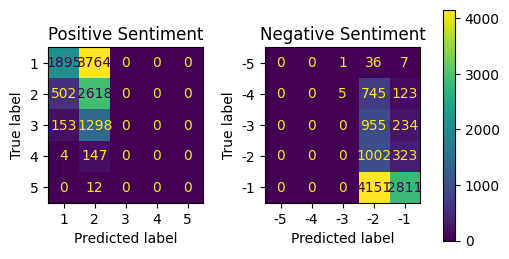

----------------Results----------------
Elapsed time: 4.05 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.43388508285990357
Test score (hm f1): 0.42043446035578474
Confusion matrix for positive and negative sentiment:


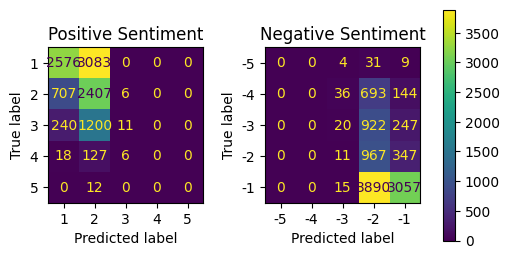

----------------Results----------------
Elapsed time: 0.28 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


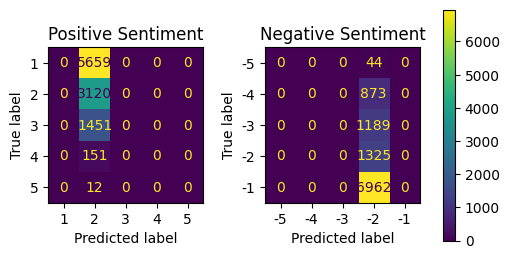

<<<<<<<SGRAM>>>>>>
----------------Results----------------
Elapsed time: 3.99 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.4164651833445742
Test score (hm f1): 0.40791097860350367
Confusion matrix for positive and negative sentiment:


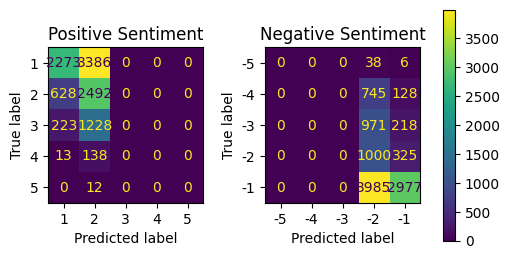

----------------Results----------------
Elapsed time: 4.09 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.45039781881530383
Test score (hm f1): 0.4431173194920198
Confusion matrix for positive and negative sentiment:


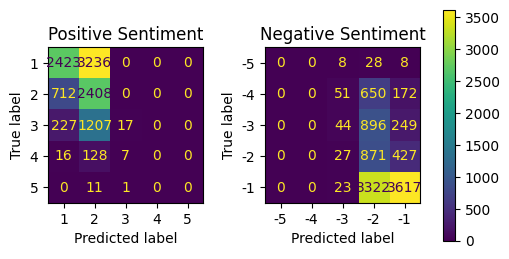

----------------Results----------------
Elapsed time: 0.27 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


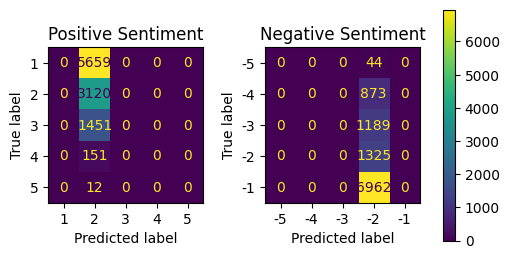

<<<<<<<FASTT>>>>>>
----------------Results----------------
Elapsed time: 4.08 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.3866836994199774
Test score (hm f1): 0.36823602085314994
Confusion matrix for positive and negative sentiment:


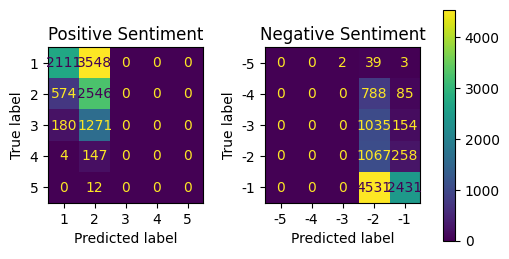

----------------Results----------------
Elapsed time: 4.07 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.40592286582379583
Test score (hm f1): 0.39359980271236084
Confusion matrix for positive and negative sentiment:


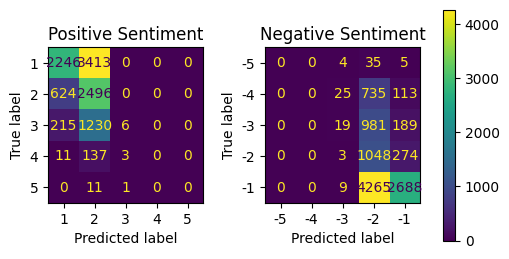

----------------Results----------------
Elapsed time: 0.27 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


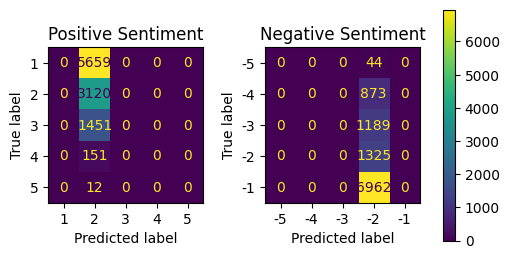

<<<<<<<GLOVE>>>>>>
----------------Results----------------
Elapsed time: 0.24 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


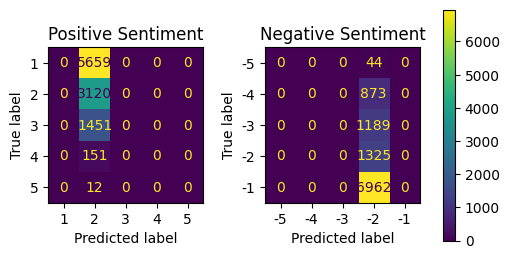

----------------Results----------------
Elapsed time: 0.24 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


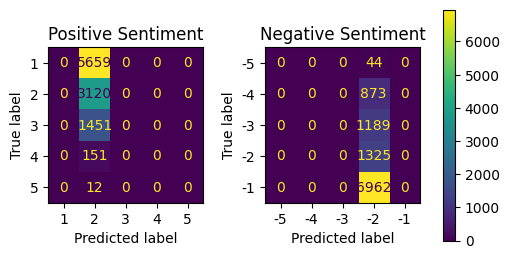

----------------Results----------------
Elapsed time: 0.25 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


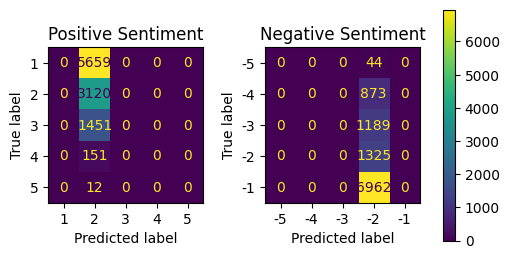

In [ ]:
test_score = np.zeros((3,18,3))
#CBOW av, sum, mm
print('<<<<<<<CBOW>>>>>>>')
test_score[0,0]=rand_forest(np.asarray(X_train_val['av_cbow'].tolist()), np.asarray(X_test['av_cbow'].tolist()))
test_score[0,1]=rand_forest(np.asarray(X_train_val['sum_cbow'].tolist()), np.asarray(X_test['sum_cbow'].tolist()))
test_score[0,2]=rand_forest(np.asarray(X_train_val['mm_cbow'].tolist()), np.asarray(X_test['mm_cbow'].tolist()))

#SGRAM av, sum, mm
print('<<<<<<<SGRAM>>>>>>')
test_score[0,3]=rand_forest(np.asarray(X_train_val['av_sgram'].tolist()), np.asarray(X_test['av_sgram'].tolist()))
test_score[0,4]=rand_forest(np.asarray(X_train_val['sum_sgram'].tolist()), np.asarray(X_test['sum_sgram'].tolist()))
test_score[0,5]=rand_forest(np.asarray(X_train_val['mm_sgram'].tolist()), np.asarray(X_test['mm_sgram'].tolist()))

#FT av, sum, mm
print('<<<<<<<FASTT>>>>>>')
test_score[0,6]=rand_forest(np.asarray(X_train_val['av_ft'].tolist()), np.asarray(X_test['av_ft'].tolist()))
test_score[0,7]=rand_forest(np.asarray(X_train_val['sum_ft'].tolist()), np.asarray(X_test['sum_ft'].tolist()))
test_score[0,8]=rand_forest(np.asarray(X_train_val['mm_ft'].tolist()), np.asarray(X_test['mm_ft'].tolist()))

#glove av, sum, mm
print('<<<<<<<GLOVE>>>>>>')
test_score[0,9]=rand_forest(np.asarray(X_train_val['av_glove'].tolist()), np.asarray(X_test['av_glove'].tolist()))
test_score[0,10]=rand_forest(np.asarray(X_train_val['sum_glove'].tolist()), np.asarray(X_test['sum_glove'].tolist()))
test_score[0,11]=rand_forest(np.asarray(X_train_val['mm_glove'].tolist()), np.asarray(X_test['mm_glove'].tolist()))

<<<<<<<BOW>>>>>>>>
----------------Results----------------
Elapsed time: 3.45 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 15, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.1172067789171044
Test score (hm f1): 0.1177604342265243
Confusion matrix for positive and negative sentiment:


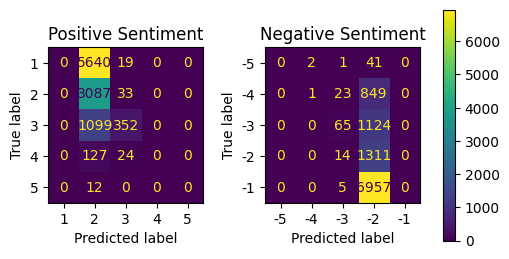

----------------Results----------------
Elapsed time: 2.49 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.11813687648753404
Test score (hm f1): 0.11840448526192619
Confusion matrix for positive and negative sentiment:


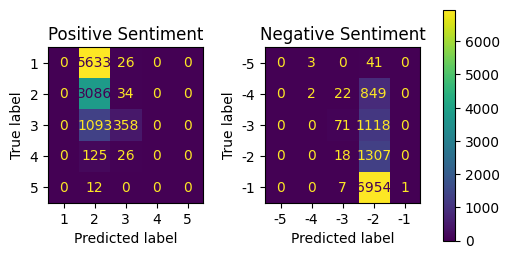

----------------Results----------------
Elapsed time: 5.64 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.11812845963373853
Test score (hm f1): 0.11824105625060462
Confusion matrix for positive and negative sentiment:


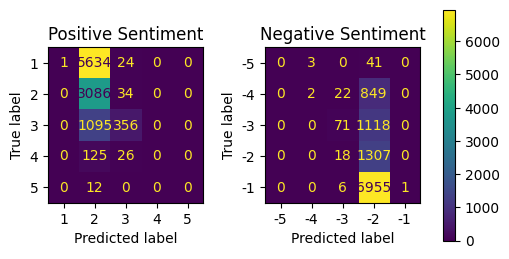

<<<<<<<TFIDF>>>>>>
----------------Results----------------
Elapsed time: 3.09 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.11773076868857439
Test score (hm f1): 0.11652862910603337
Confusion matrix for positive and negative sentiment:


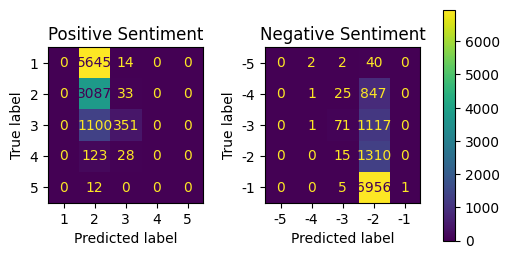

----------------Results----------------
Elapsed time: 3.53 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 15, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.11733039944874704
Test score (hm f1): 0.11792353567630949
Confusion matrix for positive and negative sentiment:


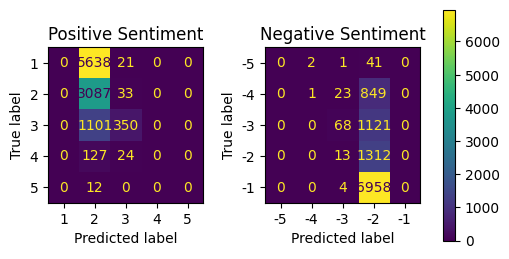

----------------Results----------------
Elapsed time: 6.22 seconds
Best hyperparams: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_jobs': -1, 'estimator__random_state': 42, 'estimator__verbose': 0}
Train score (hm f1): 0.117947967295808
Test score (hm f1): 0.11784750092620774
Confusion matrix for positive and negative sentiment:


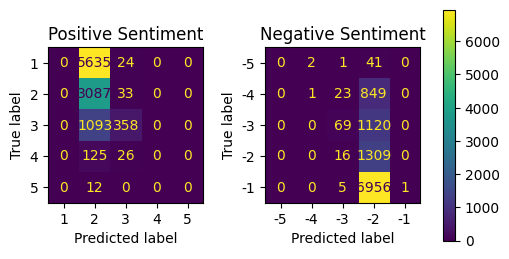

In [ ]:
#BOW av, sum, mm
print('<<<<<<<BOW>>>>>>>>')
test_score[0,12]=rand_forest(np.asarray(X_train_val['av_bow'].tolist()), np.asarray(X_test['av_bow'].tolist()))
test_score[0,13]=rand_forest(np.asarray(X_train_val['sum_bow'].tolist()), np.asarray(X_test['sum_bow'].tolist()))
test_score[0,14]=rand_forest(np.asarray(X_train_val['mm_bow'].tolist()), np.asarray(X_test['mm_bow'].tolist()))

#TFIDF av, sum, mm
print('<<<<<<<TFIDF>>>>>>')
test_score[0,15]=rand_forest(np.asarray(X_train_val['av_tfidf'].tolist()), np.asarray(X_test['av_tfidf'].tolist()))
test_score[0,16]=rand_forest(np.asarray(X_train_val['sum_tfidf'].tolist()), np.asarray(X_test['sum_tfidf'].tolist()))
test_score[0,17]=rand_forest(np.asarray(X_train_val['mm_tfidf'].tolist()), np.asarray(X_test['mm_tfidf'].tolist()))

CLASSIFIER 2: SVM (SVC/SVR)

In [ ]:
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import scale

#only use linear kernel + scale data to speed up training
def svm_reg(sentence, sentence_test):
    params = {'estimator__C': [1, 10], 'estimator__kernel':['linear']} #, 'rbf']}
              #, 'estimator__epsilon': [0.1]}
    regr = GridSearchCV(MultiOutputRegressor(SVR()), param_grid=params, n_jobs=-1, cv=2,
                        scoring=weighted_harmonic_f1_scorer, verbose=0)
    start_time = time.time()
    sentence_scaled = scale(sentence)
    regr.fit(sentence_scaled, np.asarray(y_train_val[['pos_sent', 'neg_sent']].values.tolist()))
    elapsed_time = time.time() - start_time
    
    sentence_test_scaled = scale(sentence_test)
    test_score = print_results(regr, sentence_scaled, sentence_test_scaled, elapsed_time, cl=False)
    return test_score


In [ ]:
#CBOW av, sum, mm
print('<<<<<<<CBOW>>>>>>>')
#svm_reg(np.asarray(X_train_val['av_cbow'].tolist()), np.asarray(X_test['av_cbow'].tolist()))
#svm_reg(np.asarray(X_train_val['sum_cbow'].tolist()), np.asarray(X_test['sum_cbow'].tolist()))
#svm_reg(np.asarray(X_train_val['mm_cbow'].tolist()), np.asarray(X_test['mm_cbow'].tolist()))

#SGRAM av, sum, mm
print('<<<<<<<SGRAM>>>>>>')
#svm_reg(np.asarray(X_train_val['av_sgram'].tolist()), np.asarray(X_test['av_sgram'].tolist()))
#svm_reg(np.asarray(X_train_val['sum_sgram'].tolist()), np.asarray(X_test['sum_sgram'].tolist()))
#svm_reg(np.asarray(X_train_val['mm_sgram'].tolist()), np.asarray(X_test['mm_sgram'].tolist()))

#FT av, sum, mm
print('<<<<<<<FASTT>>>>>>')
#svm_reg(np.asarray(X_train_val['av_ft'].tolist()), np.asarray(X_test['av_ft'].tolist()))
#svm_reg(np.asarray(X_train_val['sum_ft'].tolist()), np.asarray(X_test['sum_ft'].tolist()))
#svm_reg(np.asarray(X_train_val['mm_ft'].tolist()), np.asarray(X_test['mm_ft'].tolist()))

#glove av, sum, mm
print('<<<<<<<GLOVE>>>>>>')
#svm_reg(np.asarray(X_train_val['av_glove'].tolist()), np.asarray(X_test['av_glove'].tolist()))
#svm_reg(np.asarray(X_train_val['sum_glove'].tolist()), np.asarray(X_test['sum_glove'].tolist()))
#svm_reg(np.asarray(X_train_val['mm_glove'].tolist()), np.asarray(X_test['mm_glove'].tolist()))

<<<<<<<CBOW>>>>>>>
<<<<<<<SGRAM>>>>>>
<<<<<<<FASTT>>>>>>
<<<<<<<GLOVE>>>>>>


In [ ]:
#BOW av, sum, mm
print('<<<<<<<BOW>>>>>>>>')
#svm_reg(np.asarray(X_train_val['av_bow'].tolist()), np.asarray(X_test['av_bow'].tolist()))
#svm_reg(np.asarray(X_train_val['sum_bow'].tolist()), np.asarray(X_test['sum_bow'].tolist()))
#svm_reg(np.asarray(X_train_val['mm_bow'].tolist()), np.asarray(X_test['mm_bow'].tolist()))

#TFIDF av, sum, mm
print('<<<<<<<TFIDF>>>>>>')
#svm_reg(np.asarray(X_train_val['av_tfidf'].tolist()), np.asarray(X_test['av_tfidf'].tolist()))
#svm_reg(np.asarray(X_train_val['sum_tfidf'].tolist()), np.asarray(X_test['sum_tfidf'].tolist()))
#svm_reg(np.asarray(X_train_val['mm_tfidf'].tolist()), np.asarray(X_test['mm_tfidf'].tolist()))

<<<<<<<BOW>>>>>>>>
<<<<<<<TFIDF>>>>>>


CLASSIFIER 3: GradBoost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
    
def grad_reg(sentence, sentence_test):
    params = {'estimator__learning_rate': [0.1, 1], 'estimator__n_estimators': [5, 15],
              'estimator__max_depth': [4, 5], 'estimator__n_iter_no_change':[7]}
    regr = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor()), param_grid=params,
                        n_jobs=-1, cv=2, scoring=weighted_harmonic_f1_scorer, verbose=0)
    start_time = time.time()
    regr.fit(sentence, np.asarray(y_train_val[['pos_sent', 'neg_sent']].values.tolist()))
    elapsed_time = time.time() - start_time
    
    test_score = print_results(regr, sentence, sentence_test, elapsed_time, cl=False)
    return test_score


<<<<<<<CBOW>>>>>>>
----------------Results----------------
Elapsed time: 9.75 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.492584023858028
Test score (hm f1): 0.4177500320561802
Confusion matrix for positive and negative sentiment:


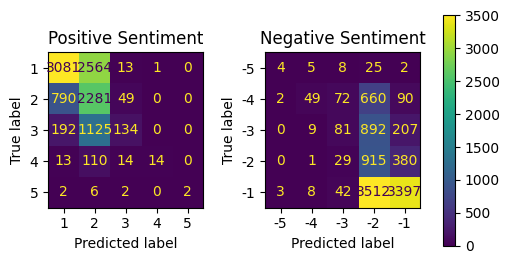

----------------Results----------------
Elapsed time: 9.92 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.506716161152869
Test score (hm f1): 0.44625679869948753
Confusion matrix for positive and negative sentiment:


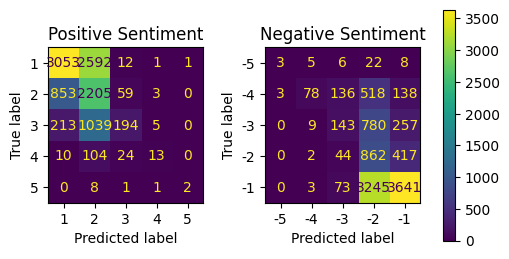

----------------Results----------------
Elapsed time: 0.28 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


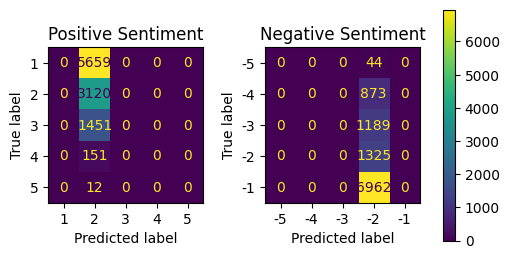

<<<<<<<SGRAM>>>>>>
----------------Results----------------
Elapsed time: 9.75 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.5163735877507021
Test score (hm f1): 0.4436913333076846
Confusion matrix for positive and negative sentiment:


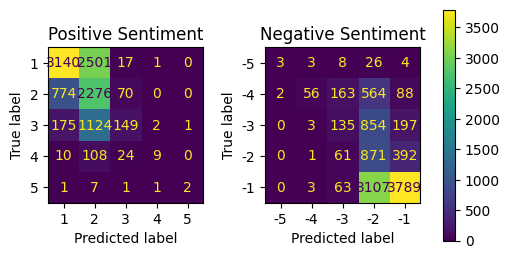

----------------Results----------------
Elapsed time: 9.94 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.5318504474850024
Test score (hm f1): 0.4652923460718499
Confusion matrix for positive and negative sentiment:


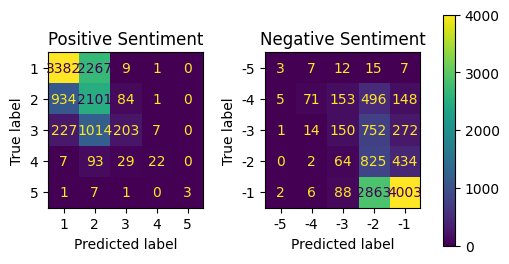

----------------Results----------------
Elapsed time: 0.30 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


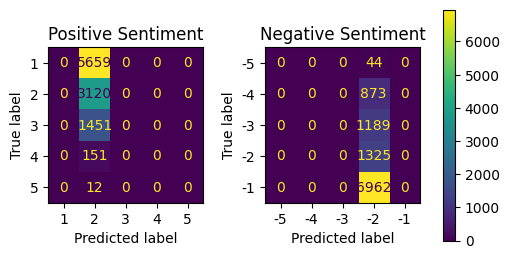

<<<<<<<FASTT>>>>>>
----------------Results----------------
Elapsed time: 9.75 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.48485032009951745
Test score (hm f1): 0.4254049253746925
Confusion matrix for positive and negative sentiment:


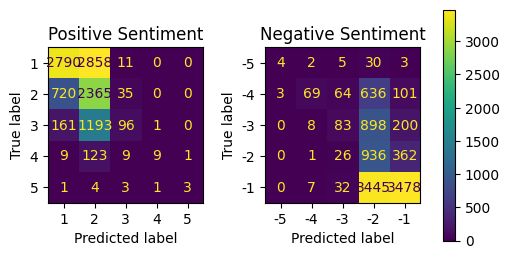

----------------Results----------------
Elapsed time: 9.79 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.5001171092302604
Test score (hm f1): 0.4313099948741128
Confusion matrix for positive and negative sentiment:


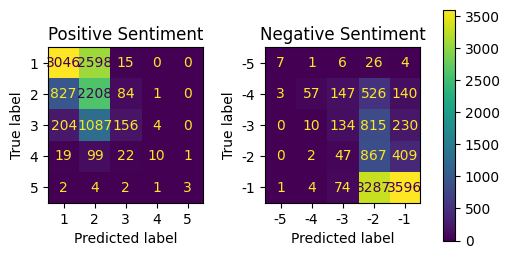

----------------Results----------------
Elapsed time: 0.27 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


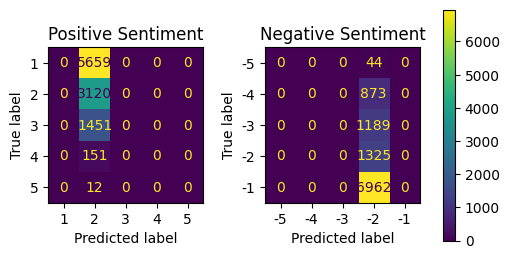

<<<<<<<GLOVE>>>>>>
----------------Results----------------
Elapsed time: 0.20 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


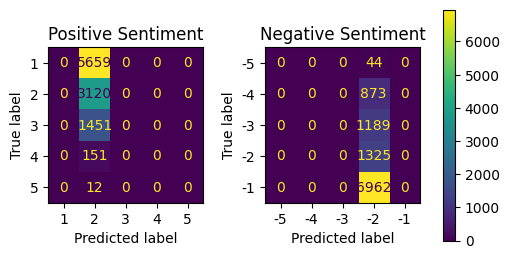

----------------Results----------------
Elapsed time: 0.23 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


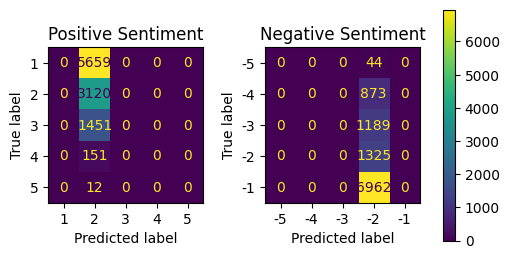

----------------Results----------------
Elapsed time: 0.27 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


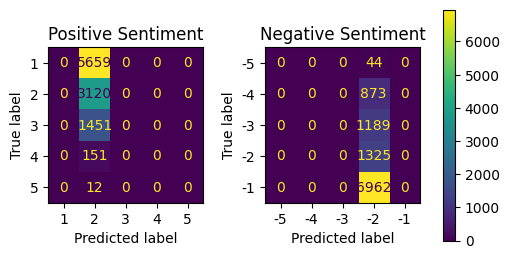

In [ ]:
#CBOW av, sum, mm
print('<<<<<<<CBOW>>>>>>>')
test_score[1,0]=grad_reg(np.asarray(X_train_val['av_cbow'].tolist()), np.asarray(X_test['av_cbow'].tolist()))
test_score[1,1]=grad_reg(np.asarray(X_train_val['sum_cbow'].tolist()), np.asarray(X_test['sum_cbow'].tolist()))
test_score[1,2]=grad_reg(np.asarray(X_train_val['mm_cbow'].tolist()), np.asarray(X_test['mm_cbow'].tolist()))

#SGRAM av, sum, mm
print('<<<<<<<SGRAM>>>>>>')
test_score[1,3]=grad_reg(np.asarray(X_train_val['av_sgram'].tolist()), np.asarray(X_test['av_sgram'].tolist()))
test_score[1,4]=grad_reg(np.asarray(X_train_val['sum_sgram'].tolist()), np.asarray(X_test['sum_sgram'].tolist()))
test_score[1,5]=grad_reg(np.asarray(X_train_val['mm_sgram'].tolist()), np.asarray(X_test['mm_sgram'].tolist()))

#FT av, sum, mm
print('<<<<<<<FASTT>>>>>>')
test_score[1,6]=grad_reg(np.asarray(X_train_val['av_ft'].tolist()), np.asarray(X_test['av_ft'].tolist()))
test_score[1,7]=grad_reg(np.asarray(X_train_val['sum_ft'].tolist()), np.asarray(X_test['sum_ft'].tolist()))
test_score[1,8]=grad_reg(np.asarray(X_train_val['mm_ft'].tolist()), np.asarray(X_test['mm_ft'].tolist()))

#glove av, sum, mm
print('<<<<<<<GLOVE>>>>>>')
test_score[1,9]=grad_reg(np.asarray(X_train_val['av_glove'].tolist()), np.asarray(X_test['av_glove'].tolist()))
test_score[1,10]=grad_reg(np.asarray(X_train_val['sum_glove'].tolist()), np.asarray(X_test['sum_glove'].tolist()))
test_score[1,11]=grad_reg(np.asarray(X_train_val['mm_glove'].tolist()), np.asarray(X_test['mm_glove'].tolist()))

<<<<<<<BOW>>>>>>>>
----------------Results----------------
Elapsed time: 6.63 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 4, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.5854080306591087
Test score (hm f1): 0.5619439117416917
Confusion matrix for positive and negative sentiment:


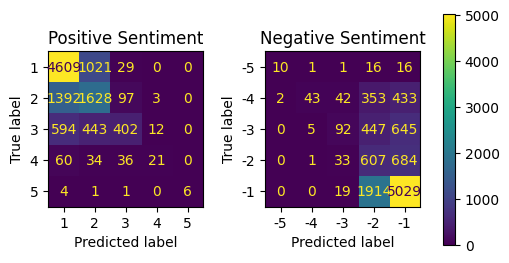

----------------Results----------------
Elapsed time: 5.89 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.597794786205402
Test score (hm f1): 0.5716837748701427
Confusion matrix for positive and negative sentiment:


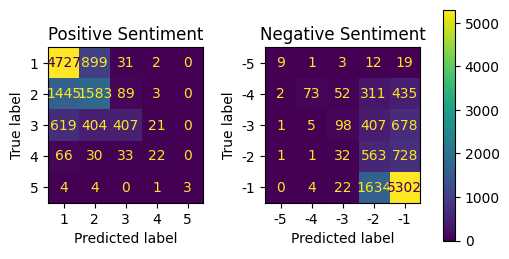

----------------Results----------------
Elapsed time: 13.41 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.5879272279974613
Test score (hm f1): 0.5587406414233818
Confusion matrix for positive and negative sentiment:


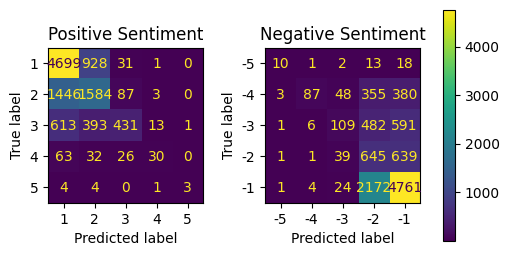

<<<<<<<TFIDF>>>>>>
----------------Results----------------
Elapsed time: 7.45 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.6052971044474982
Test score (hm f1): 0.5723537986377484
Confusion matrix for positive and negative sentiment:


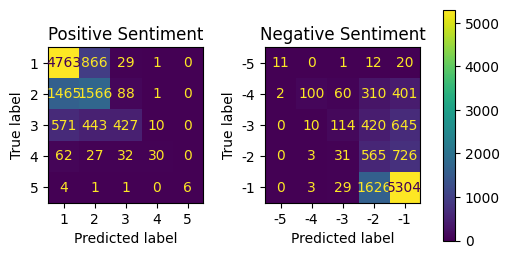

----------------Results----------------
Elapsed time: 6.90 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 5, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.36378755306294397
Test score (hm f1): 0.34666948267226577
Confusion matrix for positive and negative sentiment:


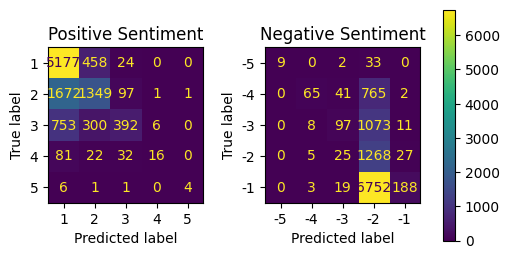

----------------Results----------------
Elapsed time: 14.50 seconds
Best hyperparams: {'estimator__learning_rate': 1, 'estimator__max_depth': 5, 'estimator__n_estimators': 15, 'estimator__n_iter_no_change': 7}
Train score (hm f1): 0.6096805129038241
Test score (hm f1): 0.5809902382083769
Confusion matrix for positive and negative sentiment:


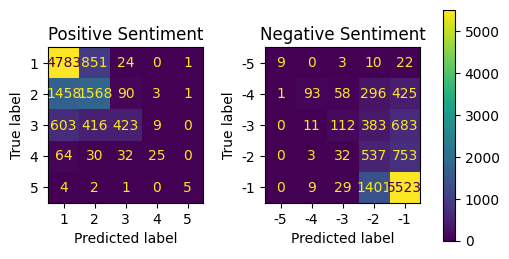

In [ ]:
#BOW av, sum, mm
print('<<<<<<<BOW>>>>>>>>')
test_score[1,12]=grad_reg(np.asarray(X_train_val['av_bow'].tolist()), np.asarray(X_test['av_bow'].tolist()))
test_score[1,13]=grad_reg(np.asarray(X_train_val['sum_bow'].tolist()), np.asarray(X_test['sum_bow'].tolist()))
test_score[1,14]=grad_reg(np.asarray(X_train_val['mm_bow'].tolist()), np.asarray(X_test['mm_bow'].tolist()))

#TFIDF av, sum, mm
print('<<<<<<<TFIDF>>>>>>')
test_score[1,15]=grad_reg(np.asarray(X_train_val['av_tfidf'].tolist()), np.asarray(X_test['av_tfidf'].tolist()))
test_score[1,16]=grad_reg(np.asarray(X_train_val['sum_tfidf'].tolist()), np.asarray(X_test['sum_tfidf'].tolist()))
test_score[1,17]=grad_reg(np.asarray(X_train_val['mm_tfidf'].tolist()), np.asarray(X_test['mm_tfidf'].tolist()))

Classifier 4: Naive Bayes

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def ada_reg(sentence, sentence_test):
    params = {'estimator__loss': ['square', 'exponential'], 'estimator__n_estimators': [5, 15, 30],
              'estimator__learning_rate': [0.1, 1, 10], 'estimator__random_state':[42]}
    regr = GridSearchCV(MultiOutputRegressor(AdaBoostRegressor()), param_grid=params,
                        n_jobs=-1, cv=2, scoring=weighted_harmonic_f1_scorer, verbose=0)
    start_time = time.time()
    regr.fit(sentence, np.asarray(y_train_val[['pos_sent', 'neg_sent']].values.tolist()))
    elapsed_time = time.time() - start_time
    
    test_score = print_results(regr, sentence, sentence_test, elapsed_time, cl=False)
    return test_score

<<<<<<<CBOW>>>>>>>
----------------Results----------------
Elapsed time: 20.03 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4540389949676706
Test score (hm f1): 0.45832718695092733
Confusion matrix for positive and negative sentiment:


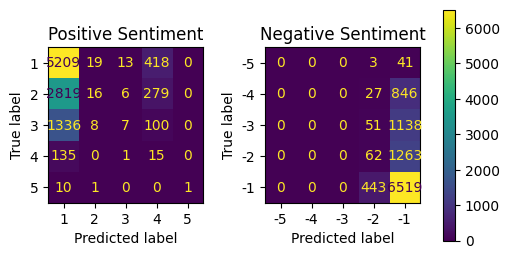

----------------Results----------------
Elapsed time: 19.89 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.36843768801081567
Test score (hm f1): 0.3666460805685867
Confusion matrix for positive and negative sentiment:


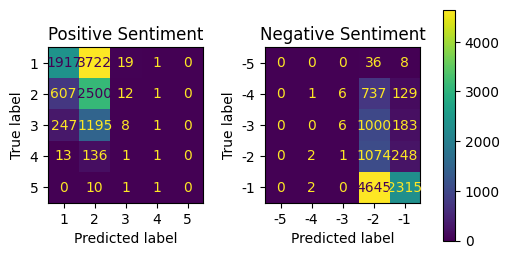

----------------Results----------------
Elapsed time: 2.91 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


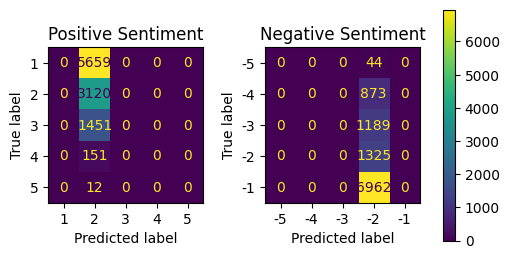

<<<<<<<SGRAM>>>>>>
----------------Results----------------
Elapsed time: 20.12 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4011768136065598
Test score (hm f1): 0.40079528556088717
Confusion matrix for positive and negative sentiment:


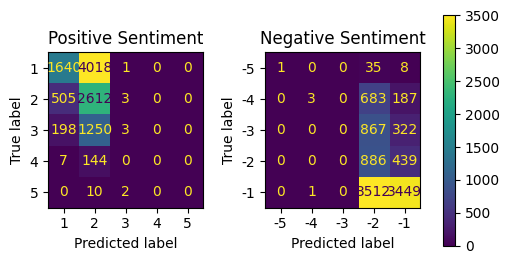

----------------Results----------------
Elapsed time: 20.03 seconds
Best hyperparams: {'estimator__learning_rate': 0.1, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4109686132432985
Test score (hm f1): 0.4082698299037407
Confusion matrix for positive and negative sentiment:


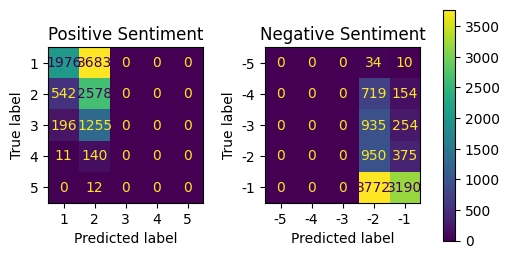

----------------Results----------------
Elapsed time: 2.82 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


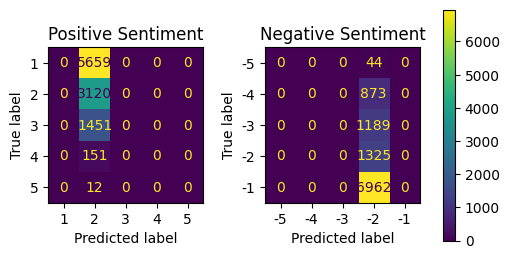

<<<<<<<FASTT>>>>>>
----------------Results----------------
Elapsed time: 20.36 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4631537267077055
Test score (hm f1): 0.46631373011739996
Confusion matrix for positive and negative sentiment:


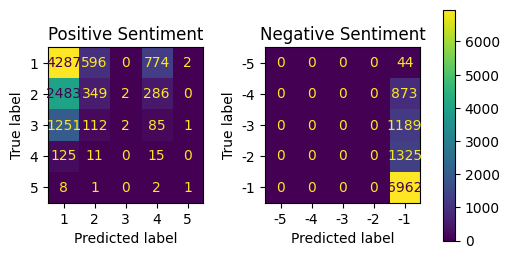

----------------Results----------------
Elapsed time: 20.02 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4665555817551231
Test score (hm f1): 0.4665509799023577
Confusion matrix for positive and negative sentiment:


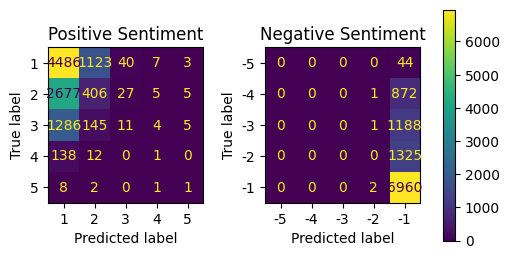

----------------Results----------------
Elapsed time: 2.81 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


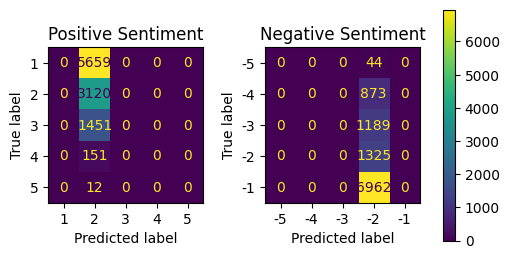

<<<<<<<GLOVE>>>>>>
----------------Results----------------
Elapsed time: 2.44 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


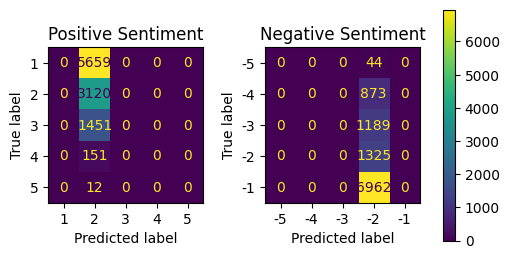

----------------Results----------------
Elapsed time: 2.45 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


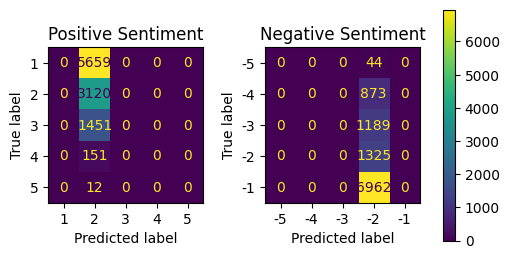

----------------Results----------------
Elapsed time: 2.82 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.08372903840790531
Test score (hm f1): 0.08374054331085581
Confusion matrix for positive and negative sentiment:


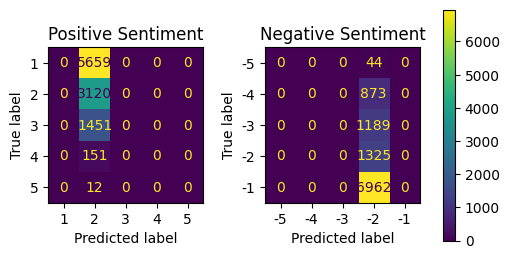

In [ ]:
#CBOW av, sum, mm
print('<<<<<<<CBOW>>>>>>>')
test_score[2,0]=ada_reg(np.asarray(X_train_val['av_cbow'].tolist()), np.asarray(X_test['av_cbow'].tolist()))
test_score[2,1]=ada_reg(np.asarray(X_train_val['sum_cbow'].tolist()), np.asarray(X_test['sum_cbow'].tolist()))
test_score[2,2]=ada_reg(np.asarray(X_train_val['mm_cbow'].tolist()), np.asarray(X_test['mm_cbow'].tolist()))

#SGRAM av, sum, mm
print('<<<<<<<SGRAM>>>>>>')
test_score[2,3]=ada_reg(np.asarray(X_train_val['av_sgram'].tolist()), np.asarray(X_test['av_sgram'].tolist()))
test_score[2,4]=ada_reg(np.asarray(X_train_val['sum_sgram'].tolist()), np.asarray(X_test['sum_sgram'].tolist()))
test_score[2,5]=ada_reg(np.asarray(X_train_val['mm_sgram'].tolist()), np.asarray(X_test['mm_sgram'].tolist()))

#FT av, sum, mm
print('<<<<<<<FASTT>>>>>>')
test_score[2,6]=ada_reg(np.asarray(X_train_val['av_ft'].tolist()), np.asarray(X_test['av_ft'].tolist()))
test_score[2,7]=ada_reg(np.asarray(X_train_val['sum_ft'].tolist()), np.asarray(X_test['sum_ft'].tolist()))
test_score[2,8]=ada_reg(np.asarray(X_train_val['mm_ft'].tolist()), np.asarray(X_test['mm_ft'].tolist()))

#glove av, sum, mm
print('<<<<<<<GLOVE>>>>>>')
test_score[2,9]=ada_reg(np.asarray(X_train_val['av_glove'].tolist()), np.asarray(X_test['av_glove'].tolist()))
test_score[2,10]=ada_reg(np.asarray(X_train_val['sum_glove'].tolist()), np.asarray(X_test['sum_glove'].tolist()))
test_score[2,11]=ada_reg(np.asarray(X_train_val['mm_glove'].tolist()), np.asarray(X_test['mm_glove'].tolist()))

<<<<<<<BOW>>>>>>>>
----------------Results----------------
Elapsed time: 23.16 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.46305786805628474
Test score (hm f1): 0.4685203183346207
Confusion matrix for positive and negative sentiment:


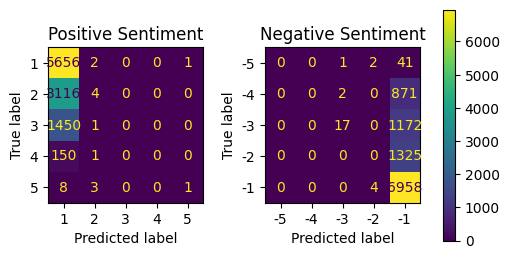

----------------Results----------------
Elapsed time: 22.08 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4614808415715953
Test score (hm f1): 0.46792581931130095
Confusion matrix for positive and negative sentiment:


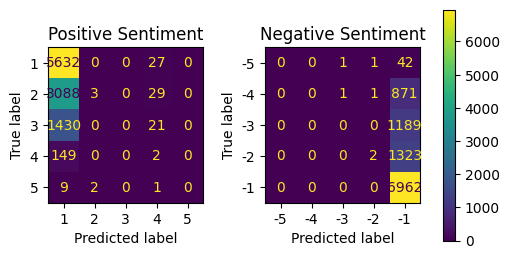

----------------Results----------------
Elapsed time: 42.10 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.46352619543651286
Test score (hm f1): 0.47007785643120825
Confusion matrix for positive and negative sentiment:


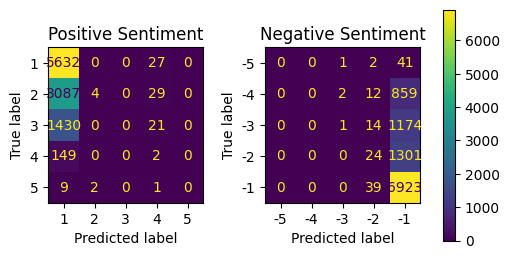

<<<<<<<TFIDF>>>>>>
----------------Results----------------
Elapsed time: 23.13 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4629316563435071
Test score (hm f1): 0.4679506044371033
Confusion matrix for positive and negative sentiment:


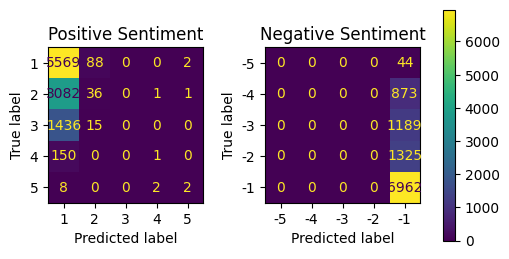

----------------Results----------------
Elapsed time: 23.09 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.46458365796016726
Test score (hm f1): 0.472326731060161
Confusion matrix for positive and negative sentiment:


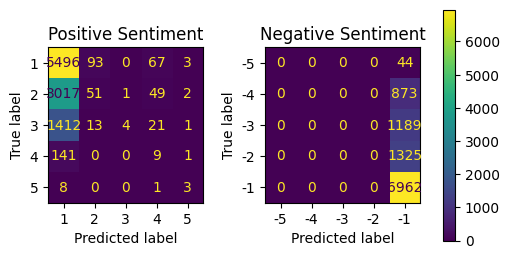

----------------Results----------------
Elapsed time: 46.81 seconds
Best hyperparams: {'estimator__learning_rate': 10, 'estimator__loss': 'exponential', 'estimator__n_estimators': 5, 'estimator__random_state': 42}
Train score (hm f1): 0.4733233658526674
Test score (hm f1): 0.48069743862846903
Confusion matrix for positive and negative sentiment:


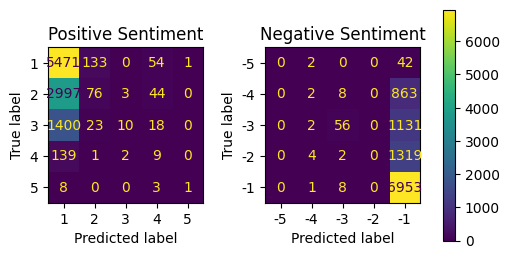

In [ ]:
#BOW av, sum, mm
print('<<<<<<<BOW>>>>>>>>')
test_score[2,12]=ada_reg(np.asarray(X_train_val['av_bow'].tolist()), np.asarray(X_test['av_bow'].tolist()))
test_score[2,13]=ada_reg(np.asarray(X_train_val['sum_bow'].tolist()), np.asarray(X_test['sum_bow'].tolist()))
test_score[2,14]=ada_reg(np.asarray(X_train_val['mm_bow'].tolist()), np.asarray(X_test['mm_bow'].tolist()))

#TFIDF av, sum, mm
print('<<<<<<<TFIDF>>>>>>')
test_score[2,15]=ada_reg(np.asarray(X_train_val['av_tfidf'].tolist()), np.asarray(X_test['av_tfidf'].tolist()))
test_score[2,16]=ada_reg(np.asarray(X_train_val['sum_tfidf'].tolist()), np.asarray(X_test['sum_tfidf'].tolist()))
test_score[2,17]=ada_reg(np.asarray(X_train_val['mm_tfidf'].tolist()), np.asarray(X_test['mm_tfidf'].tolist()))

In [ ]:
from tabulate import tabulate

indexes = ['CBOW av', 'CBOW sum', 'CBOW mm',
           'SGRAM av', 'SGRAM sum', 'SGRAM mm',
           'FT av', 'FT sum', 'FT mm',
           'glove av', 'glove sum', 'glove mm',
           'BOW av', 'BOW sum', 'BOW mm',
           'TFIDF av', 'TFIDF sum', 'TFIDF mm'
           ]

print('TRAIN SCORE:')
print(tabulate(np.round(test_score[:,:,0].T,2), headers=['Random Forests', 'Gradient Boosting', 'AdaBoost'], showindex=indexes, tablefmt='orgtbl'))
print()
print('TEST SCORE:')
print(tabulate(np.round(test_score[:,:,1].T,2), headers=['Random Forests', 'Gradient Boosting', 'AdaBoost'], showindex=indexes, tablefmt='orgtbl'))
print()
print('EXECUTION TIME')
print(tabulate(np.round(test_score[:,:,2].T,2), headers=['Random Forests', 'Gradient Boosting', 'AdaBoost'], showindex=indexes, tablefmt='orgtbl'))

TRAIN SCORE:
|           |   Random Forests |   Gradient Boosting |   AdaBoost |
|-----------+------------------+---------------------+------------|
| CBOW av   |             0.39 |                0.49 |       0.45 |
| CBOW sum  |             0.43 |                0.51 |       0.37 |
| CBOW mm   |             0.08 |                0.08 |       0.08 |
| SGRAM av  |             0.42 |                0.52 |       0.4  |
| SGRAM sum |             0.45 |                0.53 |       0.41 |
| SGRAM mm  |             0.08 |                0.08 |       0.08 |
| FT av     |             0.39 |                0.48 |       0.46 |
| FT sum    |             0.41 |                0.5  |       0.47 |
| FT mm     |             0.08 |                0.08 |       0.08 |
| glove av  |             0.08 |                0.08 |       0.08 |
| glove sum |             0.08 |                0.08 |       0.08 |
| glove mm  |             0.08 |                0.08 |       0.08 |
| BOW av    |             0.12 |   

### Q9: Performance comparison (3 pts)

Using the summary table computed in Q8, compare the performance of all for methods on the sentiment analysis task using
the TweetsCOV19 dataset. Also compare methods from a computational point of view. What embedding model, aggregation method and classifier would you select among all approaches? Give potential extensions that could help improve your performance.

## TRANSFORMERS

### Q1: Transformer-based language models

### Q2: Scalability

### Q3: Code

### Q4: Performance analysis

### Q5: Transfer learning details

### Q6: Embedding analysis

## Part 3: Downstream Global Health Analysis

### Q1: Research question

choice of paper: https://www.nature.com/articles/s41599-021-00861-3

- took a subset of tweets that only happened in the US through string matching of user location, just like in the paper
- plotted labels vs. time (weekly) for the whole US-dataset
- plotted VADER labels vs. time (weekly)
- ran lexicon matching on NCR lexicon to find emotions throughout time (weekly) like in the paper
--> in the paper, this is of course done in a more complex manner.

In [16]:
state_names=["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

US_names = ['US', 'USA', 'U.S.', 'U.S', 'U.S.A.', 'U.S.A', 'States']

state_abbreviation_names = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

city_names = ["Aberdeen", "Abilene", "Akron", "Albany", "Albuquerque", "Alexandria", "Allentown", "Amarillo", "Anaheim", "Anchorage", "Ann Arbor", "Antioch", "Apple Valley", "Appleton", "Arlington", "Arvada", "Asheville", "Athens", "Atlanta", "Atlantic City", "Augusta", "Aurora", "Austin", "Bakersfield", "Baltimore", "Barnstable", "Baton Rouge", "Beaumont", "Bel Air", "Bellevue", "Berkeley", "Bethlehem", "Billings", "Birmingham", "Bloomington", "Boise", "Boise City", "Bonita Springs", "Boston", "Boulder", "Bradenton", "Bremerton", "Bridgeport", "Brighton", "Brownsville", "Bryan", "Buffalo", "Burbank", "Burlington", "Cambridge", "Canton", "Cape Coral", "Carrollton", "Cary", "Cathedral City", "Cedar Rapids", "Champaign", "Chandler", "Charleston", "Charlotte", "Chattanooga", "Chesapeake", "Chicago", "Chula Vista", "Cincinnati", "Clarke County", "Clarksville", "Clearwater", "Cleveland", "College Station", "Colorado Springs", "Columbia", "Columbus", "Concord", "Coral Springs", "Corona", "Corpus Christi", "Costa Mesa", "Dallas", "Daly City", "Danbury", "Davenport", "Davidson County", "Dayton", "Daytona Beach", "Deltona", "Denton", "Denver", "Des Moines", "Detroit", "Downey", "Duluth", "Durham", "El Monte", "El Paso", "Elizabeth", "Elk Grove", "Elkhart", "Erie", "Escondido", "Eugene", "Evansville", "Fairfield", "Fargo", "Fayetteville", "Fitchburg", "Flint", "Fontana", "Fort Collins", "Fort Lauderdale", "Fort Smith", "Fort Walton Beach", "Fort Wayne", "Fort Worth", "Frederick", "Fremont", "Fresno", "Fullerton", "Gainesville", "Garden Grove", "Garland", "Gastonia", "Gilbert", "Glendale", "Grand Prairie", "Grand Rapids", "Grayslake", "Green Bay", "GreenBay", "Greensboro", "Greenville", "Gulfport-Biloxi", "Hagerstown", "Hampton", "Harlingen", "Harrisburg", "Hartford", "Havre de Grace", "Hayward", "Hemet", "Henderson", "Hesperia", "Hialeah", "Hickory", "High Point", "Hollywood", "Honolulu", "Houma", "Houston", "Howell", "Huntington", "Huntington Beach", "Huntsville", "Independence", "Indianapolis", "Inglewood", "Irvine", "Irving", "Jackson", "Jacksonville", "Jefferson", "Jersey City", "Johnson City", "Joliet", "Kailua", "Kalamazoo", "Kaneohe", "Kansas City", "Kennewick", "Kenosha", "Killeen", "Kissimmee", "Knoxville", "Lacey", "Lafayette", "Lake Charles", "Lakeland", "Lakewood", "Lancaster", "Lansing", "Laredo", "Las Cruces", "Las Vegas", "Layton", "Leominster", "Lewisville", "Lexington", "Lincoln", "Little Rock", "Long Beach", "Lorain", "Los Angeles", "Louisville", "Lowell", "Lubbock", "Macon", "Madison", "Manchester", "Marina", "Marysville", "McAllen", "McHenry", "Medford", "Melbourne", "Memphis", "Merced", "Mesa", "Mesquite", "Miami", "Milwaukee", "Minneapolis", "Miramar", "Mission Viejo", "Mobile", "Modesto", "Monroe", "Monterey", "Montgomery", "Moreno Valley", "Murfreesboro", "Murrieta", "Muskegon", "Myrtle Beach", "Naperville", "Naples", "Nashua", "Nashville", "New Bedford", "New Haven", "New London", "New Orleans", "New York", "New York City", "Newark", "Newburgh", "Newport News", "Norfolk", "Normal", "Norman", "North Charleston", "North Las Vegas", "North Port", "Norwalk", "Norwich", "Oakland", "Ocala", "Oceanside", "Odessa", "Ogden", "Oklahoma City", "Olathe", "Olympia", "Omaha", "Ontario", "Orange", "Orem", "Orlando", "Overland Park", "Oxnard", "Palm Bay", "Palm Springs", "Palmdale", "Panama City", "Pasadena", "Paterson", "Pembroke Pines", "Pensacola", "Peoria", "Philadelphia", "Phoenix", "Pittsburgh", "Plano", "Pomona", "Pompano Beach", "Port Arthur", "Port Orange", "Port Saint Lucie", "Port St. Lucie", "Portland", "Portsmouth", "Poughkeepsie", "Providence", "Provo", "Pueblo", "Punta Gorda", "Racine", "Raleigh", "Rancho Cucamonga", "Reading", "Redding", "Reno", "Richland", "Richmond", "Richmond County", "Riverside", "Roanoke", "Rochester", "Rockford", "Roseville", "Round Lake Beach", "Sacramento", "Saginaw", "Saint Louis", "Saint Paul", "Saint Petersburg", "Salem", "Salinas", "Salt Lake City", "San Antonio", "San Bernardino", "San Buenaventura", "San Diego", "San Francisco", "San Jose", "Santa Ana", "Santa Barbara", "Santa Clara", "Santa Clarita", "Santa Cruz", "Santa Maria", "Santa Rosa", "Sarasota", "Savannah", "Scottsdale", "Scranton", "Seaside", "Seattle", "Sebastian", "Shreveport", "Simi Valley", "Sioux City", "Sioux Falls", "South Bend", "South Lyon", "Spartanburg", "Spokane", "Springdale", "Springfield", "St. Louis", "St. Paul", "St. Petersburg", "Stamford", "Sterling Heights", "Stockton", "Sunnyvale", "Syracuse", "Tacoma", "Tallahassee", "Tampa", "Temecula", "Tempe", "Thornton", "Thousand Oaks", "Toledo", "Topeka", "Torrance", "Trenton", "Tucson", "Tulsa", "Tuscaloosa", "Tyler", "Utica", "Vallejo", "Vancouver", "Vero Beach", "Victorville", "Virginia Beach", "Visalia", "Waco", "Warren", "Washington", "Waterbury", "Waterloo", "West Covina", "West Valley City", "Westminster", "Wichita", "Wilmington", "Winston", "Winter Haven", "Worcester", "Yakima", "Yonkers", "York", "Youngstown"]


In [17]:
# Part 3
df_tweets_new = df_tweets[['TweetText', 'Timestamp', 'UserLocation', 'pos_sent', 'neg_sent']]
print(df_tweets_new.shape)
# geopy, geotext take too long and leads to too many timeouts
# to extract tweets in the US, just search for state names, abbreviations, and regex 'US, U.S, USA, U.S.A.' and so forth, which is the technique used in the paper
list_US_locations = state_abbreviation_names + state_names + US_names + city_names

# get tweets based in the US only, to save time, drop all rows that don't have 'common' locations (mentioned more than ) 
locations = df_tweets_new['UserLocation'].value_counts()
locations = locations[locations>10] # filter out most of the garbage locations this way
df_tweets_new = df_tweets_new[df_tweets_new['UserLocation'].isin(locations.index)]
#df_tweets_new['US_or_not'] = df_tweets_new['UserLocation'].apply(lambda x: 1 if any(i in str(x) for i in list_US_locations) else 0)
df_tweets_new['US_or_not'] = df_tweets_new['UserLocation'].apply(lambda x: 1 if any(i == str(y) for y in x.split() for i in list_US_locations) else 0)
df_tweets_US = df_tweets_new[df_tweets_new['US_or_not']==1]
print(df_tweets_US.shape)


# end up with 103k tweets we are sure are in the US
df_tweets_US = df_tweets_US.set_index('Timestamp').sort_values(by='Timestamp', ascending=True)
df_tweets_US.index = df_tweets_US.index.astype('datetime64[ns]')
#df_tweets_US.index = df_tweets_US.index.astype('datetime64[ns]')  - pd.to_timedelta(7, unit='d')

df_tweets_US[['pos_sent', 'neg_sent']] = df_tweets_US[['pos_sent', 'neg_sent']].astype('int')
df_tweets_US['neg_sent'] = df_tweets_US['neg_sent'].abs()
df_tweets_US = df_tweets_US.rename(columns={'US_or_not': 'TweetCount'})


(382789, 5)
(103096, 6)


In [18]:
set_stopwords = set(stopwords.words('english'))
df_tweets_US['tokens'] = df_tweets_US['TweetText'].apply(nltk.word_tokenize)
df_tweets_US['unigram']=[[lemmmatizer.lemmatize(item) for item in list_item if item not in set_stopwords ] for list_item in df_tweets_US['tokens']]

# since we found earlier that VADER results are different to the labels, now compute the VADER score for these US tweets and plot their score in time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

def map_sentiment(compound_val):
    if compound_val >= 0.05:
        return 'positive'
    if compound_val <= - 0.05:
        return 'negative'
    else:
        return 'neutral'

df_tweets_US['vader_polarity'] = [sid_obj.polarity_scores(sentence) for sentence in df_tweets_US['TweetText']]
df_tweets_US['vader_decision'] = [map_sentiment(sentiment_dict['compound']) for sentiment_dict in df_tweets_US['vader_polarity']]

# one hot encode vader_decision column for easy weekly summing afterwards
df_tweets_US[['negative', 'neutral', 'positive']] = pd.get_dummies(df_tweets_US['vader_decision'])

In [19]:
#df_US_monthly = df_tweets_US.groupby(by=[df_tweets_US.index.year, df_tweets_US.index.month])[['pos_sent', 'neg_sent']].sum()
#df_tweets_US.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')
df_US_weekly = df_tweets_US.resample('W').sum() # sum of positive and negative 
df_US_weekly['avg_pos'] = df_US_weekly['pos_sent']/df_US_weekly['TweetCount']
df_US_weekly['avg_neg'] = df_US_weekly['neg_sent']/df_US_weekly['TweetCount'] 
df_US_weekly['avg_pos_count'] = df_US_weekly['positive']/df_US_weekly['TweetCount']
df_US_weekly['avg_neg_count'] = df_US_weekly['negative']/df_US_weekly['TweetCount'] 
df_US_weekly['avg_neutral_count'] = df_US_weekly['neutral']/df_US_weekly['TweetCount'] 



/tmp/ipykernel_115/4185189066.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_US_weekly = df_tweets_US.resample('W').sum() # sum of positive and negative


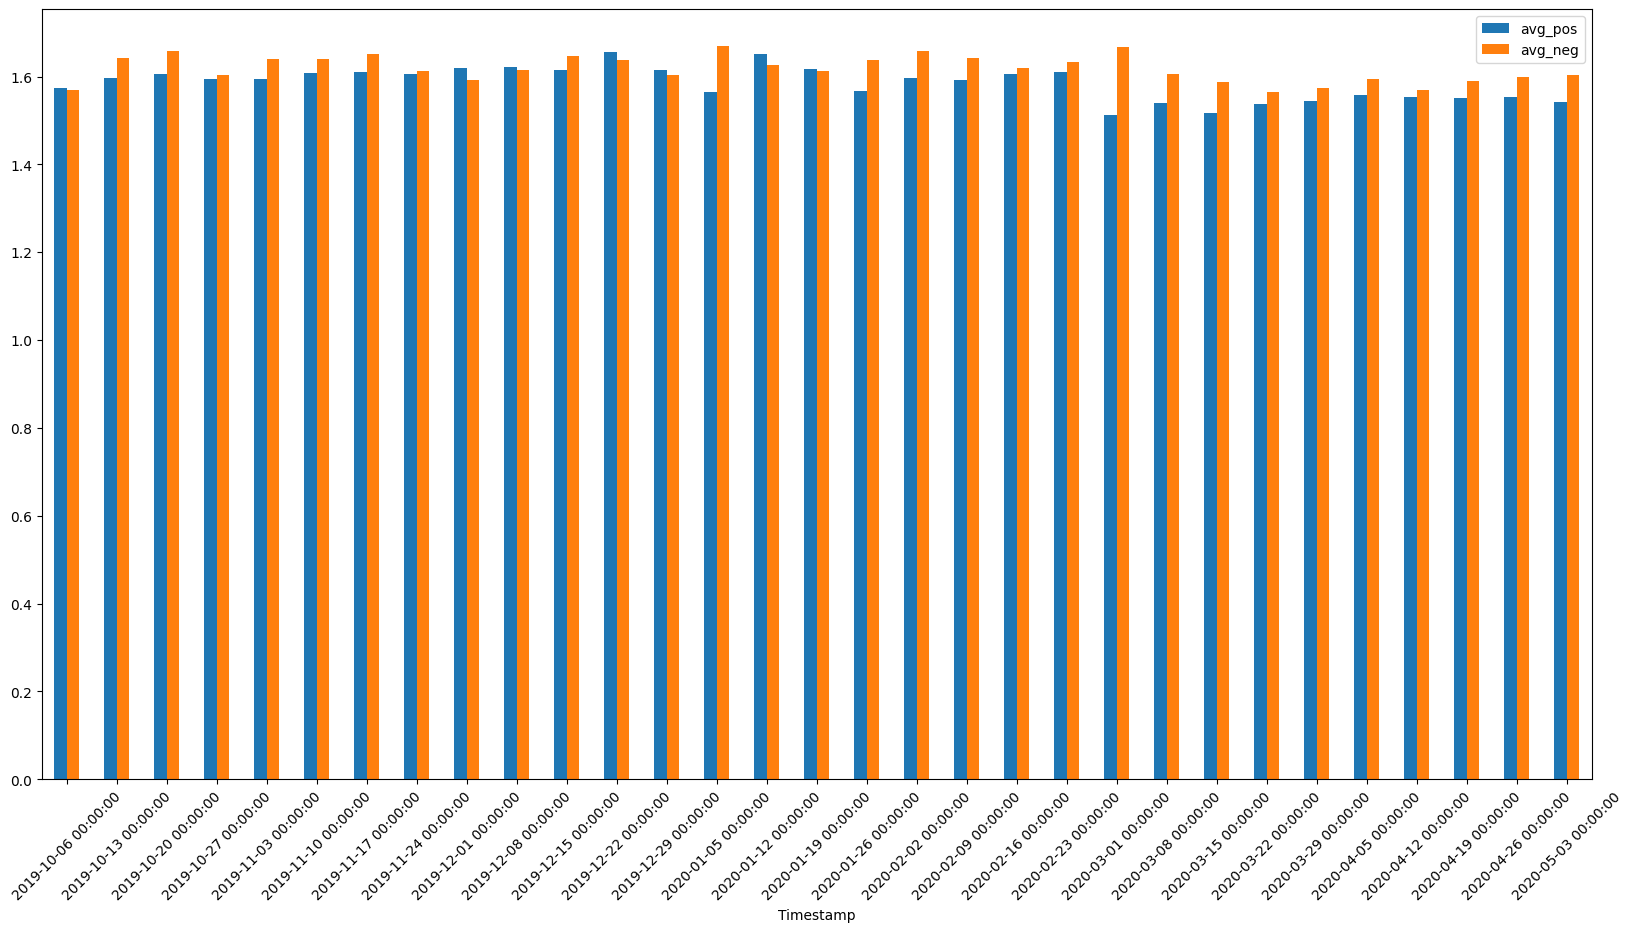

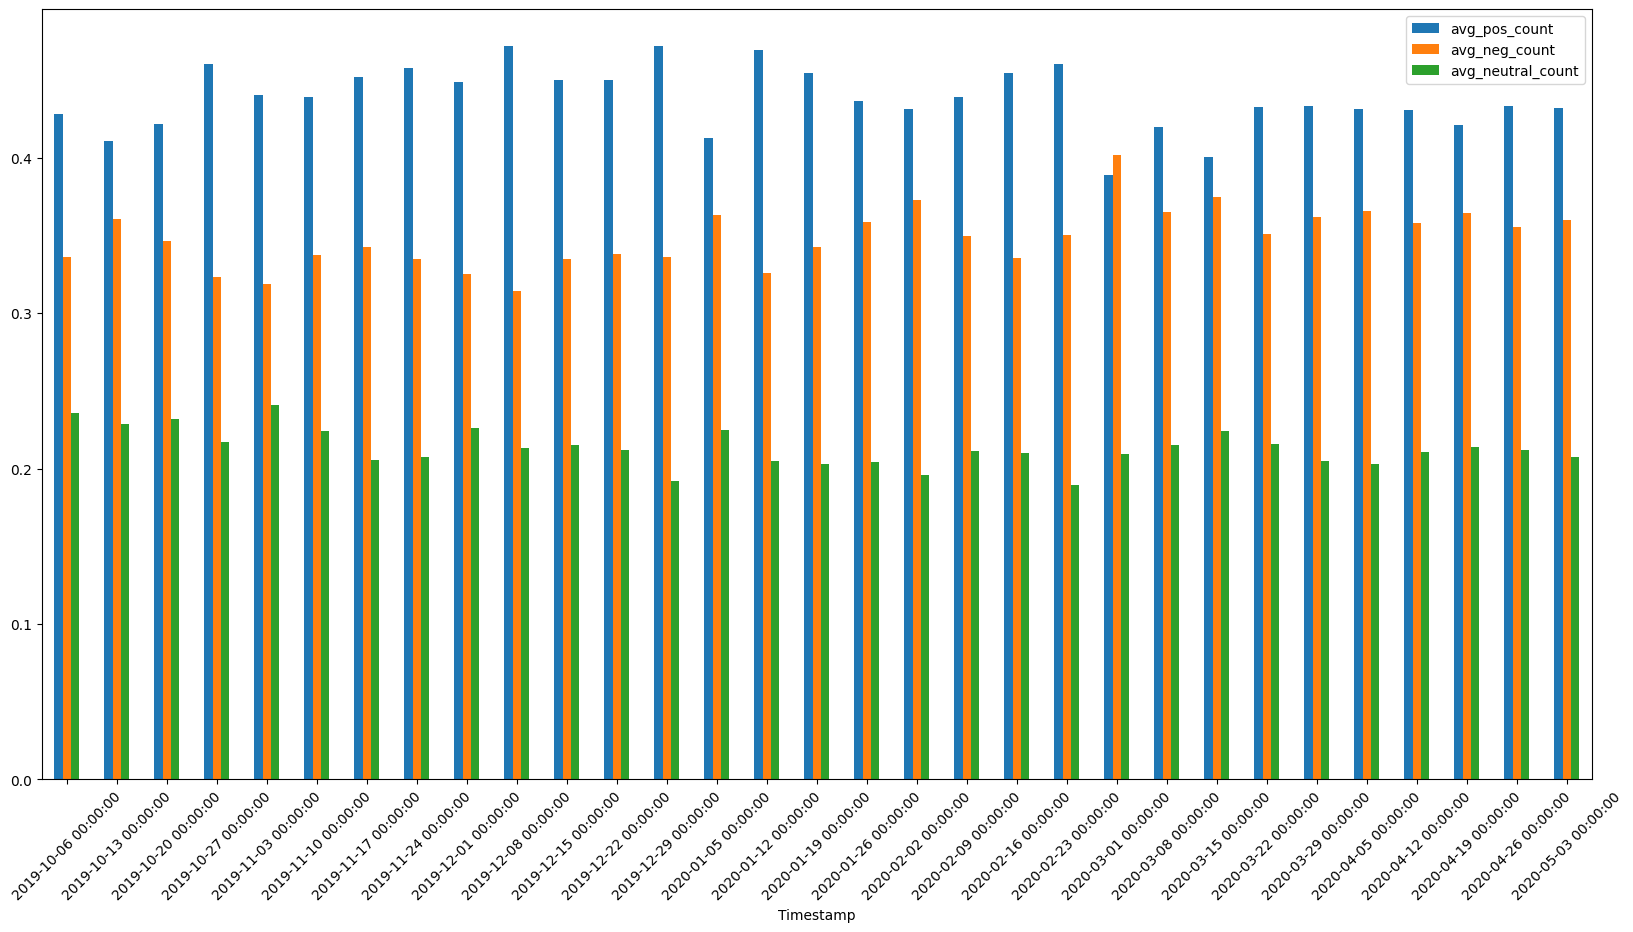

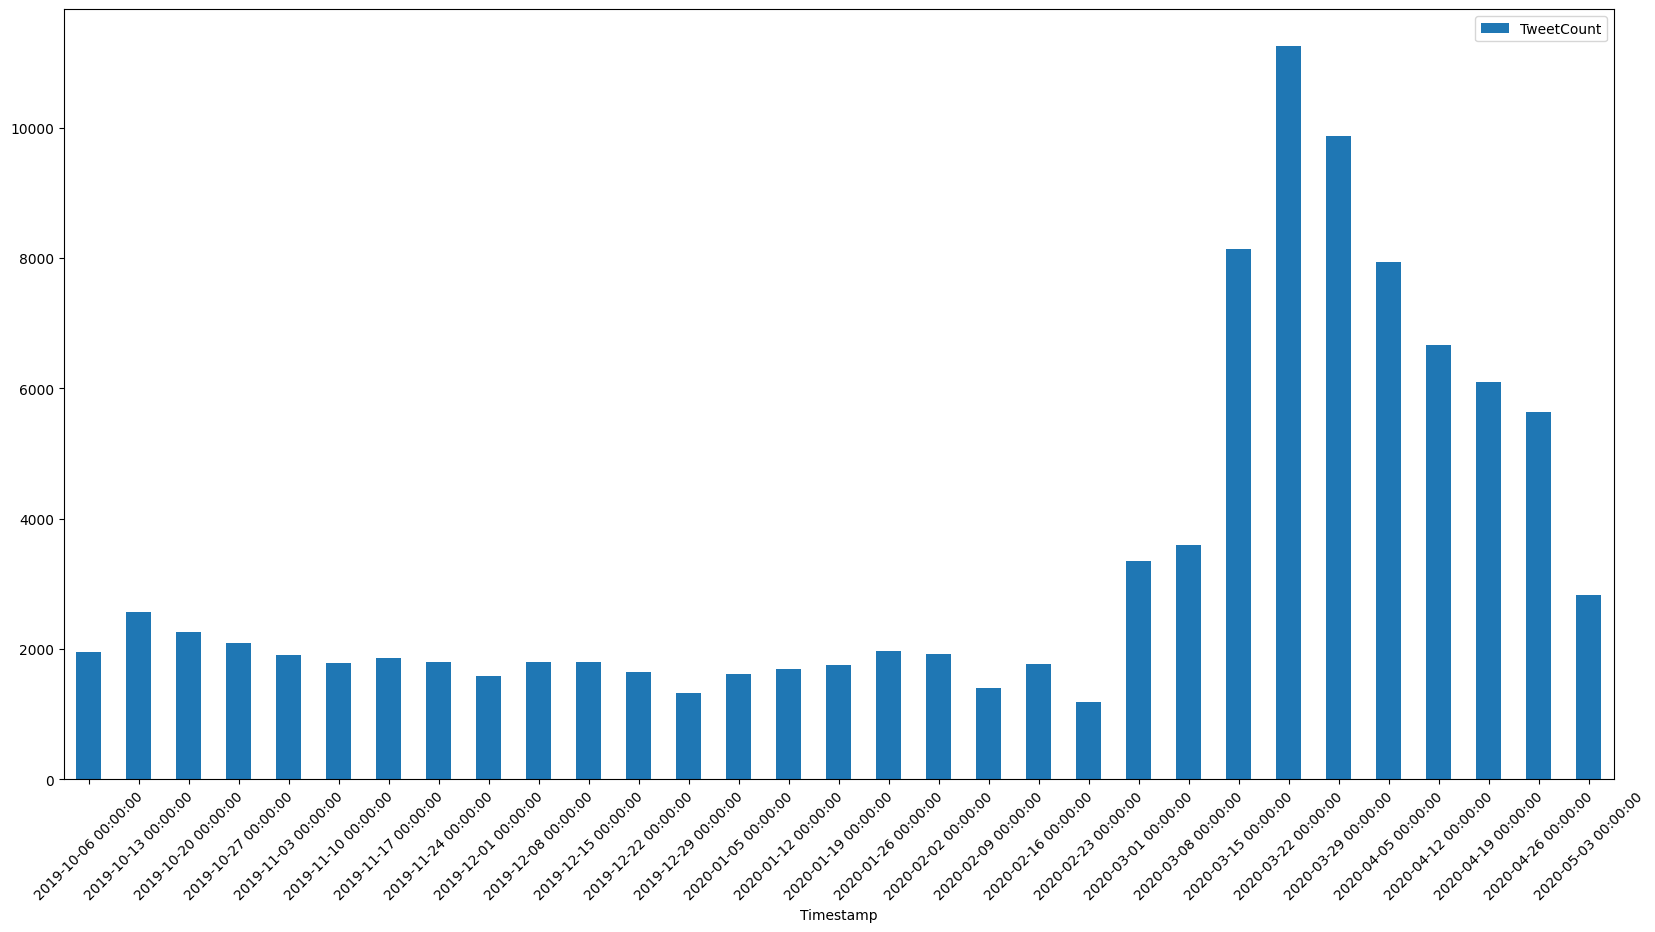

In [20]:
df_US_weekly[['avg_pos', 'avg_neg']].plot(kind='bar',  rot=45, figsize=(20, 10))
df_US_weekly[['avg_pos_count', 'avg_neg_count', 'avg_neutral_count']].plot(kind='bar',  rot=45, figsize=(20, 10))
df_US_weekly[['TweetCount']].plot(kind='bar',  rot=45, figsize=(20, 10))
plt.show()
#df_US_monthly['neg_sent'].plot(kind='bar', alpha=0.75, rot=45)

In [21]:
# emotion lexicon
# Importing the data from the NCR lexicon
ncr = pd.read_csv('NCR-lexicon.csv', sep =';')

In [ ]:
# Let's create a list of the emotions
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']
stemmer = SnowballStemmer("english")
df_emotions = pd.DataFrame(0, index=df_tweets_US.index, columns=emotions)


for i, row in df_tweets_US.iterrows(): # for each tweet ...
    tweet = row['unigram']
    for word in tweet: # for each word ...
        word_stemmed = stemmer.stem(word)
        # check if the word is in NRC
        result = ncr[ncr.English == word_stemmed]
        
        # we have a match
        if not result.empty:
            # update the tweet-emotions counts
            for idx, emotion in enumerate(emotions):
                df_emotions.loc[i, emotion] += result[emotion].values

df_emotions.to_csv('emotions.csv')

In [36]:
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']

df_emotions = pd.read_csv('emotions.csv', header=0, index_col=False, sep =',')
df_emotions['Timestamp'] = pd.to_datetime(df_emotions['Timestamp'])
df_emotions = df_emotions.set_index('Timestamp') 
df_emotions

Anger  Anticipation  Disgust  Fear  Joy  Sadness  \
Timestamp                                                               
2019-09-30 22:00:44      0             1        0     0    0        0   
2019-09-30 22:04:02      0             2        0     0    0        0   
2019-09-30 22:04:39      0             0        0     0    0        0   
2019-09-30 22:04:49      0             0        1     1    0        0   
2019-09-30 22:06:21      0             0        0     0    0        1   
...                    ...           ...      ...   ...  ...      ...   
2020-04-30 21:44:20      0             1        0     0    0        0   
2020-04-30 21:50:14      0             1        0     0    0        0   
2020-04-30 21:55:57      0             0        1     0    0        0   
2020-04-30 21:56:40      1             0        0     1    0        1   
2020-04-30 21:59:04      1             3        1     1    0        1   

                     Surprise  Trust  
Timestamp                             
2019-09-30 22:00:44         0      0  
2019-09-30 22:04:02         0      3  
2019-09-30 22:04:39         0      0  
2019-09-30 22:04:49         0      0  
2019-09-30 22:06:21         0      2  
...                       ...    ...  
2020-04-30 21:44:20         0      0  
2020-04-30 21:50:14         0      0  
2020-04-30 21:55:57         0      1  
2020-04-30 21:56:40         1      1  
2020-04-30 21:59:04         1      1  

[103096 rows x 8 columns]

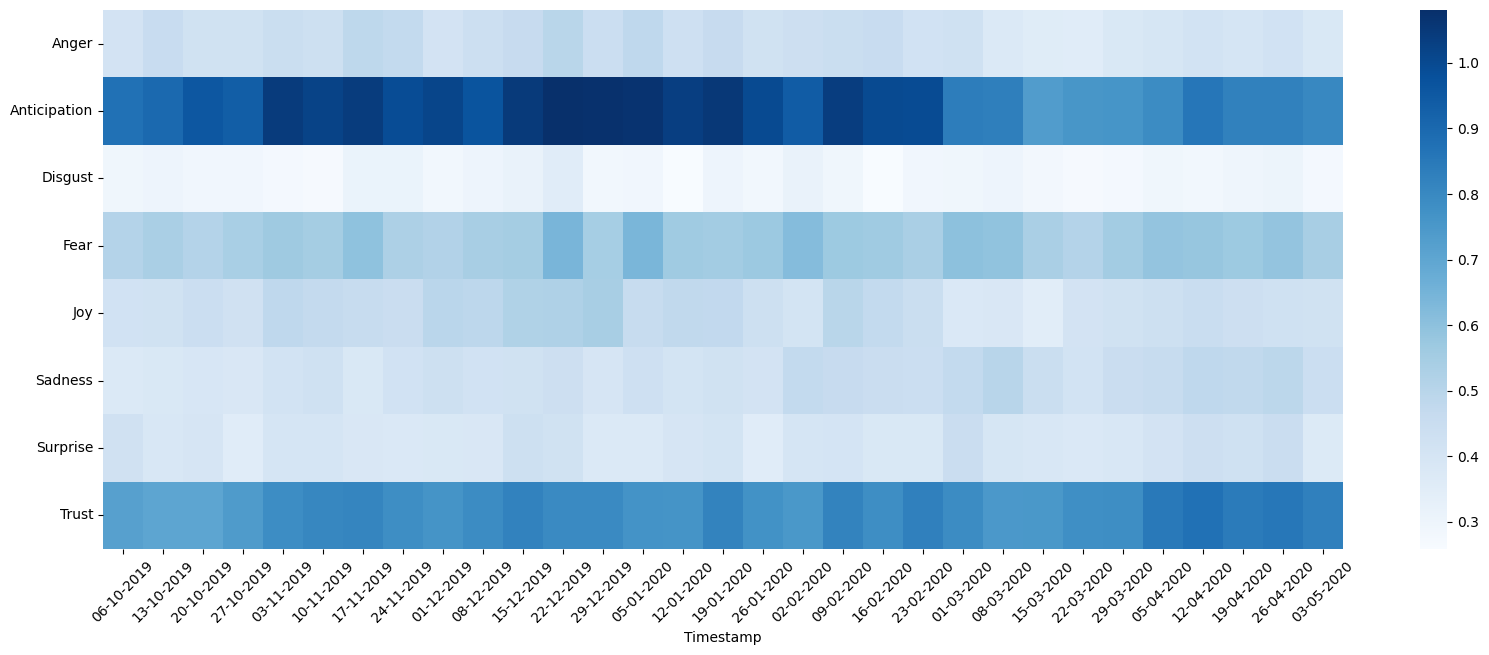

In [37]:
df_emotions_weekly = df_emotions.resample('W').sum() # sum of positive and negative 
df_emotions_weekly = df_emotions_weekly[['Anger','Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']].div(df_US_weekly.TweetCount, axis=0) 

# plot as heatmap as there are 8 values for each week
fig, ax = plt.subplots(figsize=(20,7)) 
ax = sns.heatmap(df_emotions_weekly.T, ax=ax, cmap='Blues')
ax.set_xticklabels(df_emotions_weekly.index.strftime('%d-%m-%Y'))
plt.xticks(rotation=45)

plt.show()

Global change points detected at: [ 4 10]
Local change points for emotion Anger detected at: [6]
Local change points for emotion Anticipation detected at: [11]
Local change points for emotion Disgust detected at: [ 2 10]
Local change points for emotion Fear detected at: [ 4 13]
Local change points for emotion Joy detected at: [12]
Local change points for emotion Sadness detected at: [22 29]
Local change points for emotion Surprise detected at: [ 2 29]
Local change points for emotion Trust detected at: [14 18 27]


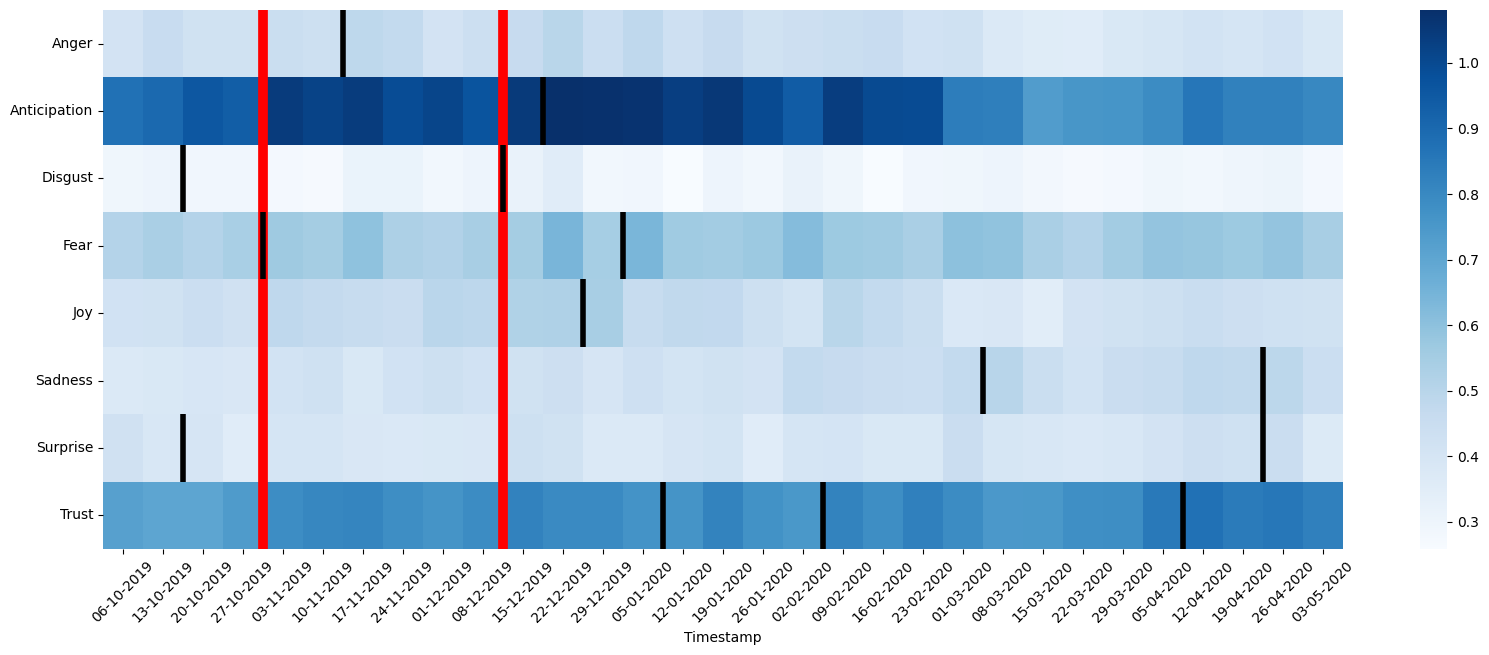

In [109]:
from scipy.signal import find_peaks

grouped = df_emotions.groupby(pd.Grouper(freq='W'))

gradients_em = pd.DataFrame(grouped.apply(lambda x: np.mean(np.square(np.gradient(x, axis=0)), axis=0)), columns=['Values'])['Values'].apply(pd.Series)
gradients = pd.DataFrame(grouped.apply(lambda x: np.mean(np.square(np.gradient(x, axis=0)))))

change_points, _ = find_peaks(gradients[0], height=np.mean(gradients[0]) + 1.5 * np.std(gradients[0]))
print('Global change points detected at:', change_points)

# plot as heatmap as there are 8 values for each week
fig, ax = plt.subplots(figsize=(20,7)) 
ax = sns.heatmap(df_emotions_weekly.T, ax=ax, cmap='Blues')
ax.set_xticklabels(df_emotions_weekly.index.strftime('%d-%m-%Y'))
plt.xticks(rotation=45)
ax.vlines(change_points, *ax.get_ylim(), color='red', linewidth=7)

for cnt, i in enumerate(gradients_em.columns):
    change_points, _ = find_peaks(gradients_em[i], height=np.mean(gradients_em[i]) + 1.5 * np.std(gradients_em[i]))
    print('Local change points for emotion', emotions[i], 'detected at:', change_points)
    ax.vlines(change_points, cnt+1, cnt, color='black', linewidth=4)


plt.show()
plt.close()


### Q2: Method choice and design

### Q3: Results & Analysis

### Q4: Comparison to literature

### Q5: Discussion

### Q6: Summary & Conclusion

## Bonus: Topic & Emotion Analysis

In [ ]:
! pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.7/381.7 KB 58.9 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel,CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline
# Create a corpus from a list of texts
diction = Dictionary(df_tweets_preprocessed['unigram'])
print(diction)
corpus = [diction.doc2bow(i) for i in df_tweets_preprocessed['unigram']]
# Train the model on the corpus.
n_topics = 4
lda = LdaModel(corpus, id2word=diction, num_topics=n_topics, random_state=42, passes=2)

Dictionary<172502 unique tokens: ['anti', 'blog', 'californian', 'diminishes', 'law']...>


In [ ]:
lda.print_topics(num_topics=n_topics, num_words=10)

[(0,
  '0.020*"trump" + 0.020*"corona" + 0.008*"crisis" + 0.008*"state" + 0.007*"lockdown" + 0.007*"coronavirus" + 0.007*"president" + 0.007*"pm" + 0.006*"india" + 0.005*"news"'),
 (1,
  '0.022*"home" + 0.022*"stay" + 0.017*"people" + 0.014*"mask" + 0.011*"social" + 0.010*"need" + 0.008*"help" + 0.008*"covid" + 0.008*"safe" + 0.008*"life"'),
 (2,
  '0.011*"quarantine" + 0.011*"like" + 0.011*"lockdown" + 0.009*"day" + 0.008*"one" + 0.008*"time" + 0.008*"get" + 0.007*"know" + 0.006*"happen" + 0.006*"thing"'),
 (3,
  '0.034*"coronavirus" + 0.034*"covid" + 0.022*"pandemic" + 0.013*"china" + 0.012*"case" + 0.011*"new" + 0.010*"death" + 0.006*"virus" + 0.006*"health" + 0.006*"lockdown"')]

100%|██████████| 391837/391837 [01:04<00:00, 6084.57it/s]
[ 47735.  67444. 180541.  96117.]


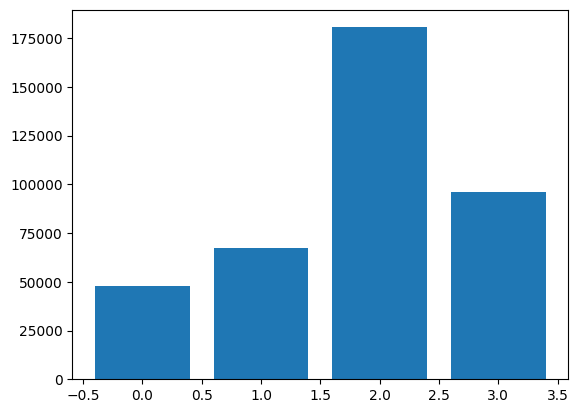

In [ ]:
from tqdm import tqdm
topics = np.zeros(n_topics)
for i in tqdm(lda[corpus]):
    arr = np.asarray([[x,y] for (x,y) in i])
    top = int(arr[np.argmax(arr[:,1])][0])
    topics[top] += 1
print(topics)

plt.bar(np.arange(0,n_topics),topics)
plt.show()
plt.close()

In [ ]:
#inspired by https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=df_tweets_preprocessed['unigram'], dictionary=diction, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.862257857913331

Coherence Score:  0.446144299472341


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, diction,R=10)
vis

/root/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.163220  0.087158       1        1  35.259251
3      0.081093 -0.291476       2        1  24.963485
1     -0.209467  0.043338       3        1  21.916177
0      0.291594  0.160980       4        1  17.861087, topic_info=              Term          Freq         Total Category  logprob  loglift
19255  coronavirus  55671.000000  55671.000000  Default  10.0000  10.0000
92878        covid  60880.000000  60880.000000  Default   9.0000   9.0000
12044     pandemic  30750.000000  30750.000000  Default   8.0000   8.0000
191           stay  27364.000000  27364.000000  Default   7.0000   7.0000
198           home  30899.000000  30899.000000  Default   6.0000   6.0000
...            ...           ...           ...      ...      ...      ...
1005         india   6313.929481   9682.753799   Topic4  -5.0772   1.2950
861           news   5345.599072   9016.010817   Topic4  -5.2436   1.1998
230       lockdown   7565.381609  37652.950200   Topic4  -4.8963   0.1177
2674         fight   5217.534205   9438.449617   Topic4  -5.2679   1.1298
19255  coronavirus   7129.226589  55671.249844   Topic4  -4.9557  -0.3327

[93 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2552      1  0.000165  business
2552      2  0.979465  business
2552      3  0.020354  business
614       3  0.999959      care
1697      2  0.999666      case
...     ...       ...       ...
4423      2  0.609003     virus
4423      3  0.304569     virus
4423      4  0.086424     virus
1952      2  0.000103    worker
1952      3  0.999823    worker

[156 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5b443c8-d722-4142-bd17-a0ebd18d1aa7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>